<a href="https://colab.research.google.com/github/Waves-Matter/THZ-image-classification/blob/main/code/u_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import numpy as np
import os
import time
from sklearn import utils
from random import randrange
import cv2

from IPython.display import clear_output
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from keras import backend as K

import PIL
from PIL import ImageOps

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') #allowini colabui accessint tavo google docs

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
atsuktuvai = np.load('/content/gdrive/My Drive/My stupid projects/Hatsune_Miku/segmentation/atsuktuvai.npy')
atsuktuvai_mask = np.load('/content/gdrive/My Drive/My stupid projects/Hatsune_Miku/segmentation/atsuktuvai_mask.npy')
raktai_ore = np.load('/content/gdrive/My Drive/My stupid projects/Hatsune_Miku/segmentation/ore_raktai.npy')
raktai_ore_mask = np.load('/content/gdrive/My Drive/My stupid projects/Hatsune_Miku/segmentation/ore_raktai_mask.npy')

In [ ]:
dataset_pics = np.concatenate((raktai_ore, atsuktuvai), axis=0)
dataset_masks = np.concatenate((raktai_ore_mask, atsuktuvai_mask), axis=0)

dataset_pics = np.expand_dims(dataset_pics, axis=-1)
dataset_masks = np.expand_dims(dataset_masks, axis=-1)
dataset_pics.shape

(38, 128, 128, 1)

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.xlabel("X pikseliai")
        plt.ylabel("y Pikseliai")
        plt.axis('on')
    plt.show()



def display_mask(image):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(image, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    return img

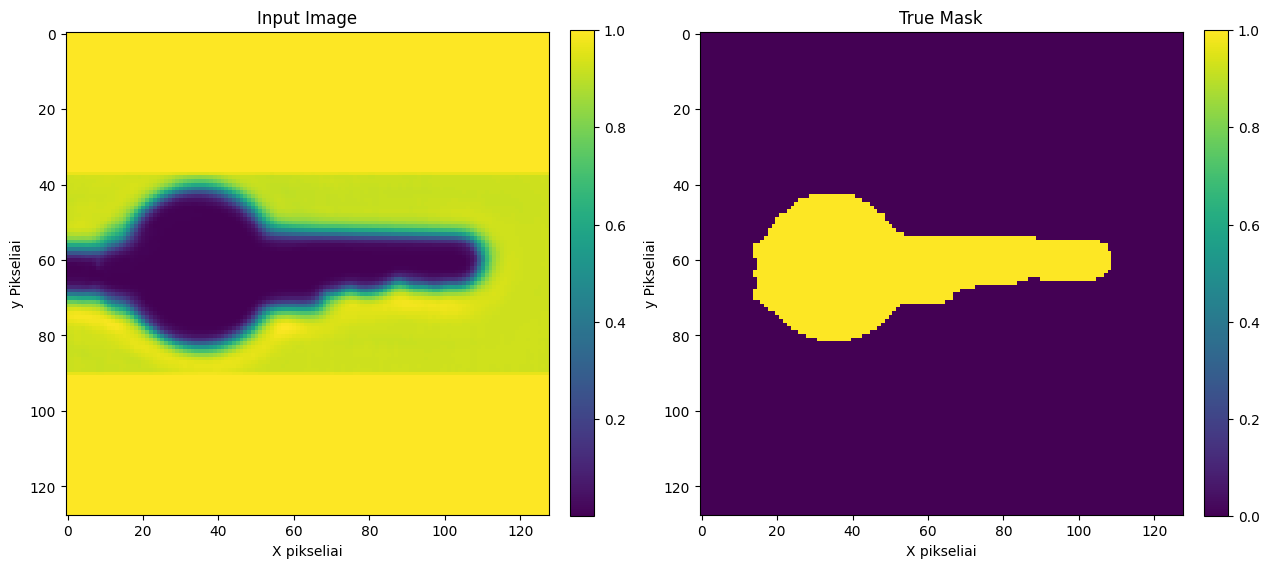

In [ ]:
#pcheck the data

g=randrange(38)
sample_image, sample_mask = dataset_pics[g], dataset_masks[g]
display([sample_image, sample_mask])

In [ ]:
img_size=img_size = (128, 128)
num_classes = 3

In [ ]:
def dice_metric(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    # if y_pred.sum() == 0 and y_pred.sum() == 0:
    #     return 1.0

    return 2*intersection / union

In [ ]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

    if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_up_down(input_image)
       input_mask = tf.image.flip_up_down(input_mask)

    if tf.random.uniform(()) > 0.25:
        input_image = tf.image.rot90(input_image, k=1)
        input_mask = tf.image.rot90(input_mask, k=1)
    else:
        if tf.random.uniform(()) > 0.5:
            input_image = tf.image.rot90(input_image, k=2)
            input_mask = tf.image.rot90(input_mask, k=2)
        else:
            if tf.random.uniform(()) > 0.75:
                input_image = tf.image.rot90(input_image, k=3)
                input_mask = tf.image.rot90(input_mask, k=3)




    return input_image, input_mask

def noise(x):
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=0.02, dtype=tf.float32)
    x = x + noise
    x = tf.clip_by_value(x, 0.0, 1.0)
    return x

In [ ]:
def get_Initial_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))
    noised = tf.keras.layers.Lambda(noise)(inputs)
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 1, strides=2, padding="same")(noised)
    #x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        #x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
     #   x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        x = layers.Dropout(0.3)(x)
        #x = layers.GaussianNoise(0.1)(x) #noise

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
      #  x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
       # x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)
        x = layers.Dropout(0.3)(x)
        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_Initial_model(img_size, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128, 128, 1)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 32)     │             64 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 64, 64, 32)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 64, 64, 32)     │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 64, 64, 64)     │          2,400 │ activation_1[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 64)     │              0 │ separable_conv2d[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 64, 64, 64)     │          4,736 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ separable_conv2d_1[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │          2,112 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ dropout[0][0],         │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 32, 32, 128)    │          8,896 │ activation_3[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 32, 32, 128)    │              0 │ separable_conv2d_2[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_3        │ (None, 32, 32, 128)    │         17,664 │ activation_4[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1      

 Total params: 2,050,595 (7.82 MB)

 Trainable params: 2,050,595 (7.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
BATCH_SIZE = 4
BUFFER_SIZE = 40



model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/My stupid projects/Hatsune_Miku/segmentation/checkpoints/ch_augm_hxw.h5.keras', save_best_only=True)]


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 539ms/step - loss: 0.1445
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 571ms/step - loss: 0.1043
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 549ms/step - loss: 0.0867
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 557ms/step - loss: 0.0737
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 791ms/step - loss: 0.0676
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 514ms/step - loss: 0.0620
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 659ms/step - loss: 0.0529
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 516ms/step - loss: 0.0392
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 514ms/step - loss: 0.0413
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 677ms/step - loss: 0.0342


In [ ]:
rand_tr_images, rand_tr_lab = utils.shuffle(dataset_pics, dataset_masks)
print(rand_tr_images.shape)
print(rand_tr_lab.shape)


rand_tr_images, rand_tr_lab = augment(rand_tr_images, rand_tr_lab)
rand_tr_lab = np.squeeze(rand_tr_lab, axis=-1)
rand_tr_images=np.squeeze(rand_tr_images, axis=-1)
print(rand_tr_images.shape)
print(rand_tr_lab.shape)

(38, 128, 128, 1)
(38, 128, 128, 1)
(38, 128, 128)
(38, 128, 128)


In [ ]:
epochs = 10

model.fit(x=rand_tr_images, y=rand_tr_lab,
           batch_size=BATCH_SIZE, epochs=epochs, callbacks=callbacks)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 528ms/step - loss: 0.0287
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 781ms/step - loss: 0.0307
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 540ms/step - loss: 0.0309
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 526ms/step - loss: 0.0284
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 649ms/step - loss: 0.0279
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 726ms/step - loss: 0.0239
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 567ms/step - loss: 0.0266
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 794ms/step - loss: 0.0235
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 517ms/step - loss: 0.0299
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 594ms/step - loss: 0.0257


In [ ]:
val_preds = model.predict(dataset_pics)

# pirmas_class_list = []
# antras_class_list = []
# trecias_class_list = []

# for number in range(len(dataset_pics)):
#     one_temp, two_temp, three_temp = cv2.split(val_preds[number])
#     pirmas_class_list.append(one_temp)
#     antras_class_list.append(two_temp)
#     trecias_class_list.append(three_temp)


# pirmas_class_list = np.array(pirmas_class_list)
# antras_class_list = np.array(antras_class_list)
# trecias_class_list = np.array(trecias_class_list)
# print(pirmas_class_list.shape)
# print(antras_class_list.shape)
# print(trecias_class_list.shape)
# print(dataset_masks.shape)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step


In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

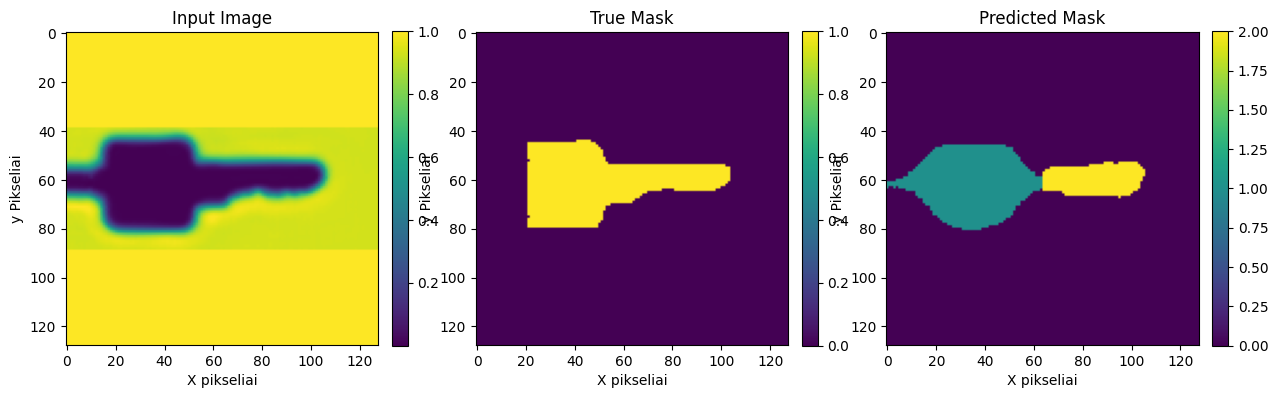

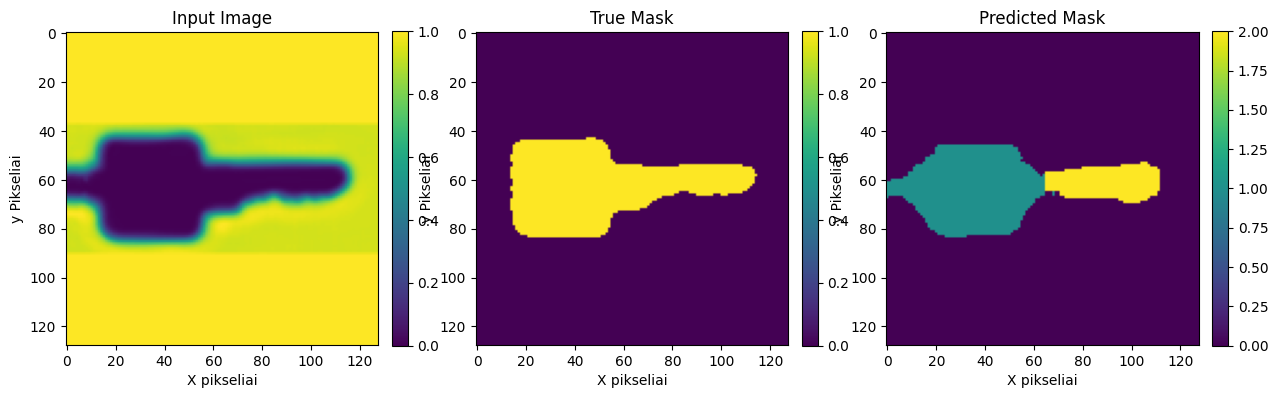

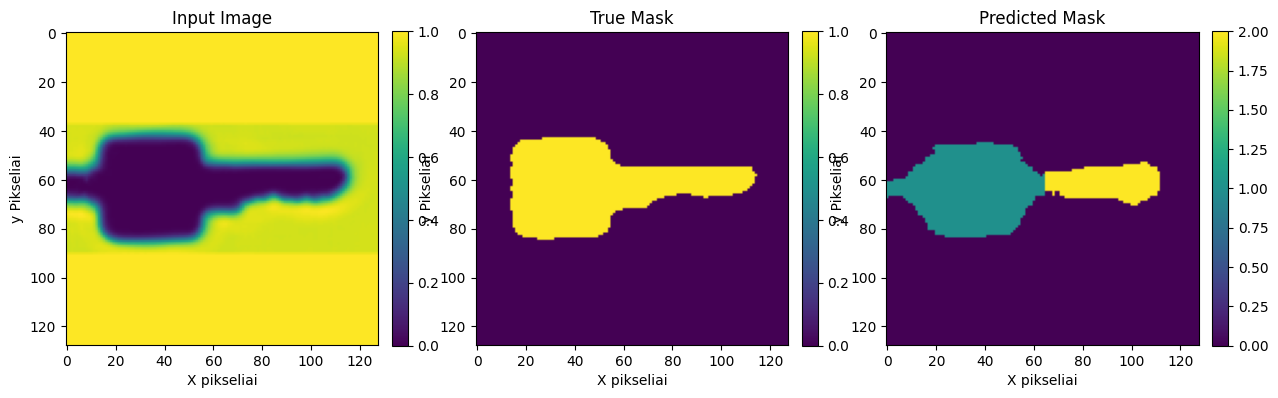

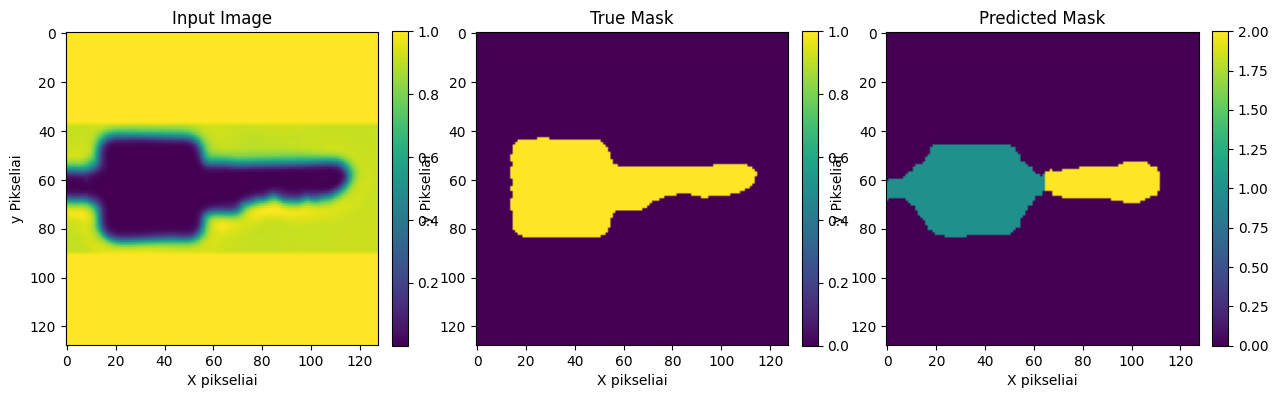

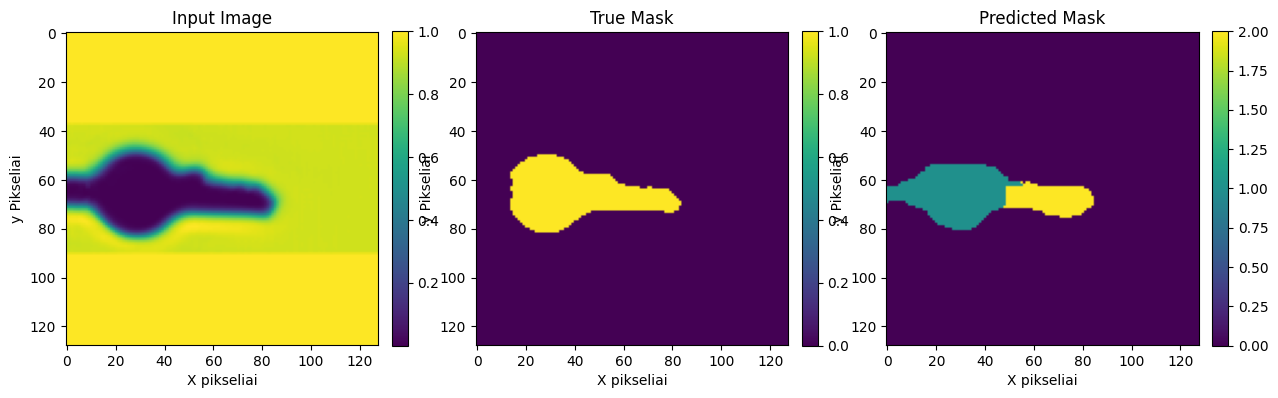

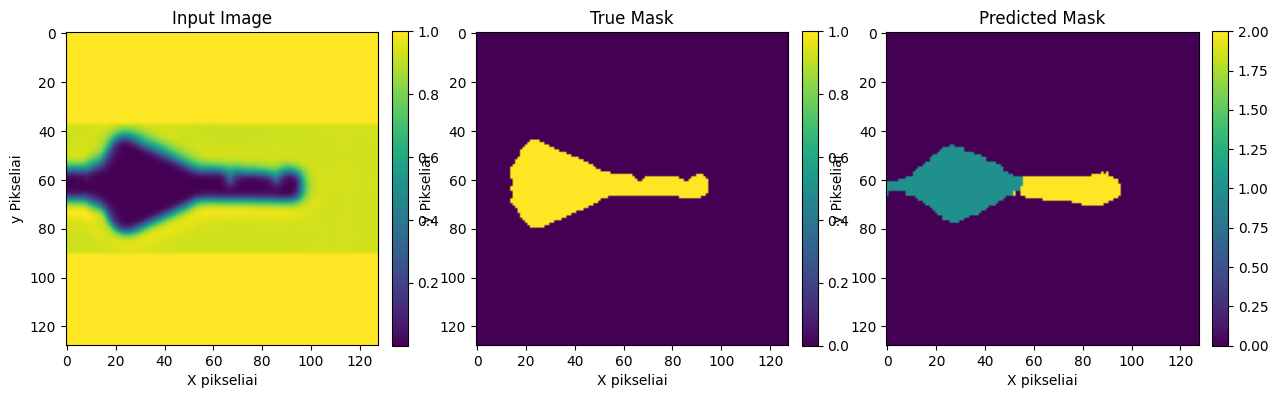

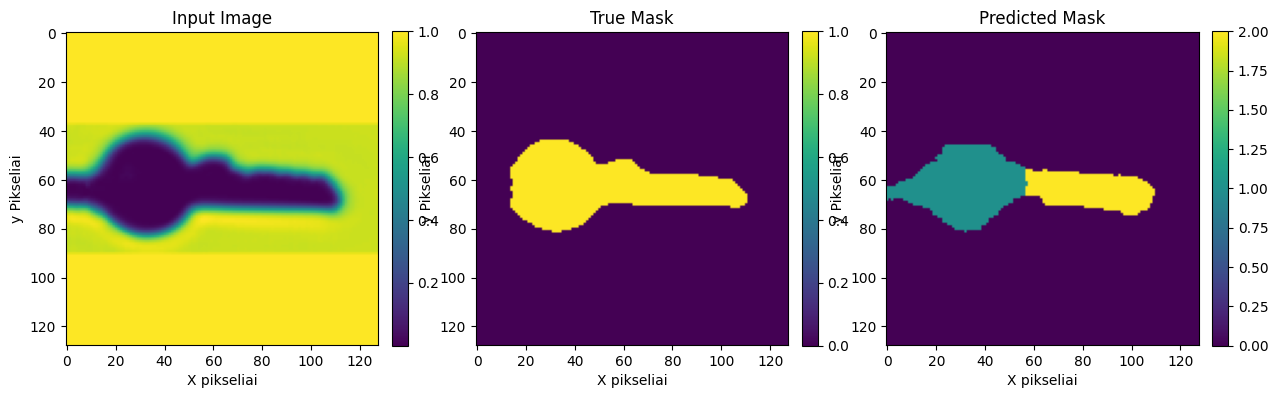

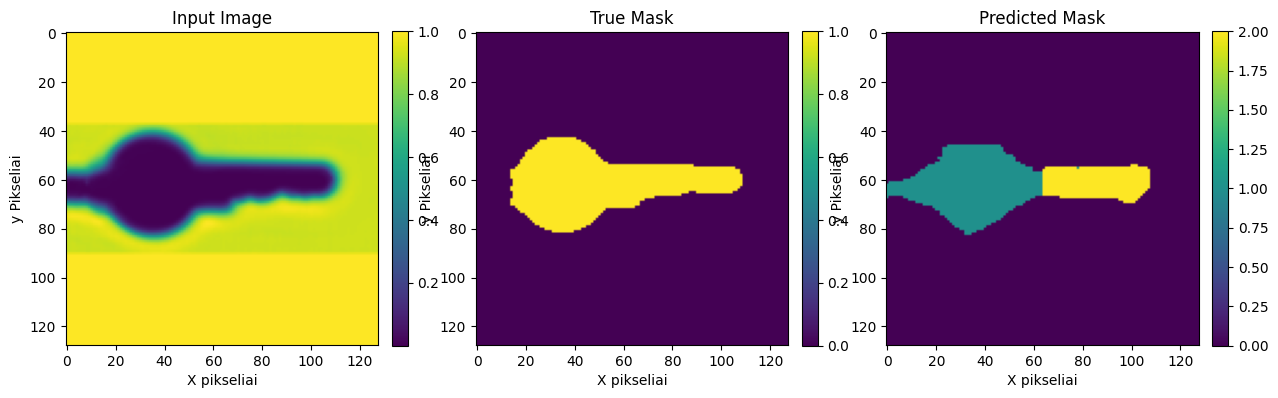

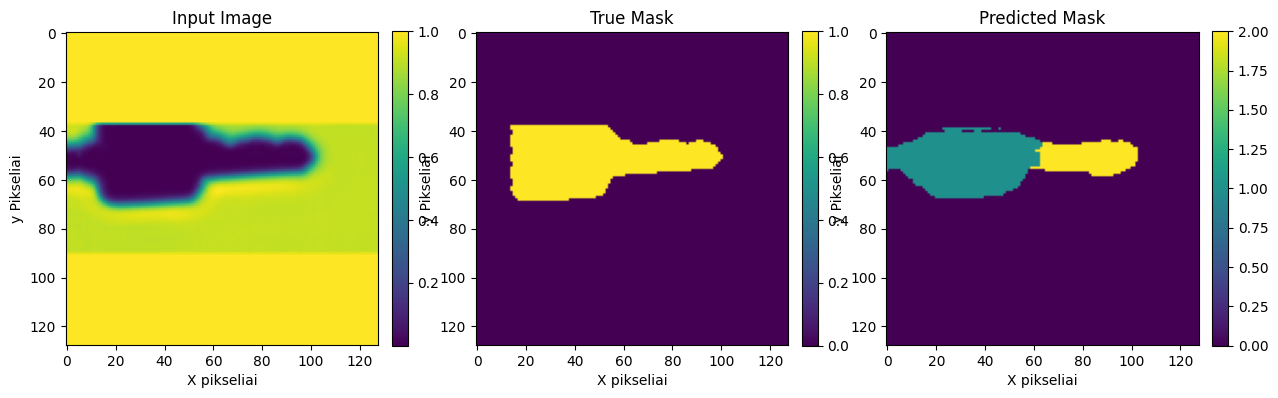

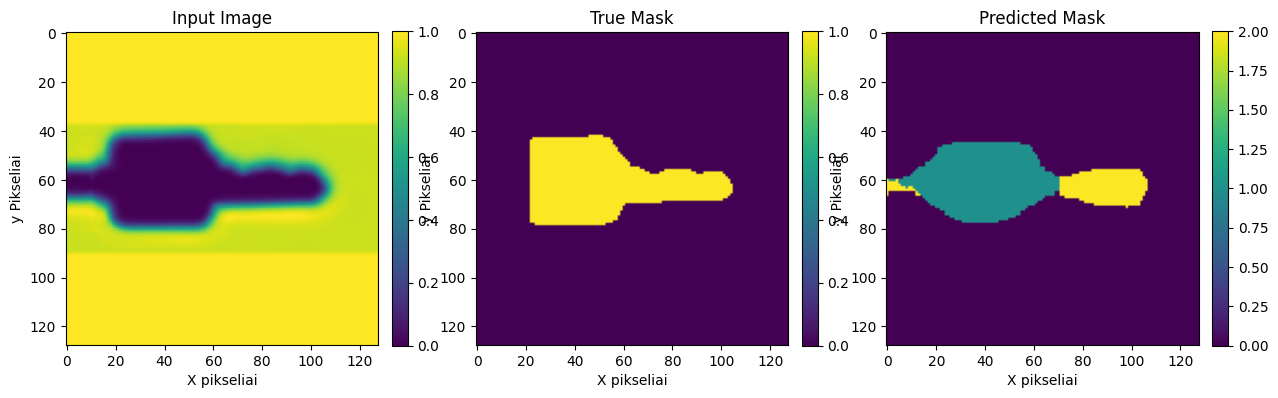

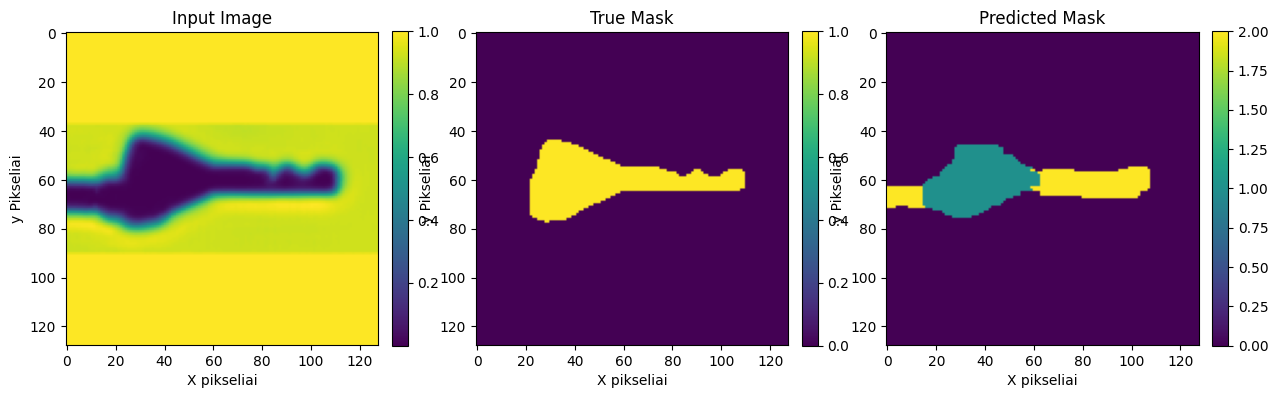

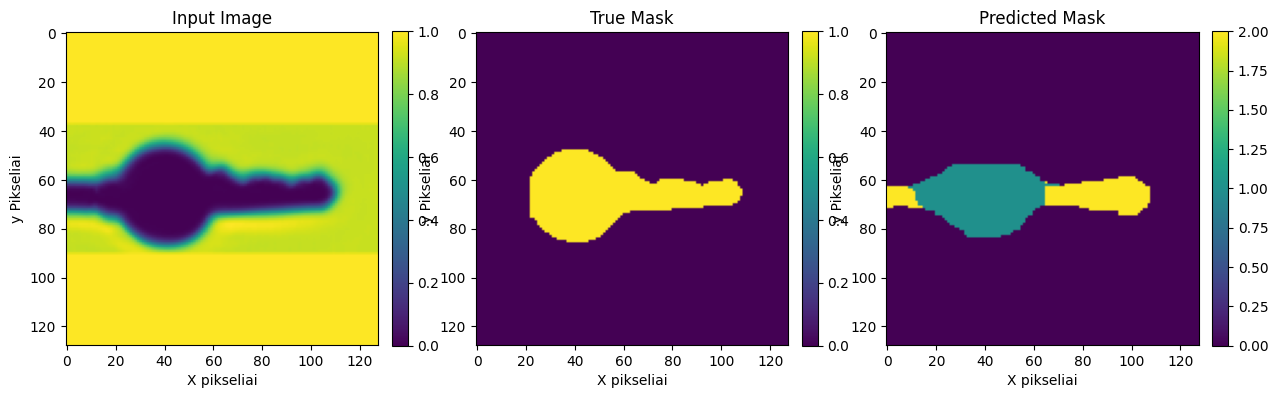

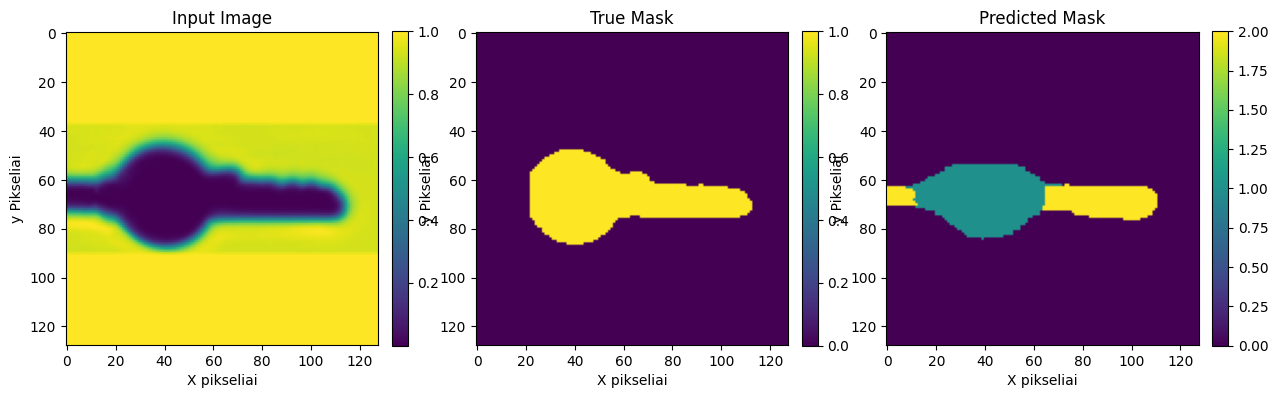

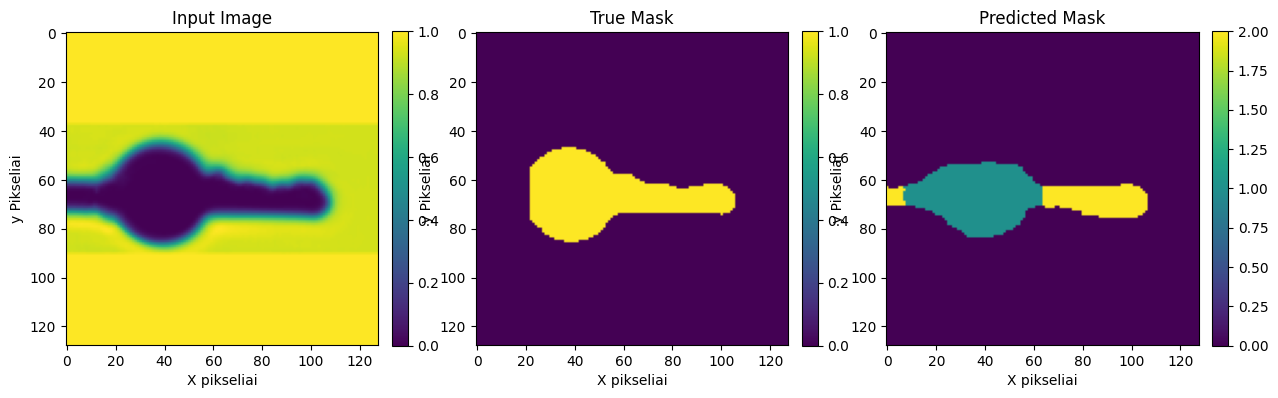

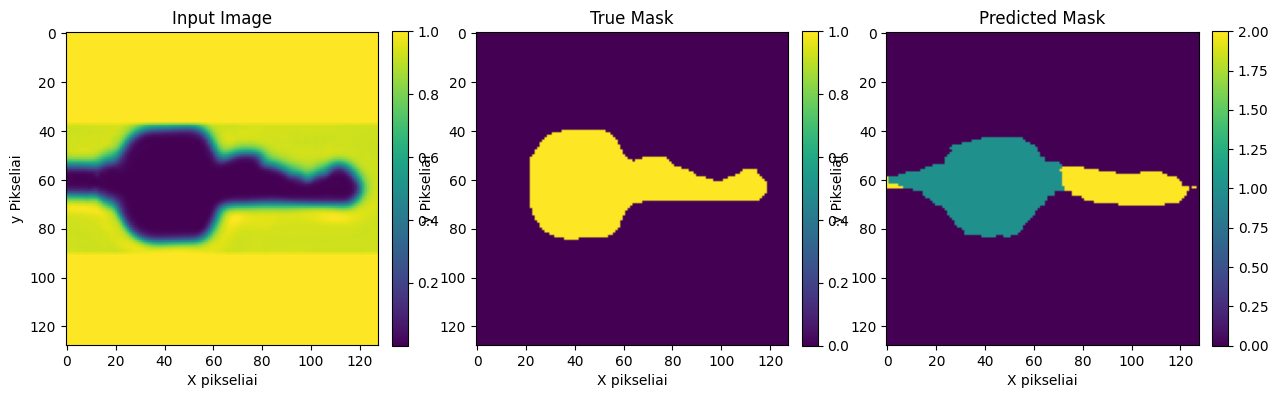

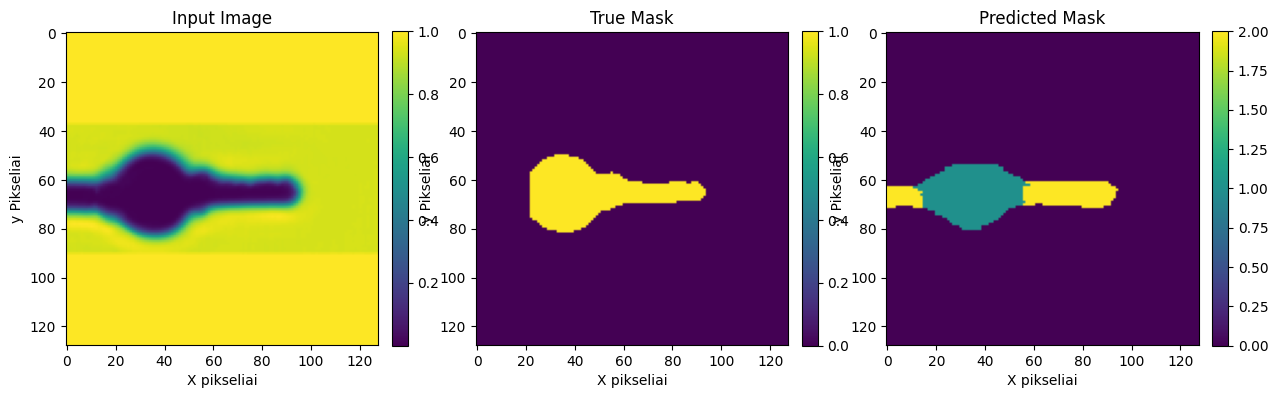

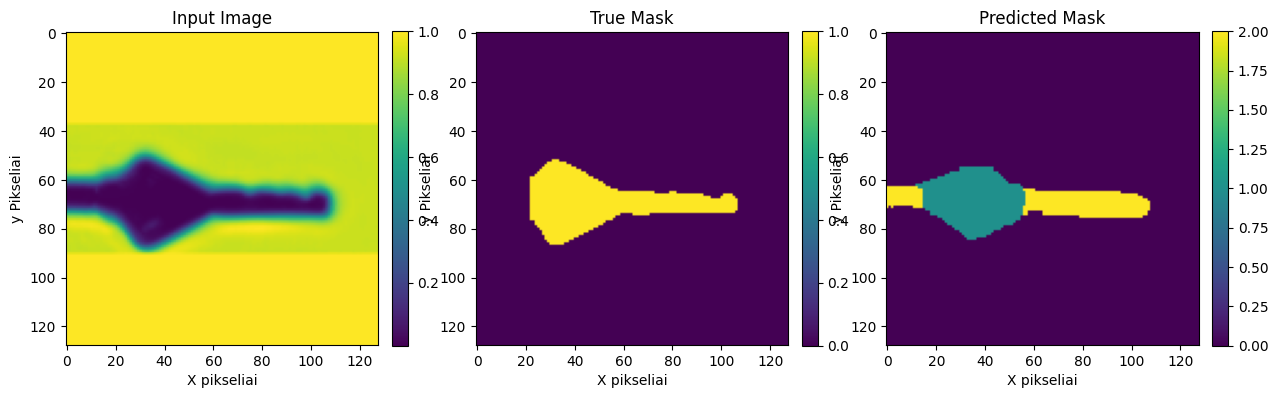

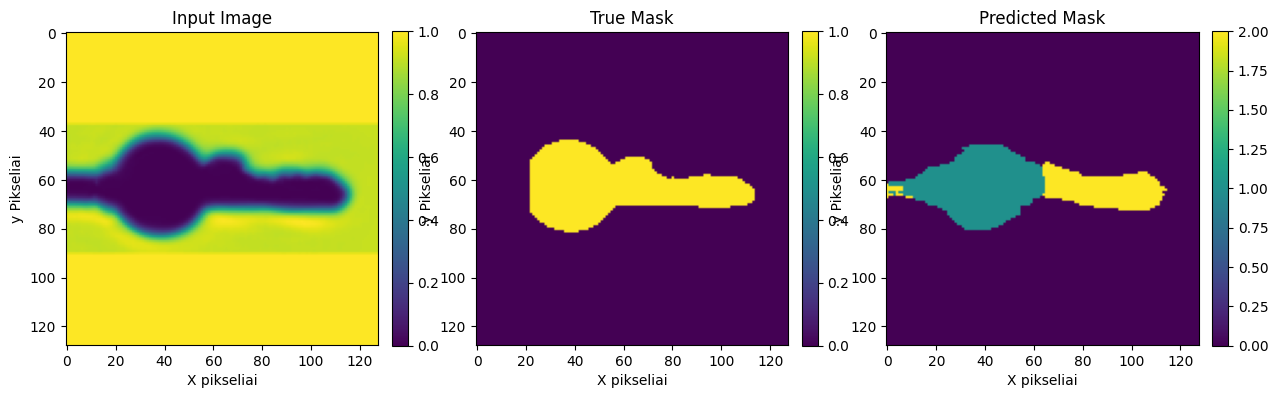

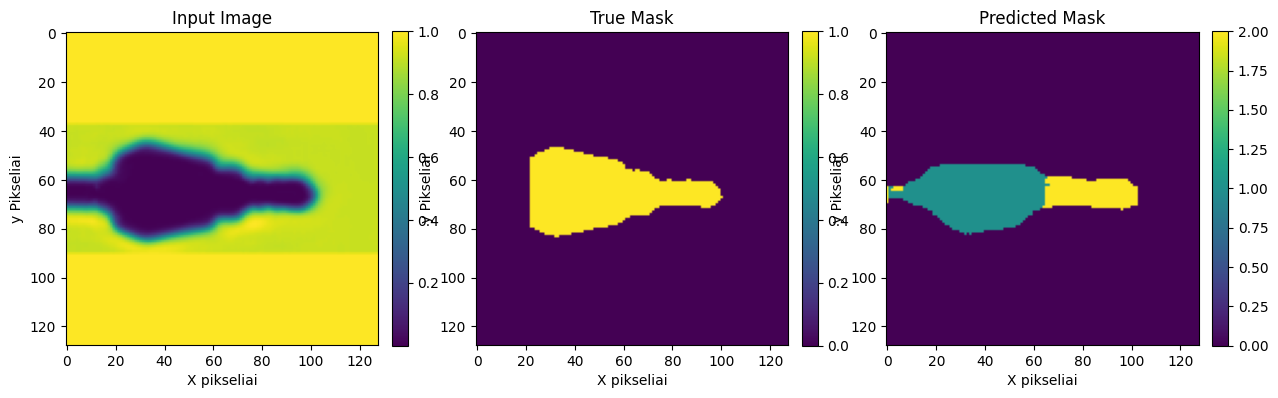

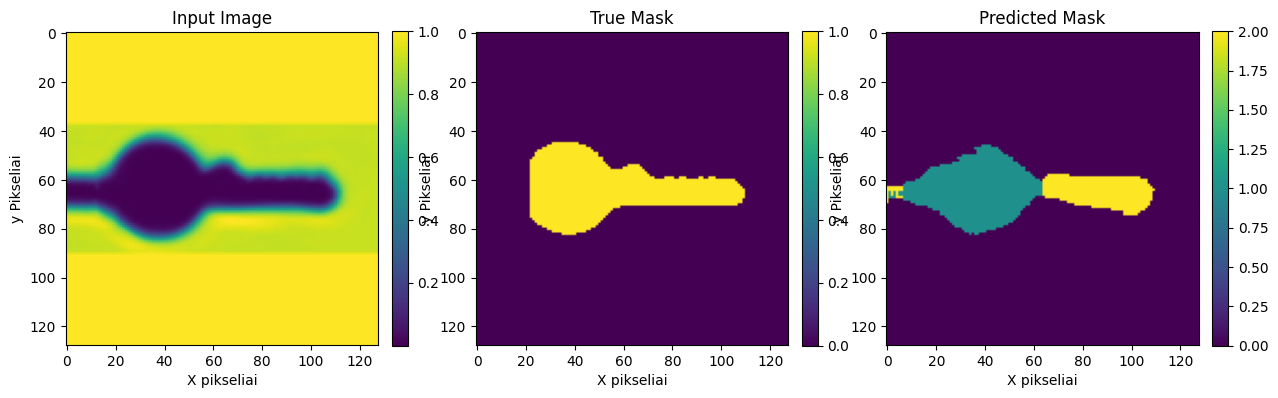

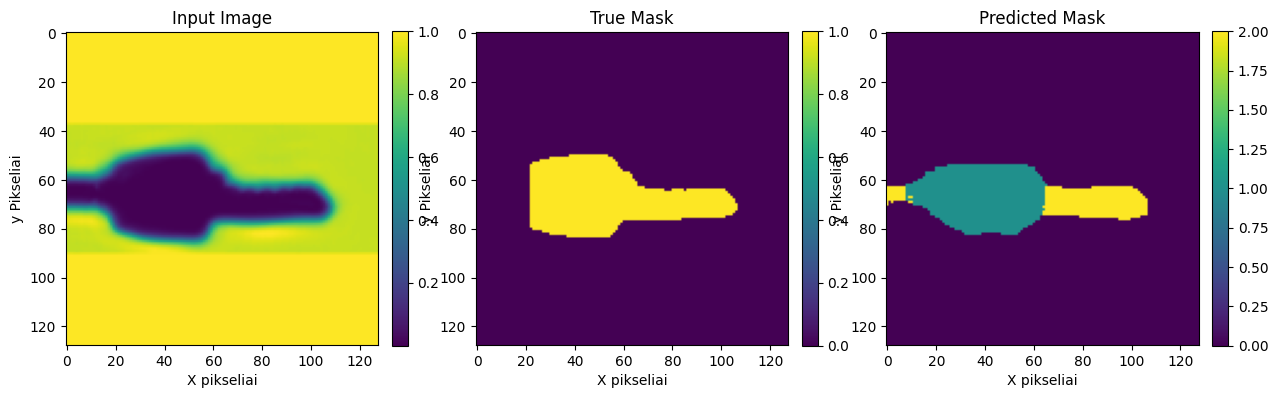

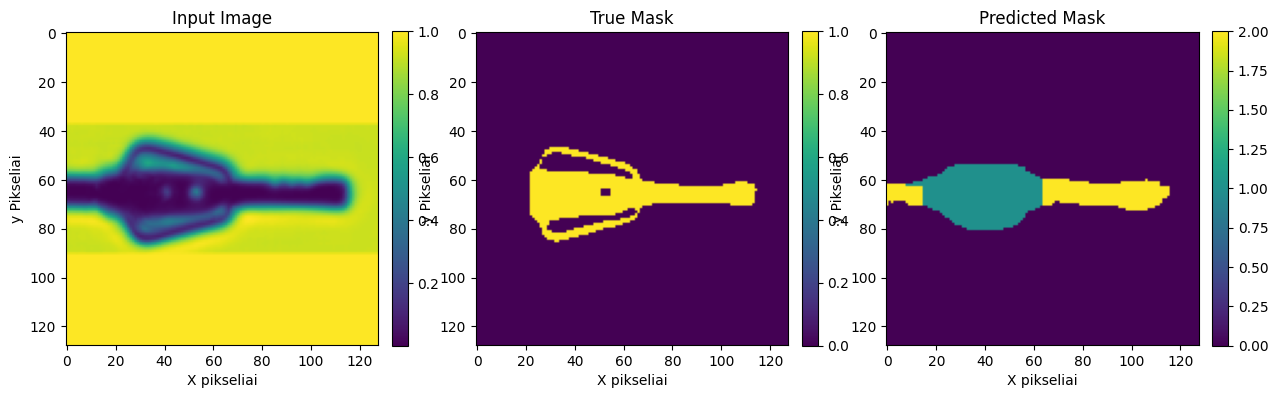

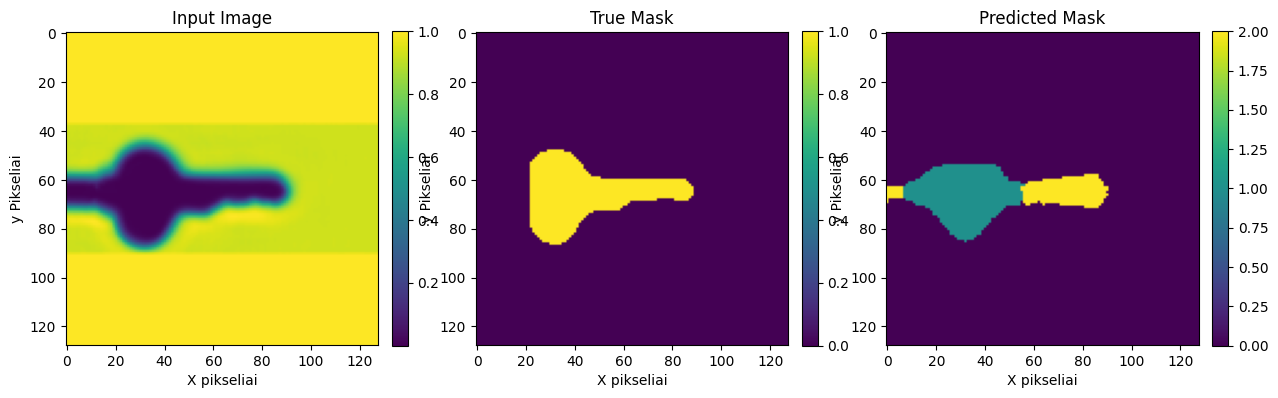

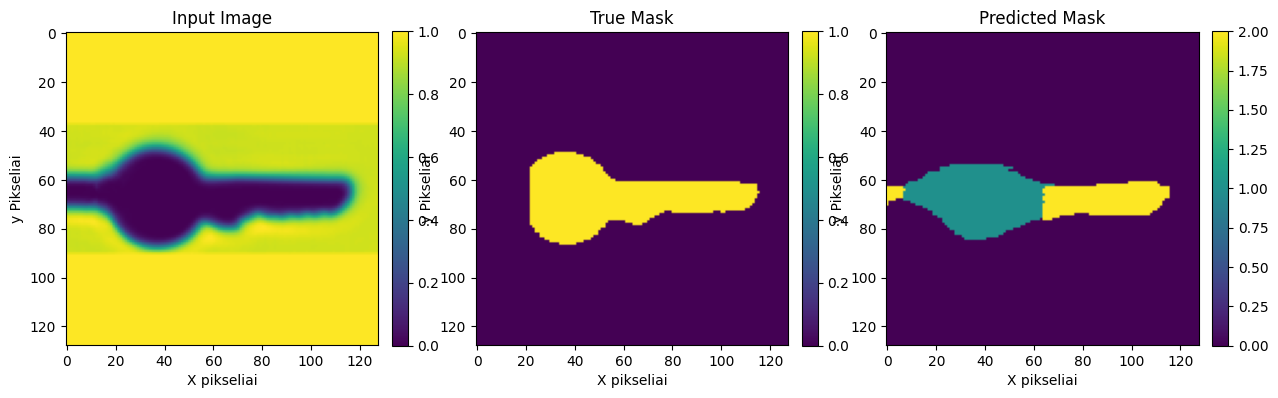

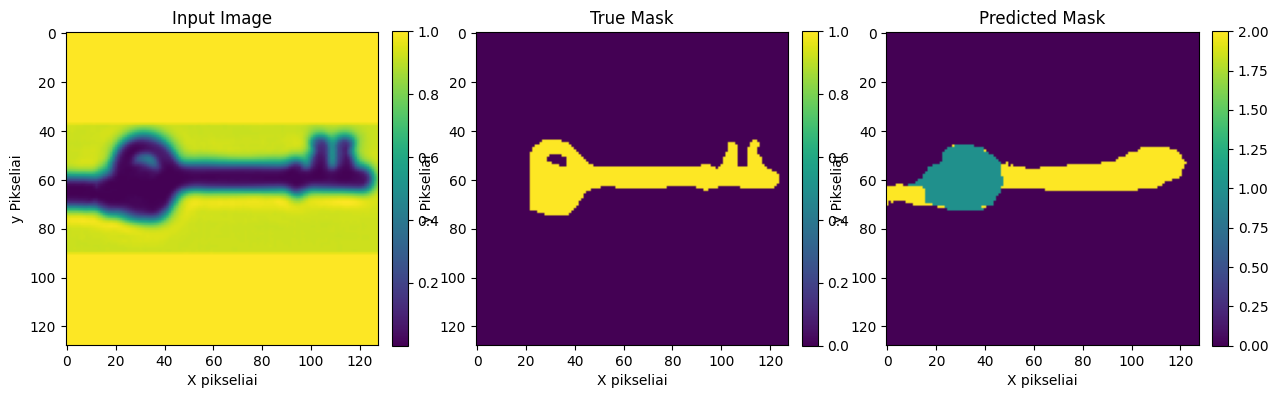

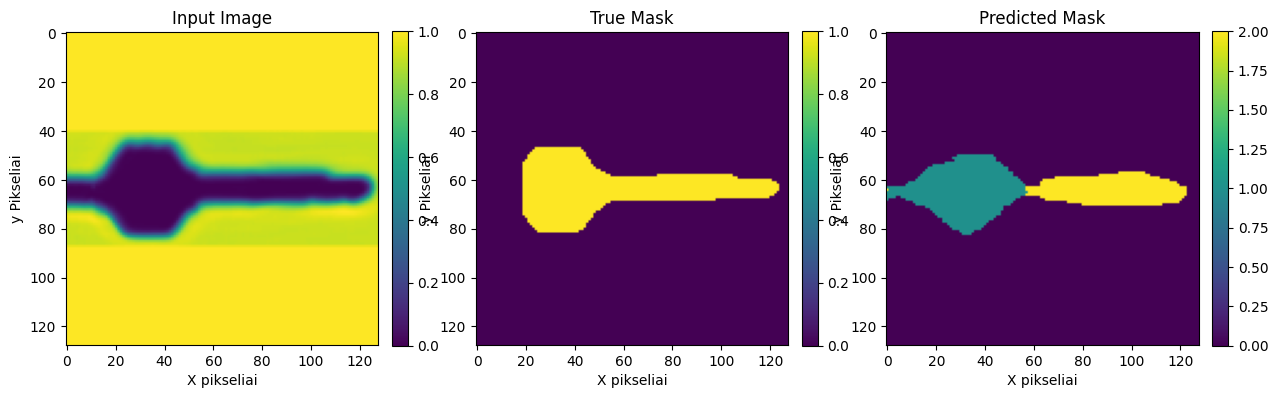

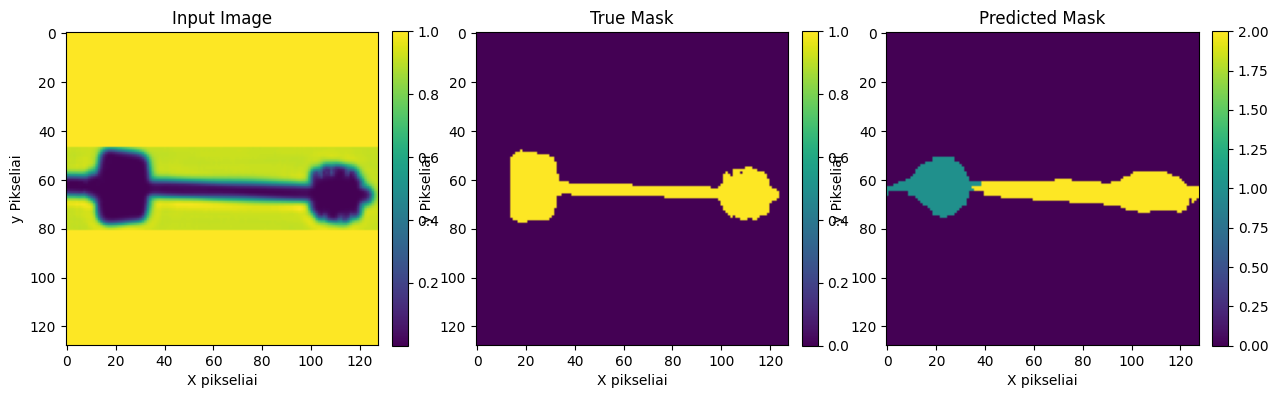

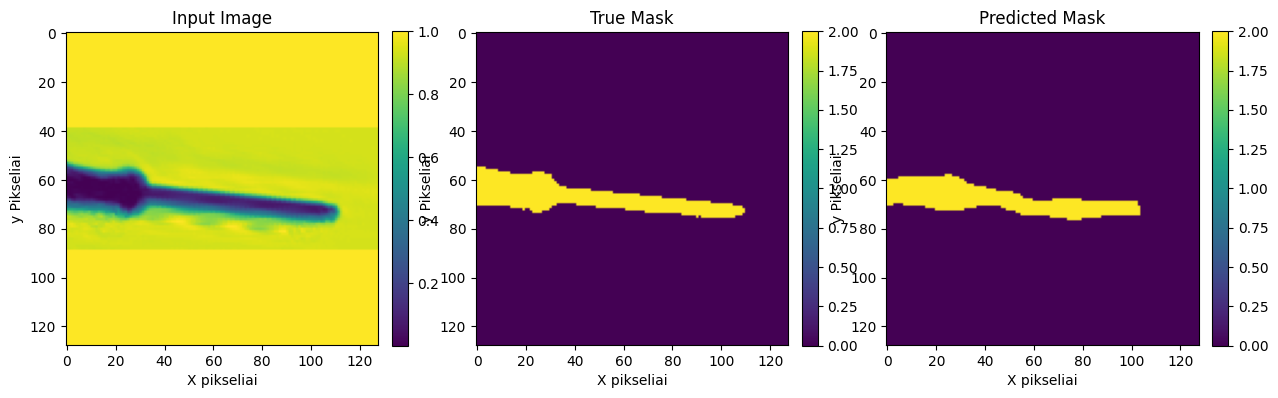

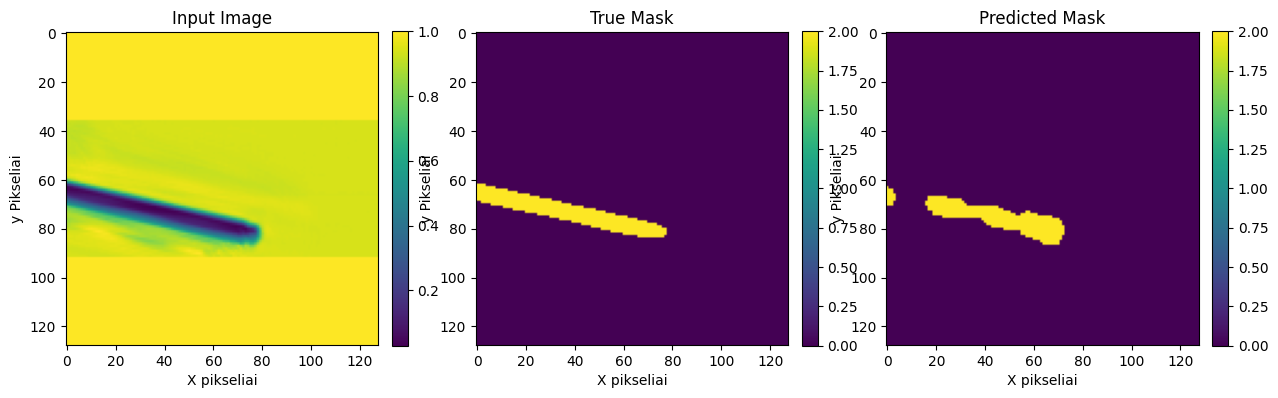

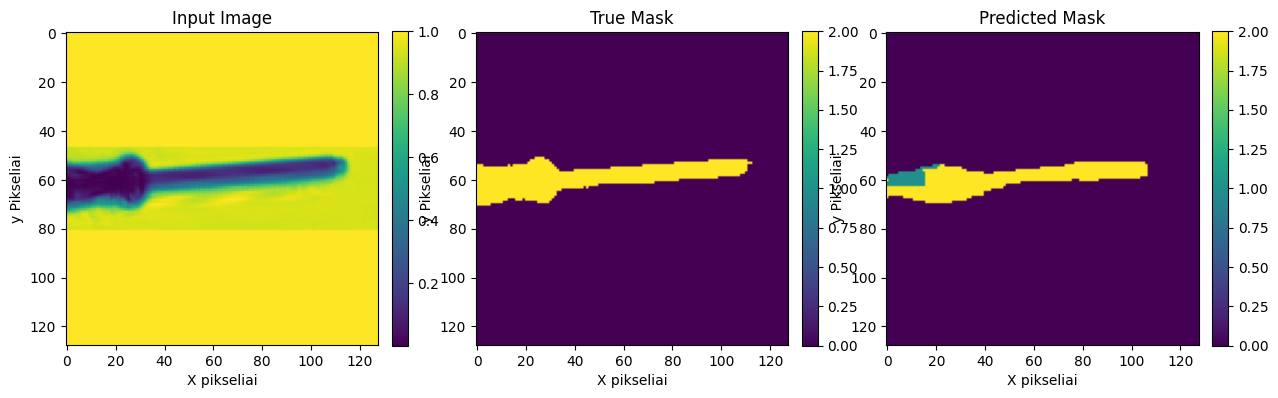

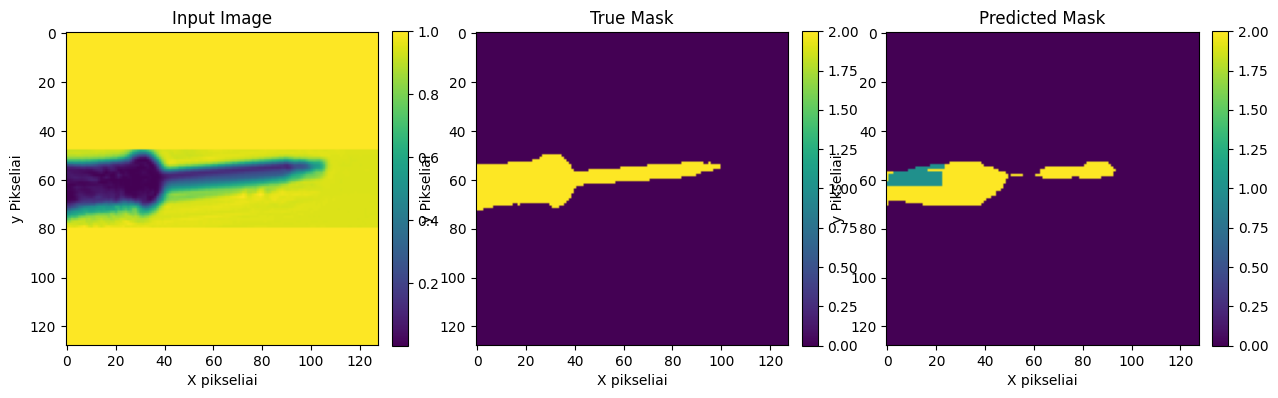

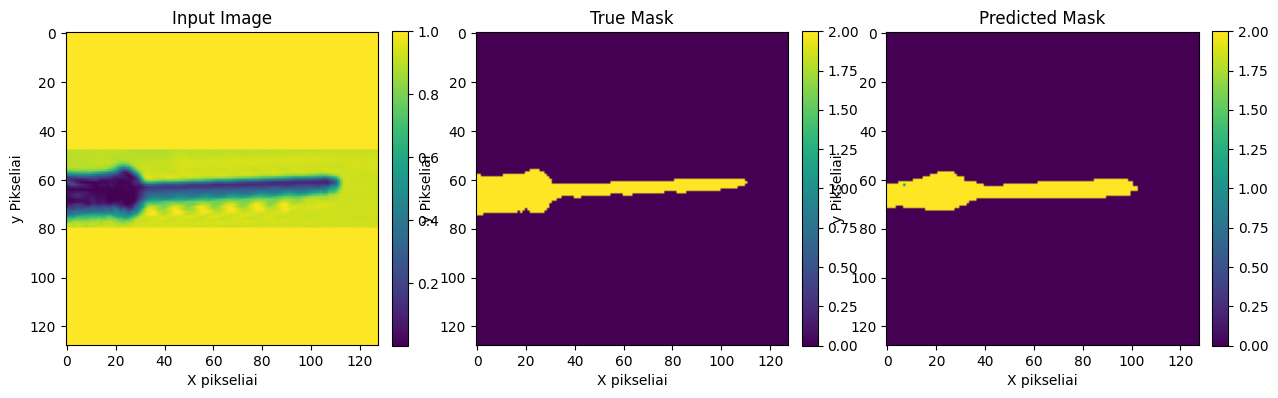

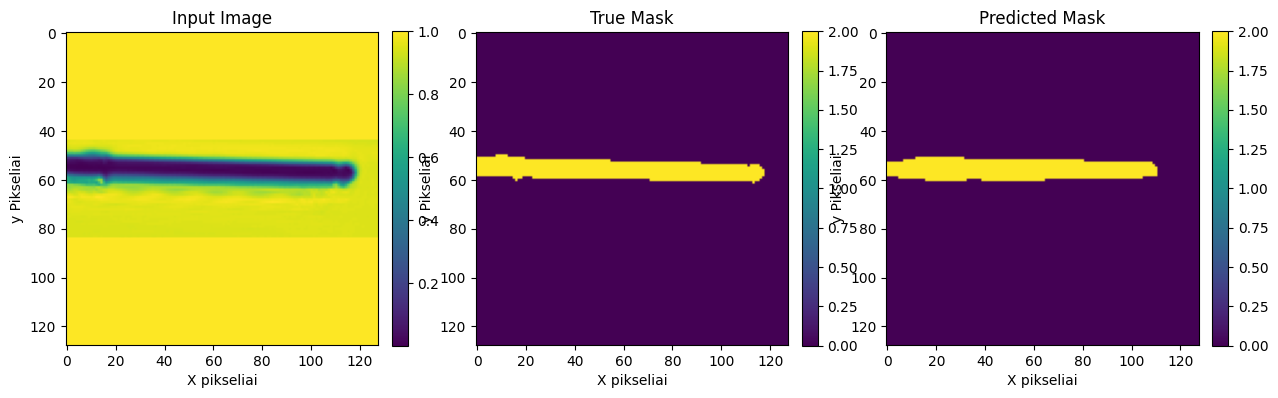

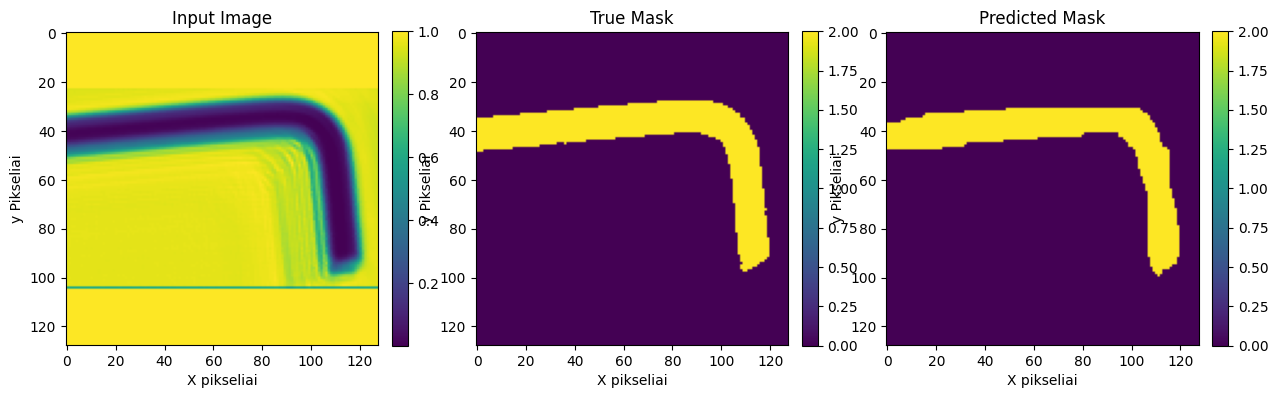

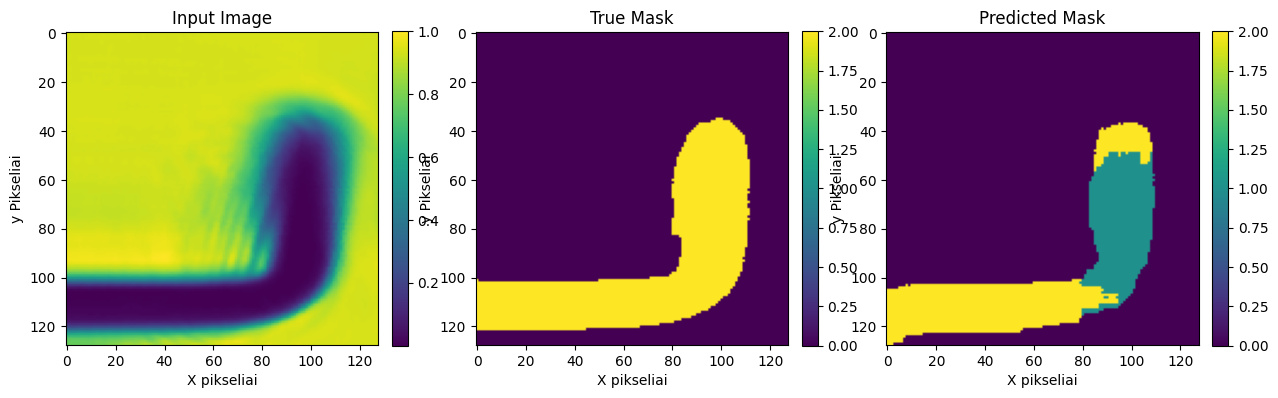

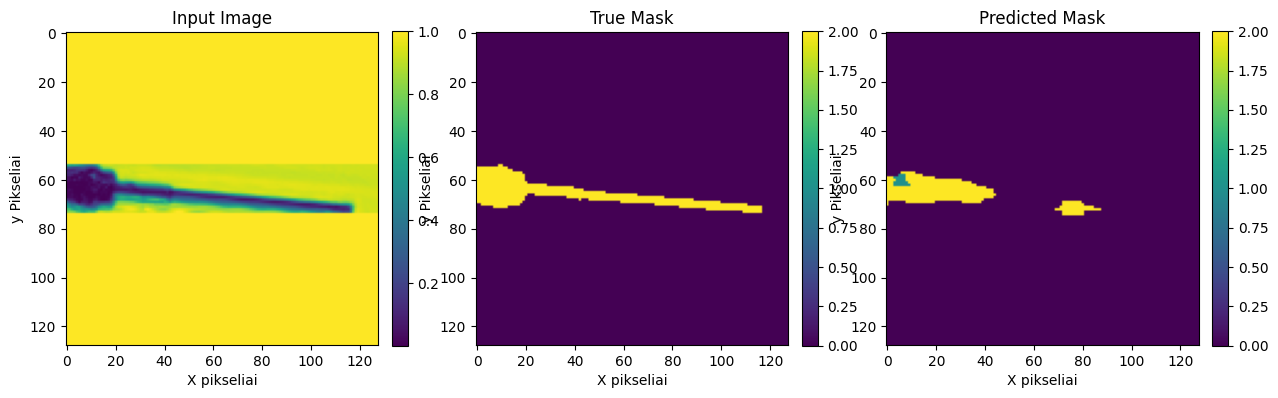

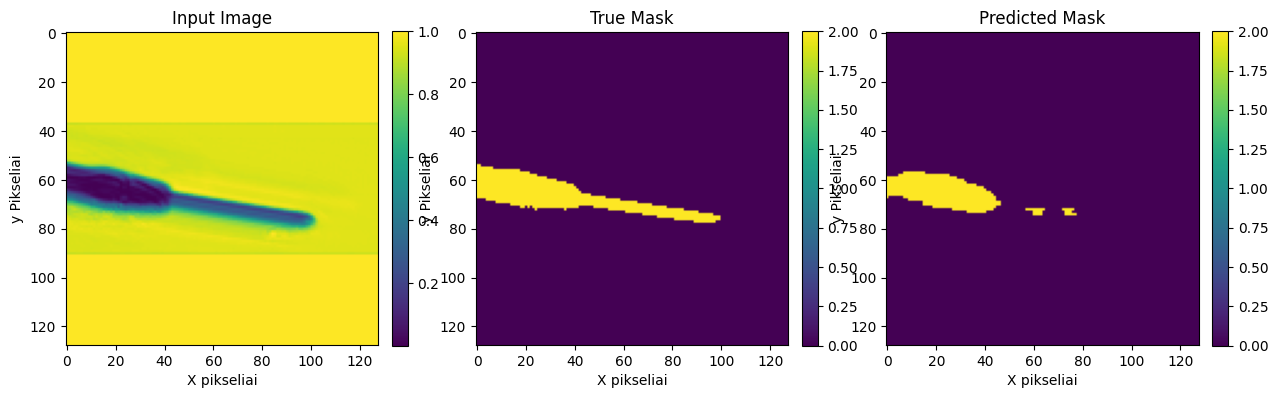

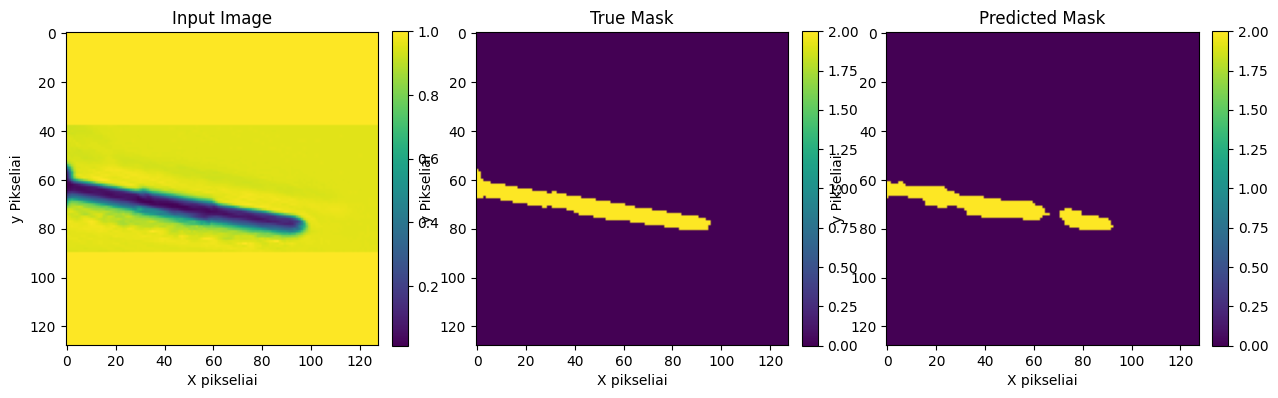

In [ ]:
from time import sleep



for num in range(len(dataset_pics)):
    display([dataset_pics[num], dataset_masks[num], create_mask(val_preds[num])])
    print(num, end="\r")
    os.system('cls' if os.name == 'nt' else 'clear')

In [ ]:
tinklelis = np.load('/content/gdrive/My Drive/My stupid projects/Hatsune_Miku/segmentation/tinklelis_padded.npy')

for i in range (len(tinklelis)):
    max_val = tinklelis[i].max()
    if max_val > 0:
        tinklelis[i] = tinklelis[i] / max_val

tinklelis = np.expand_dims(tinklelis, axis=-1)

tinkl_preds = model.predict(tinklelis)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


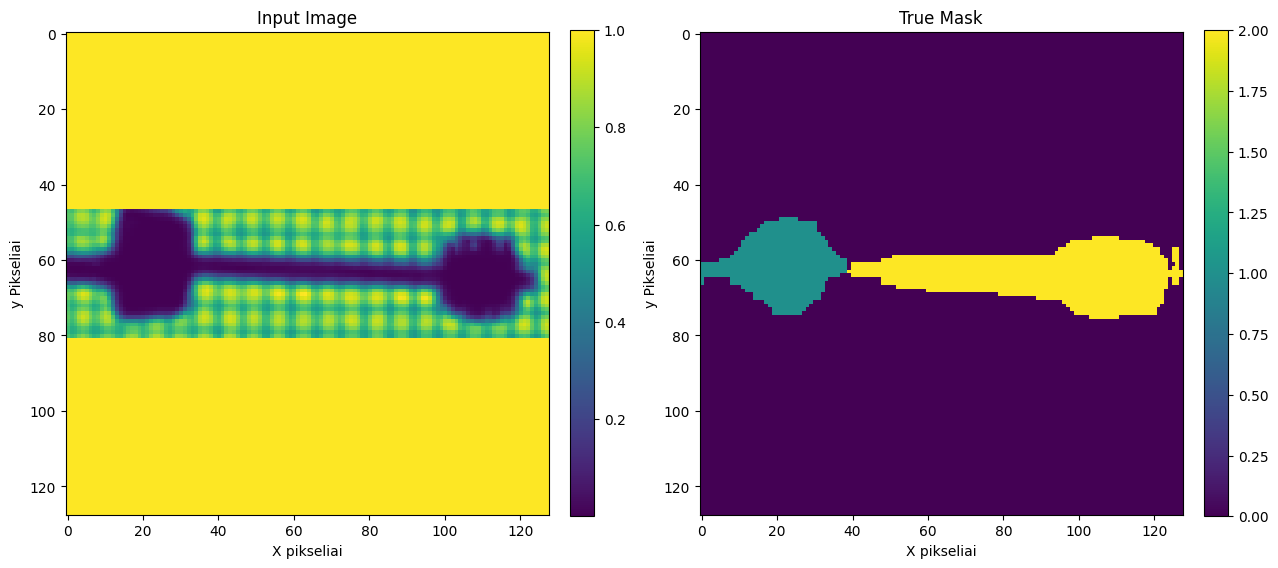

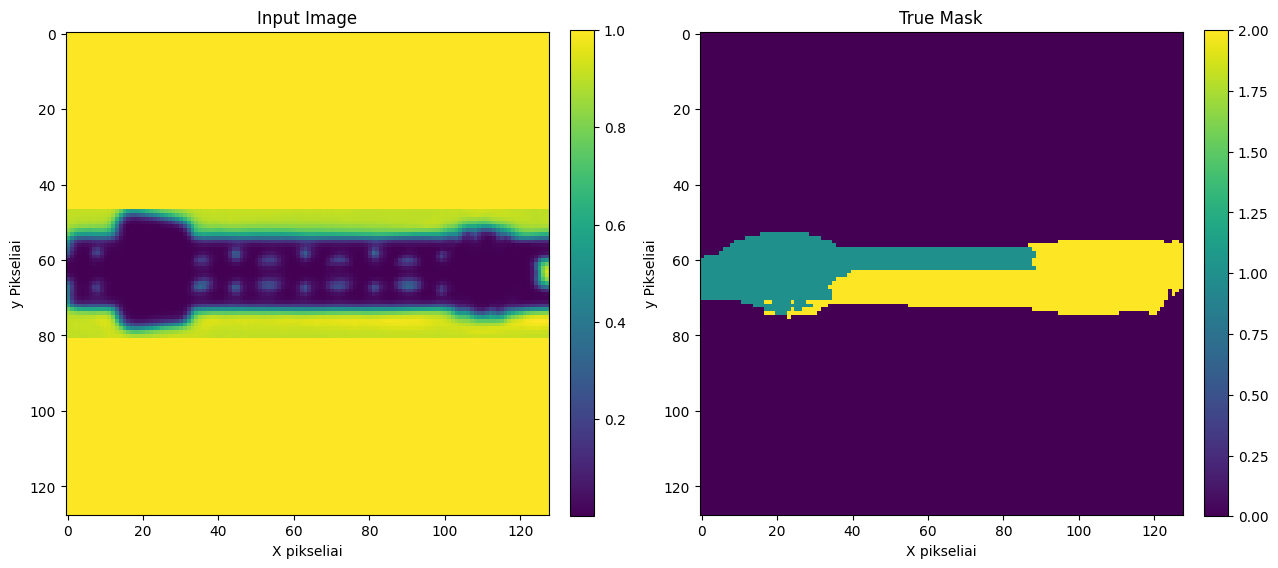

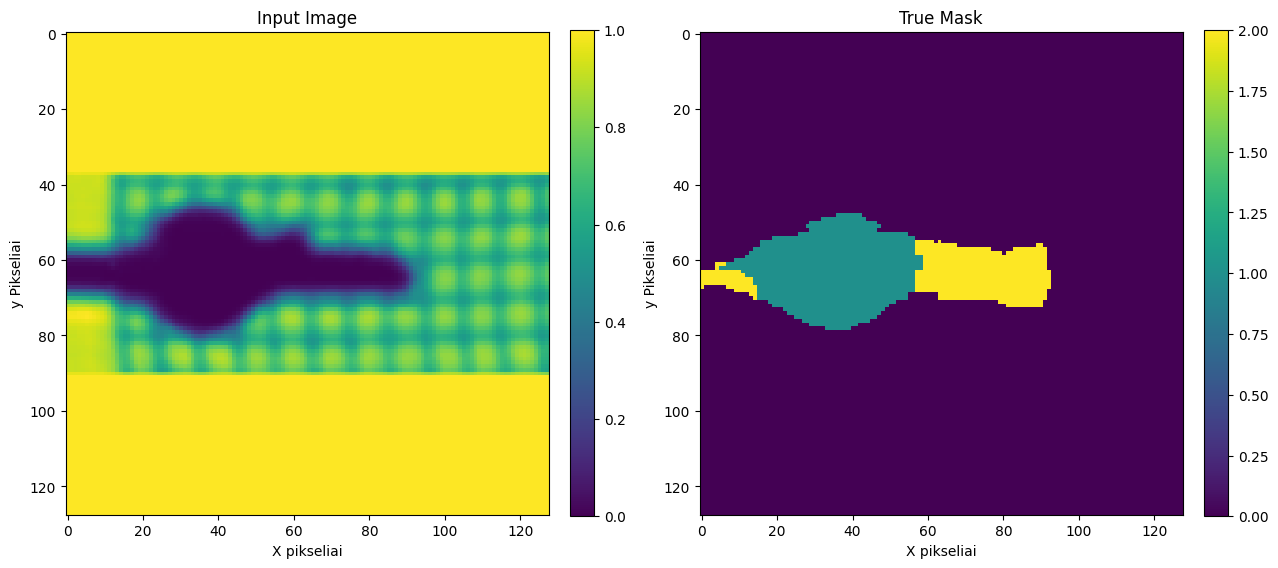

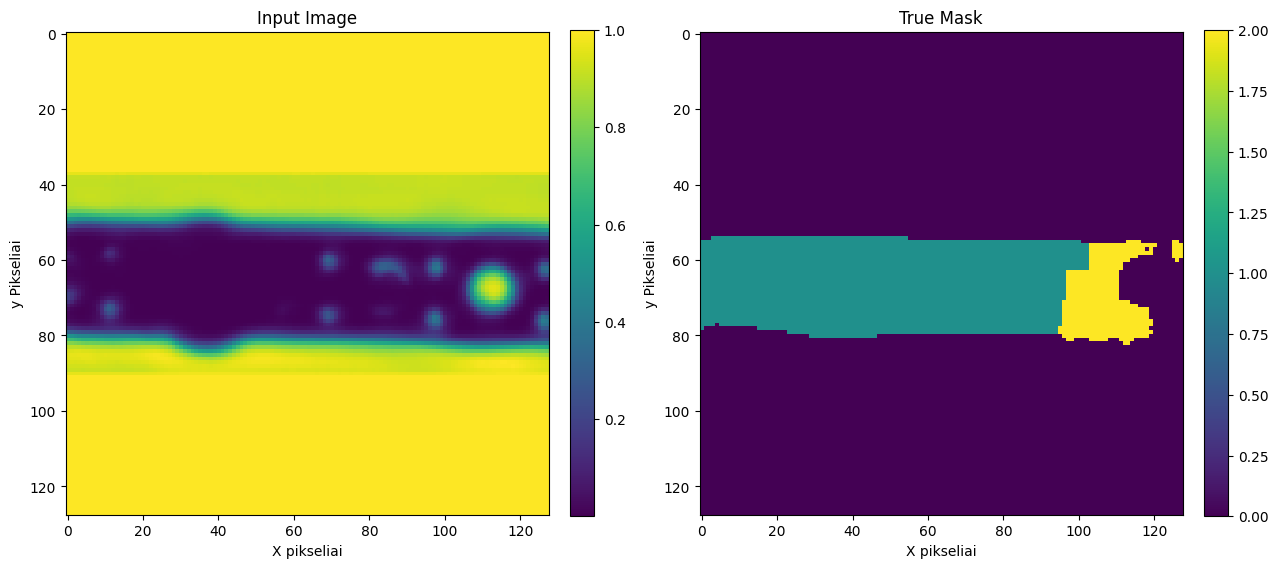

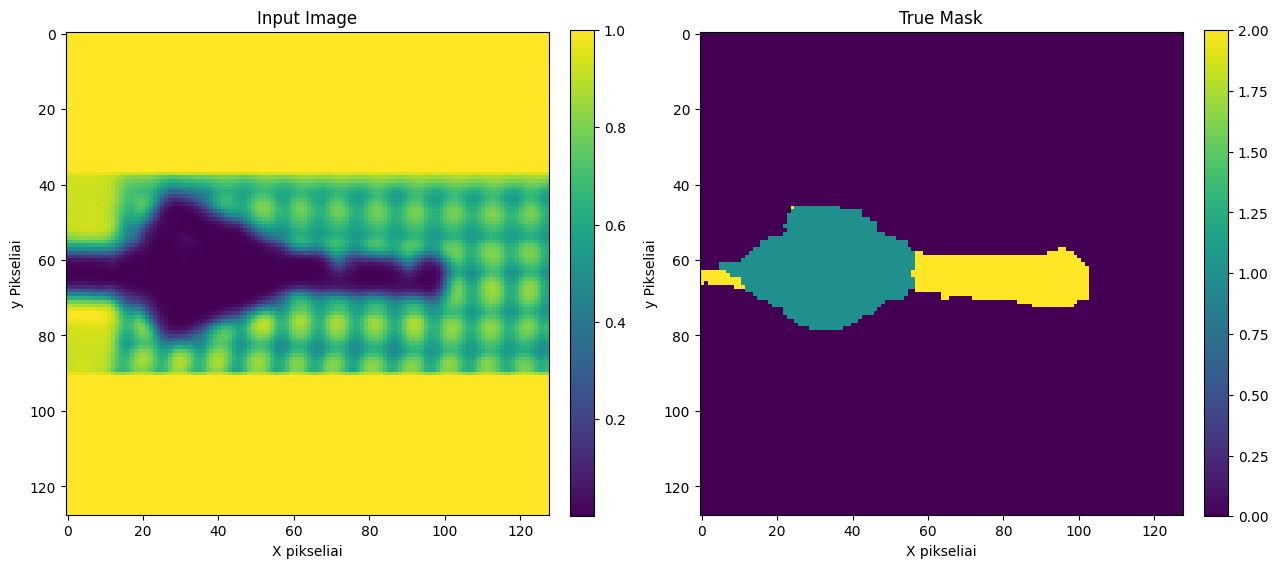

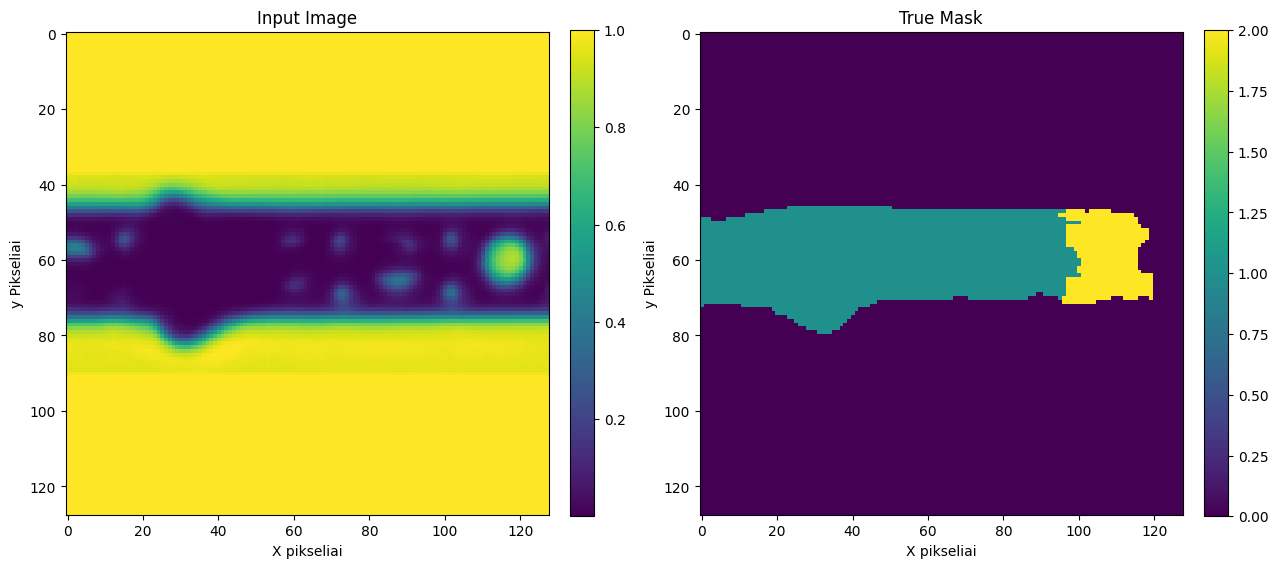

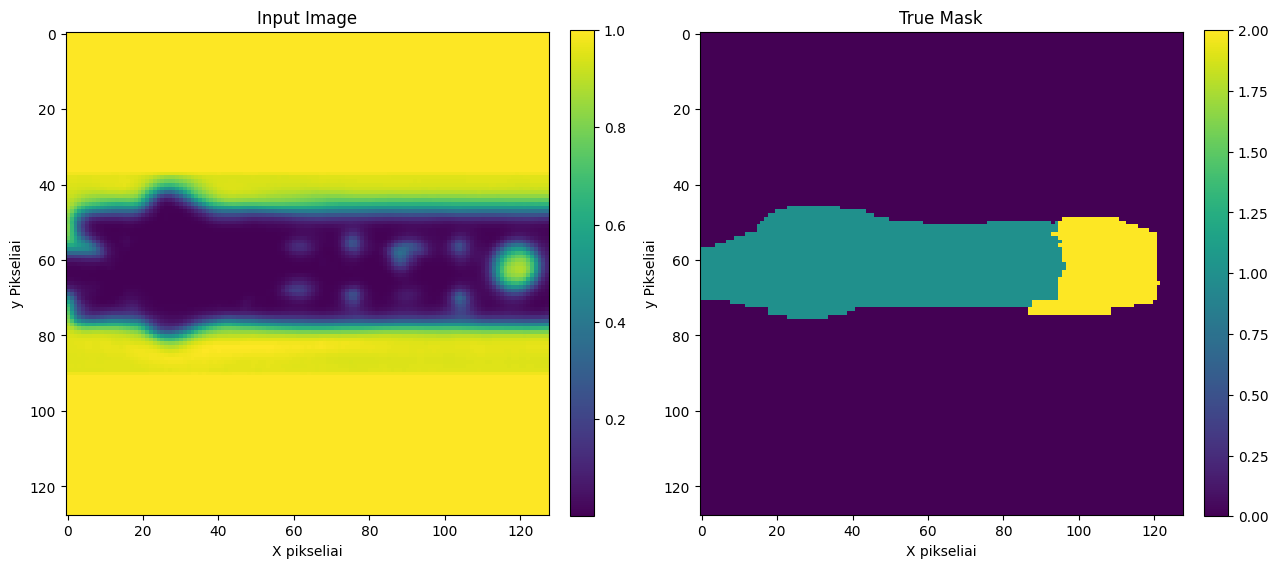

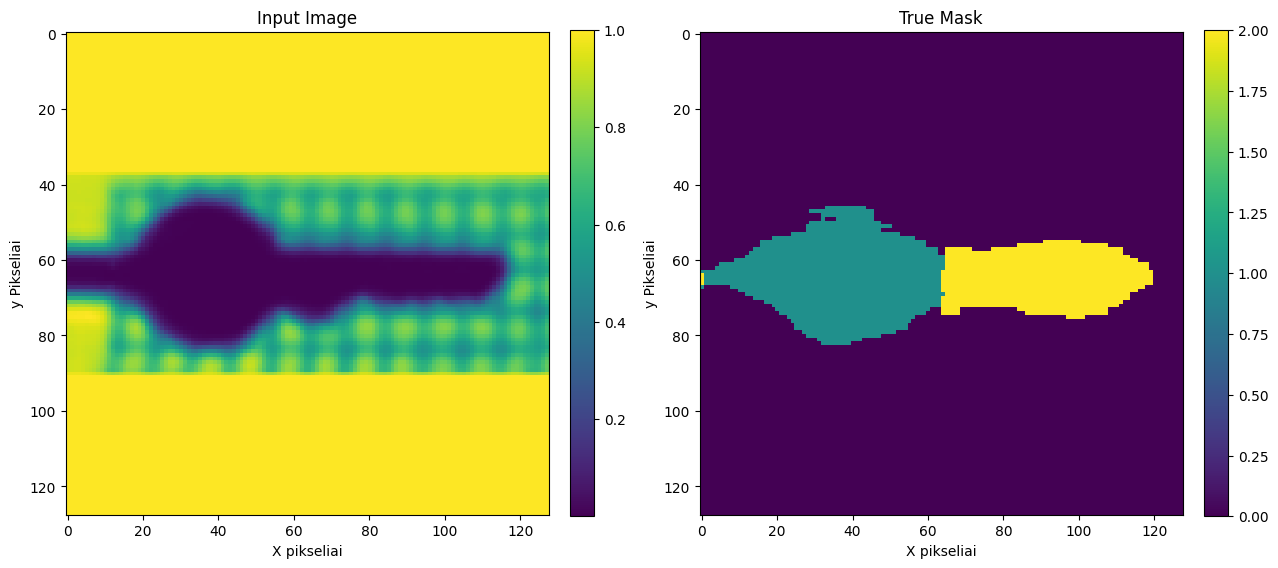

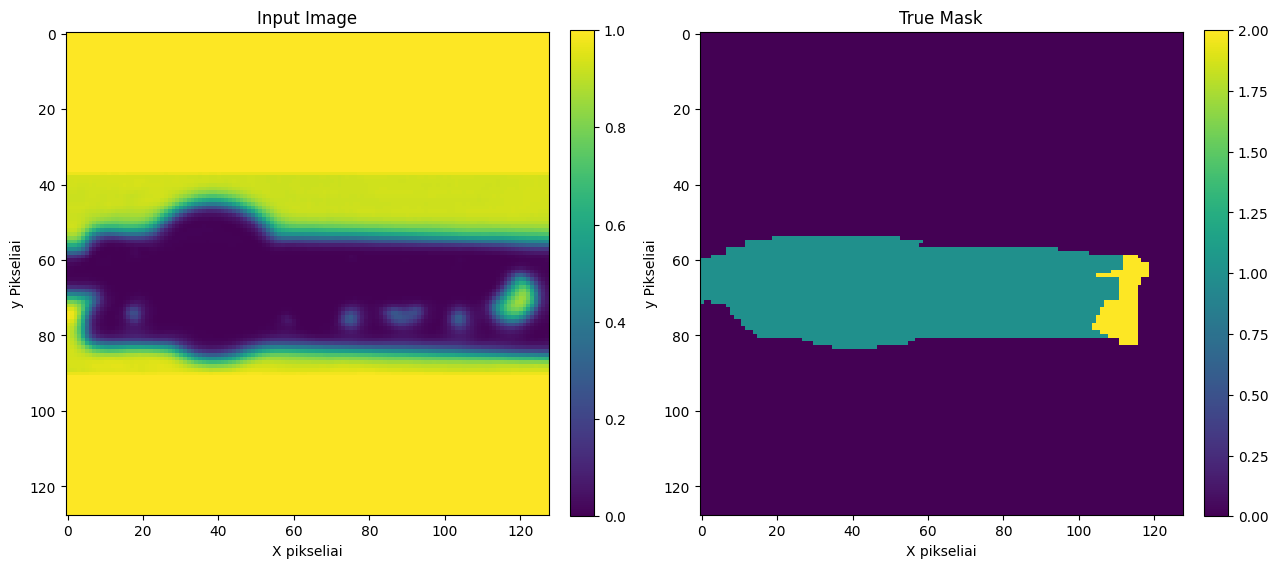

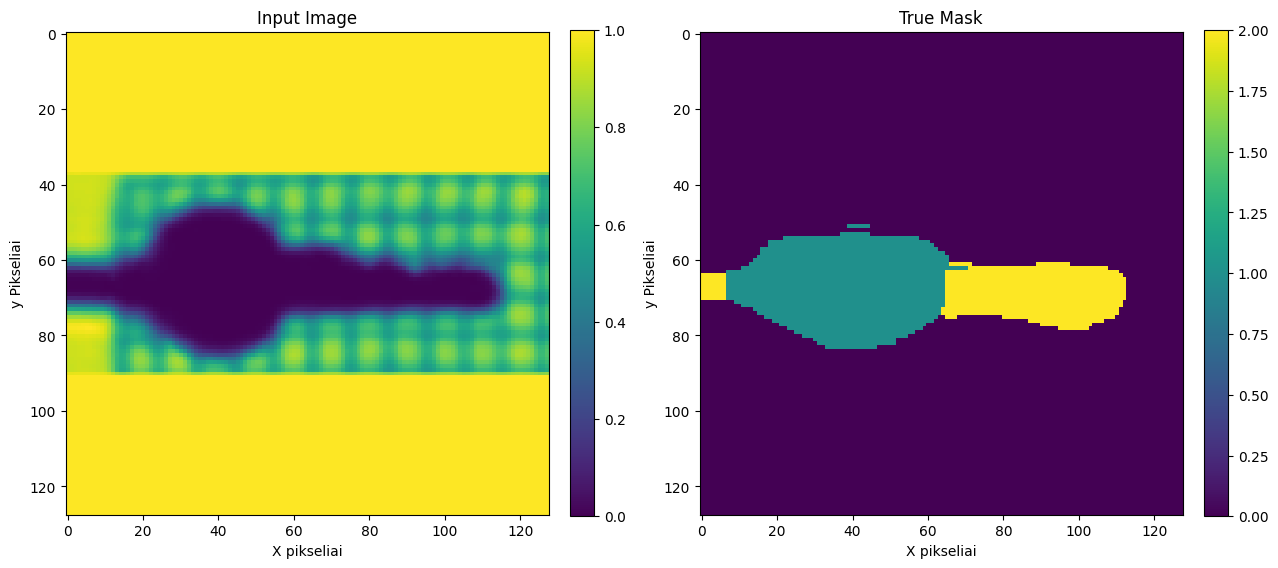

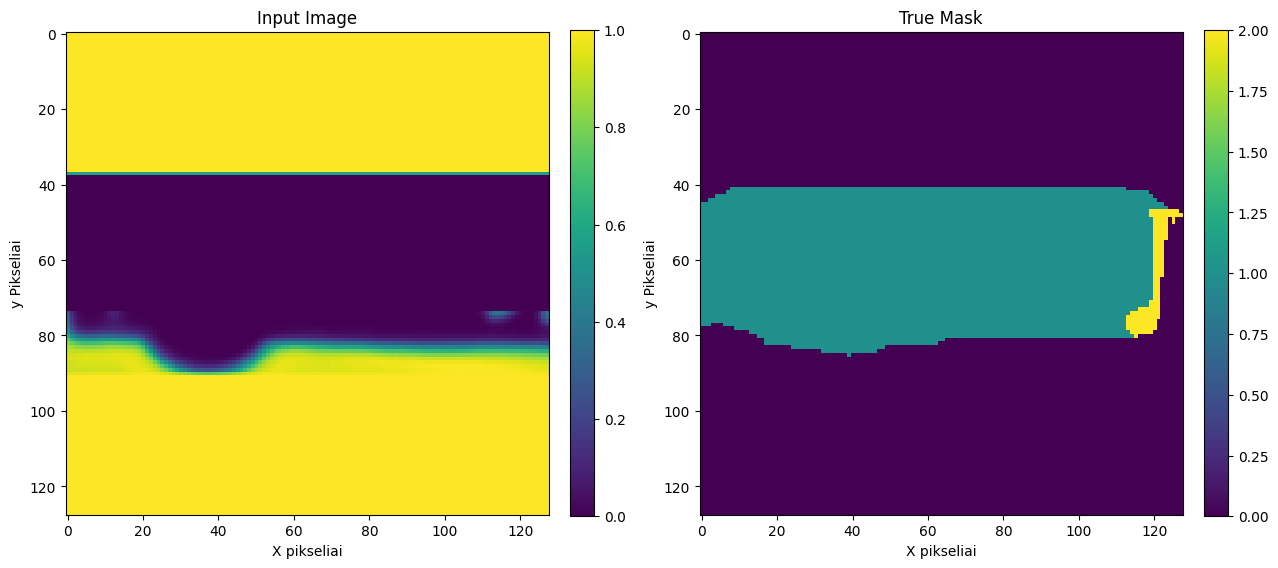

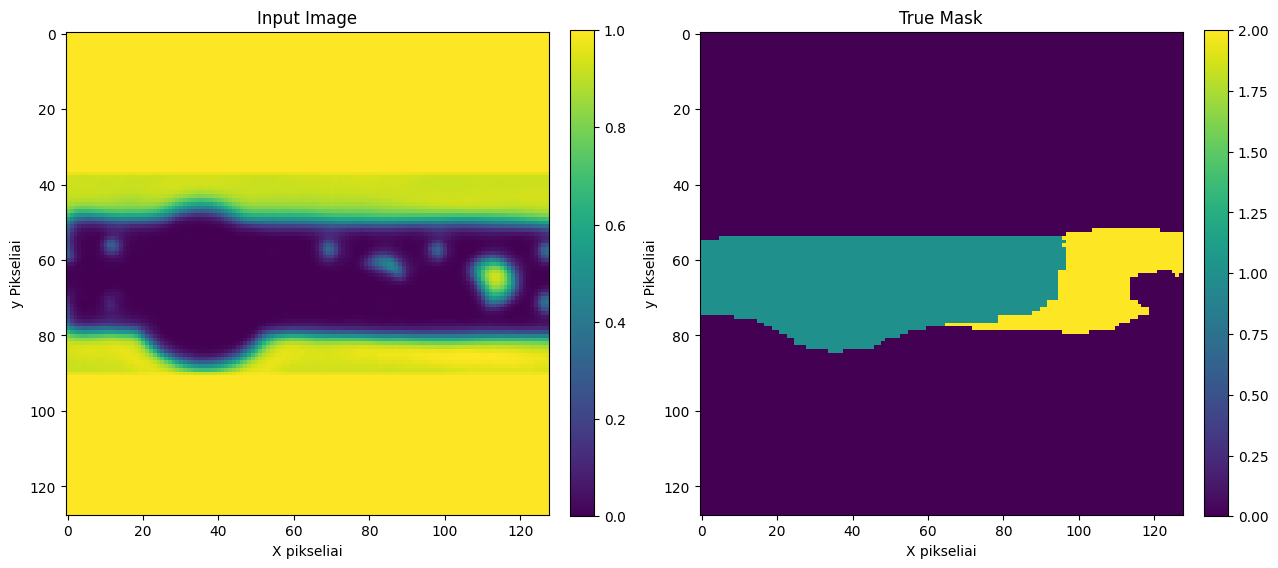

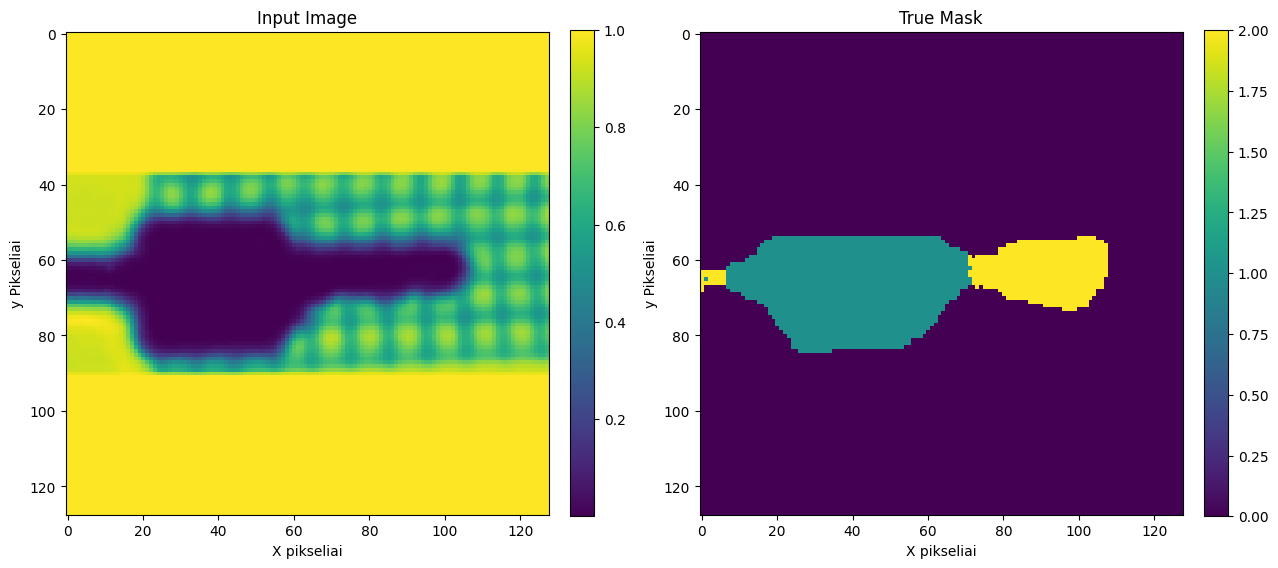

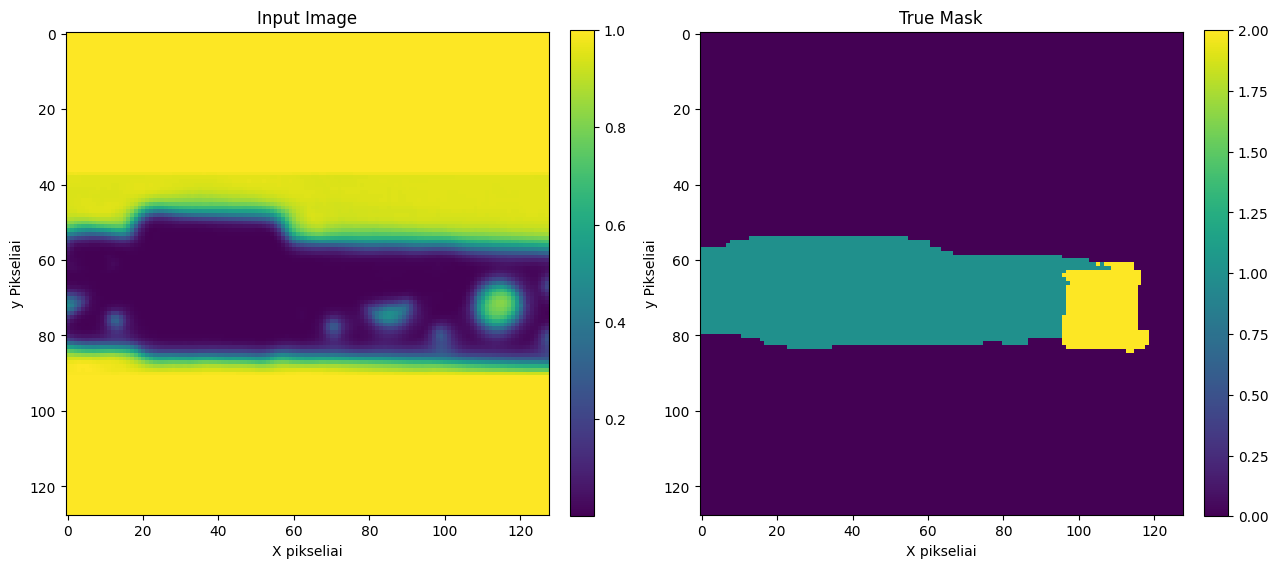

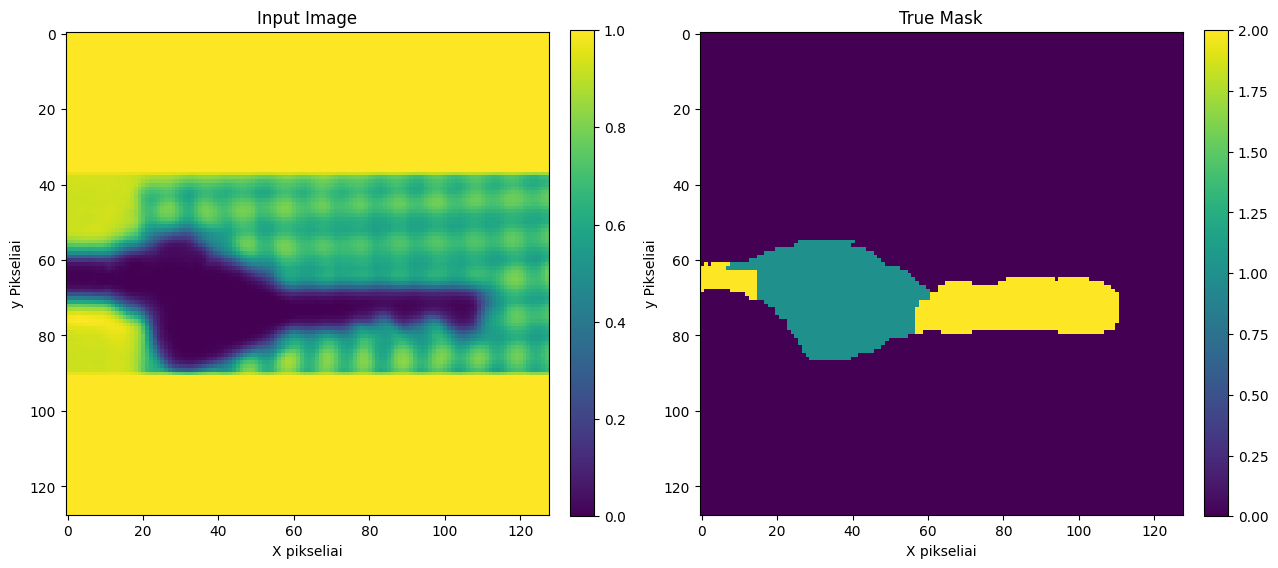

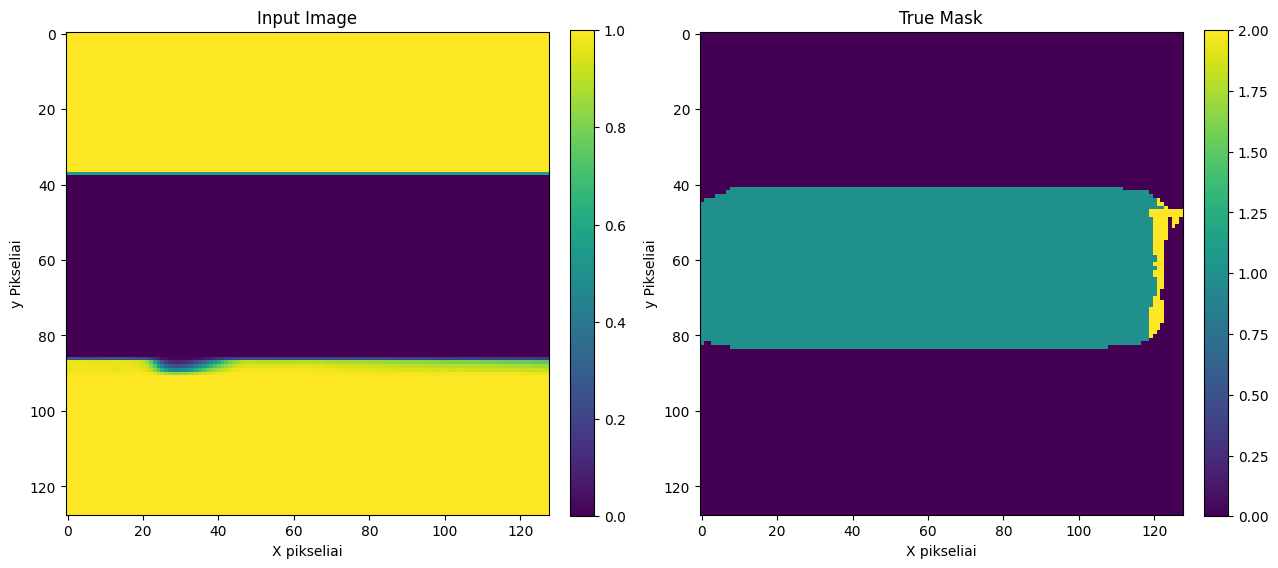

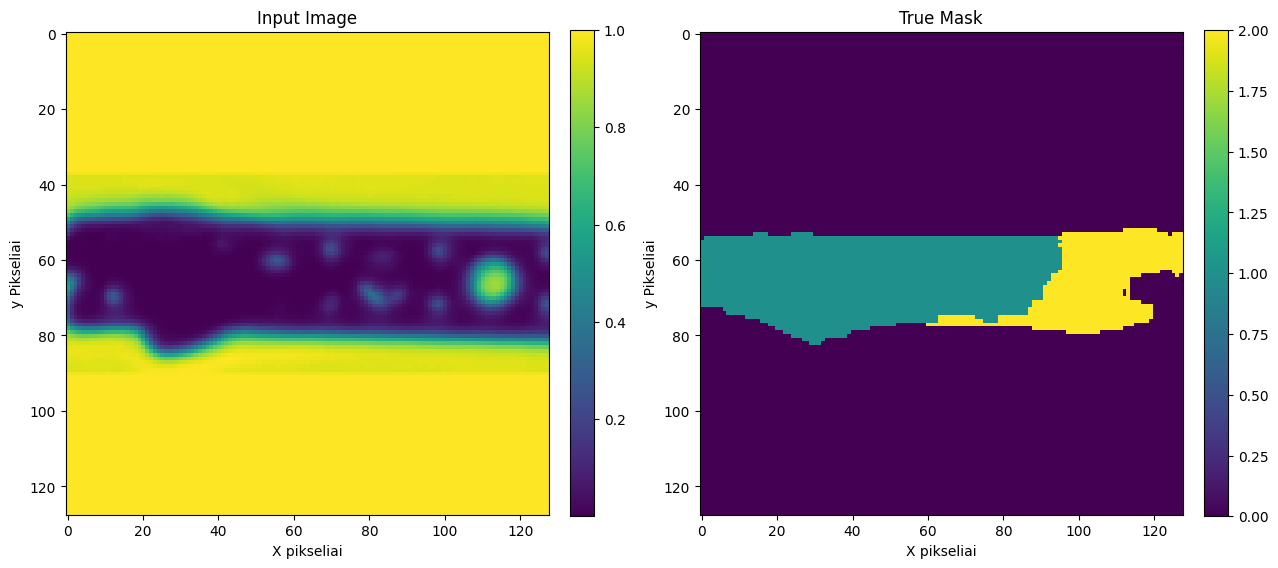

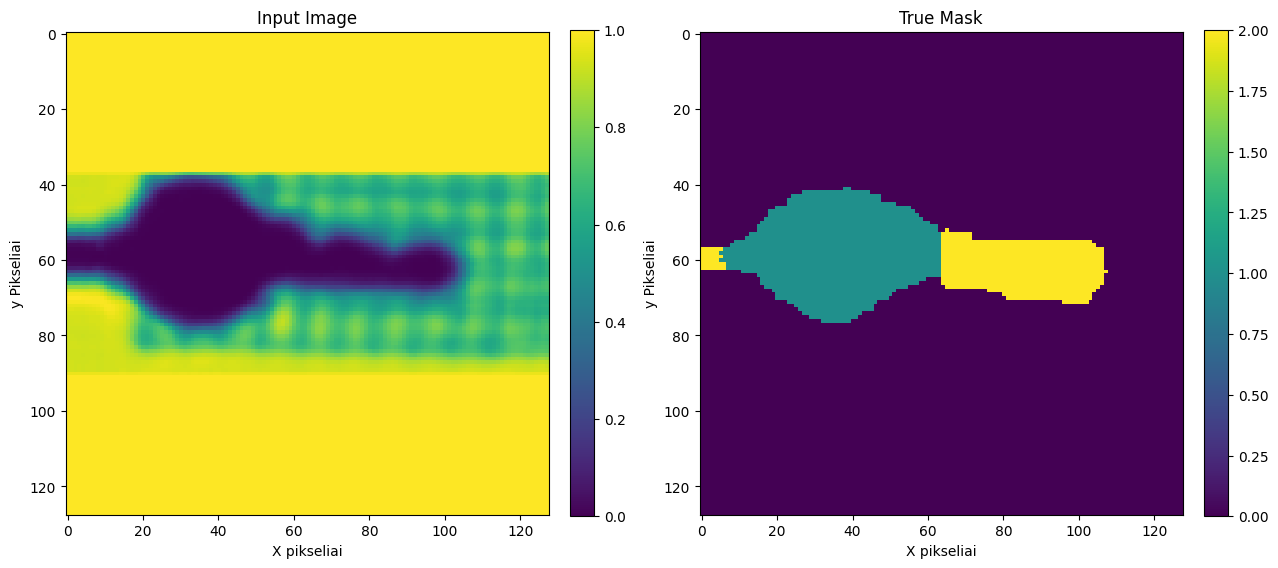

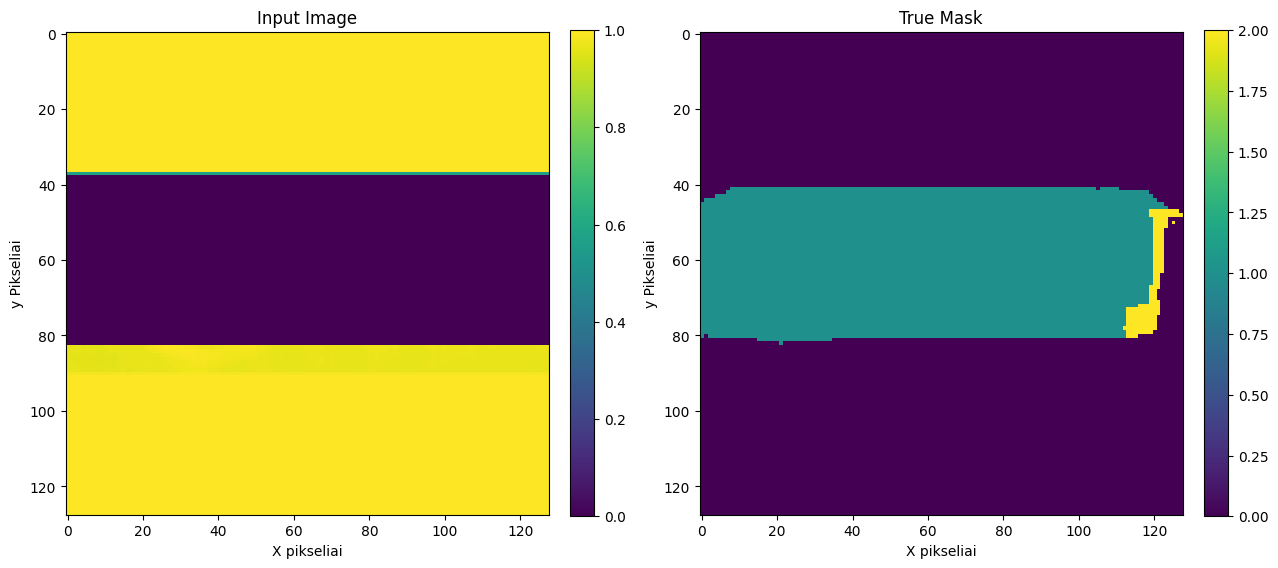

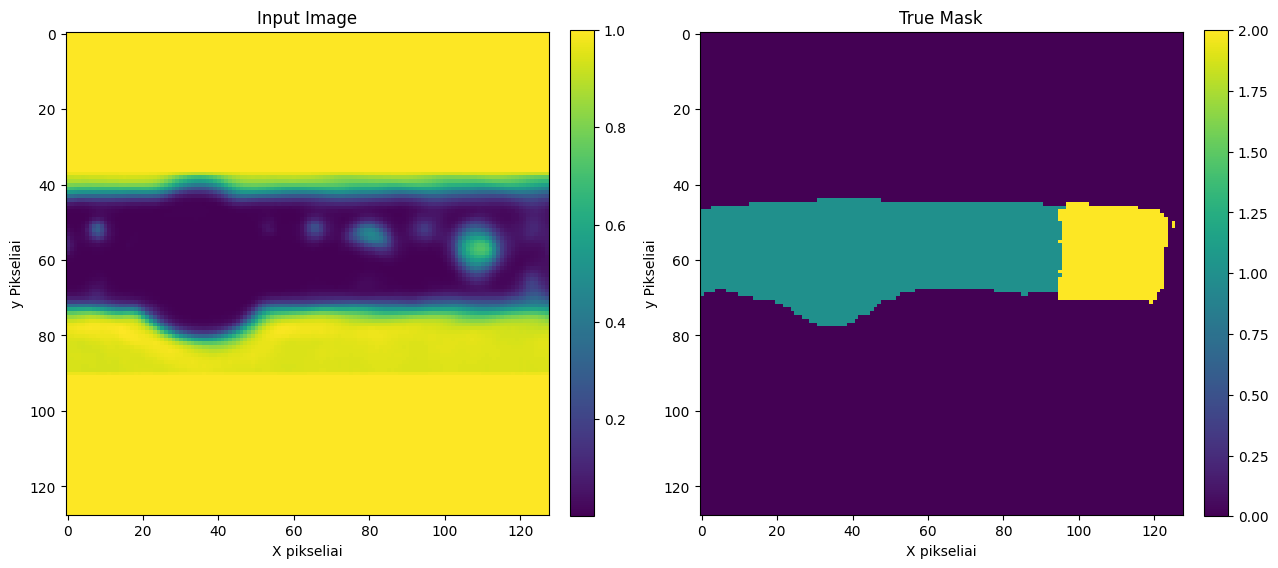

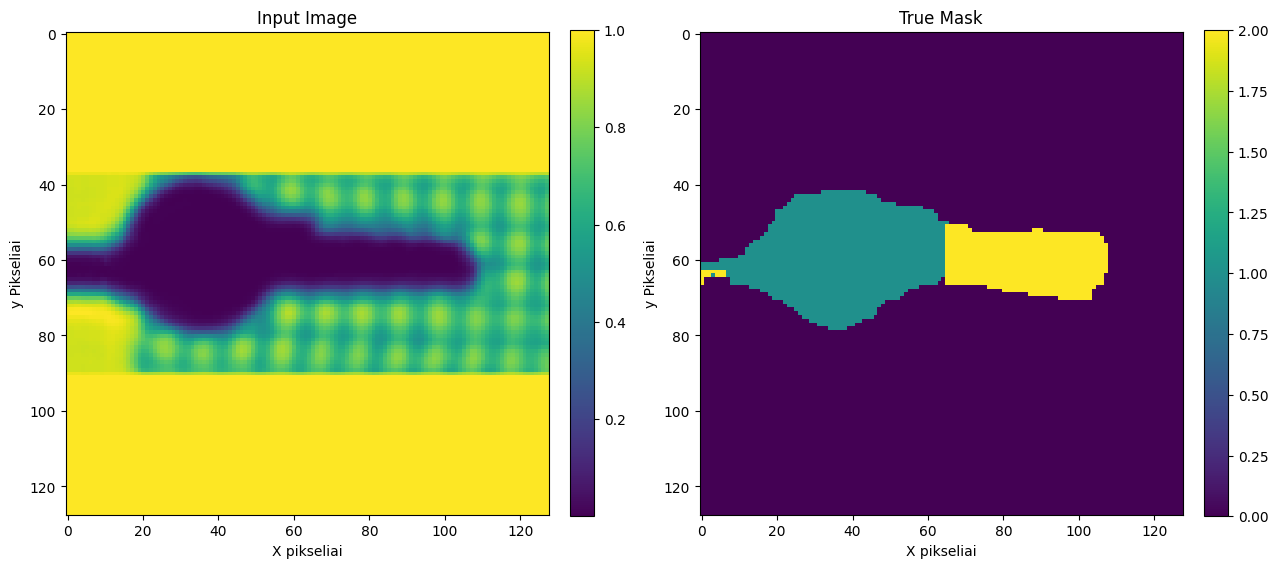

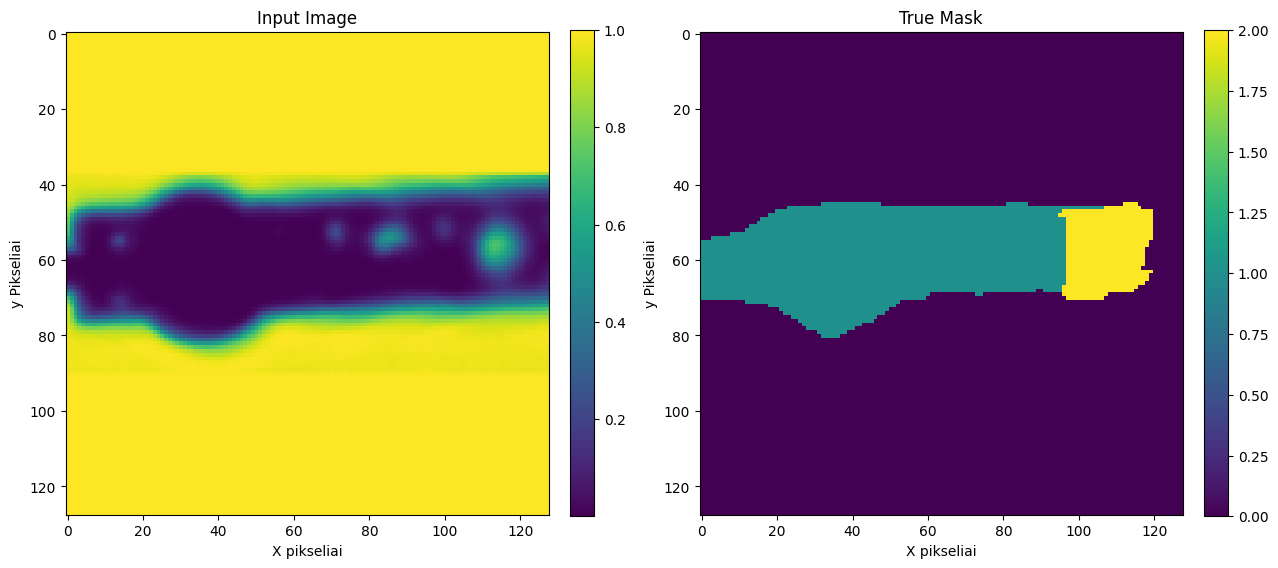

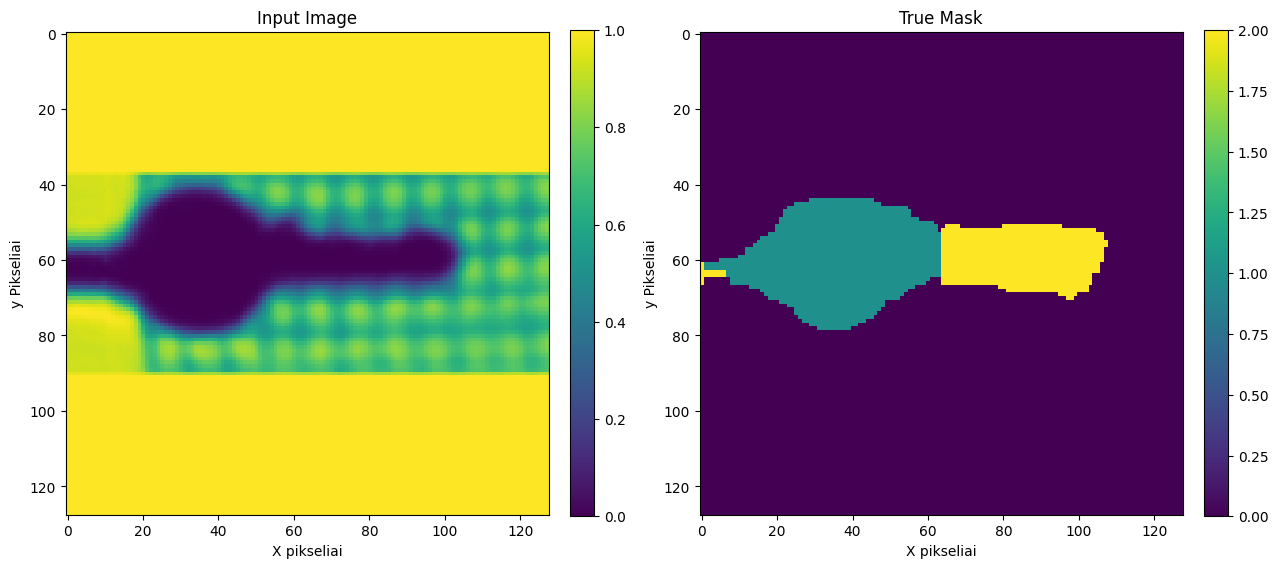

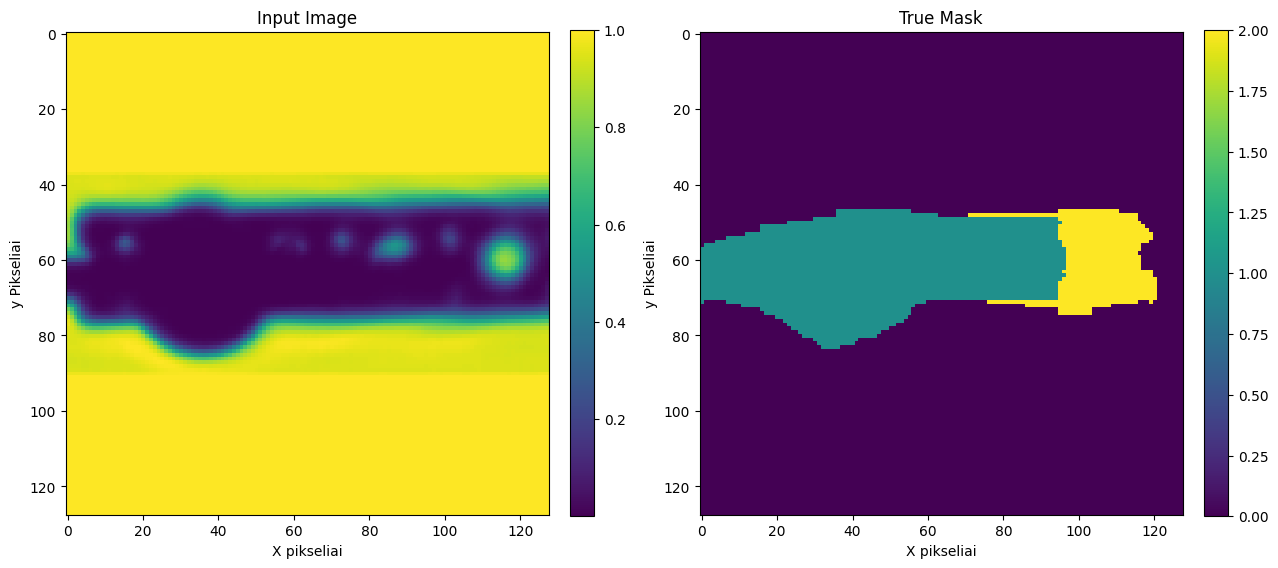

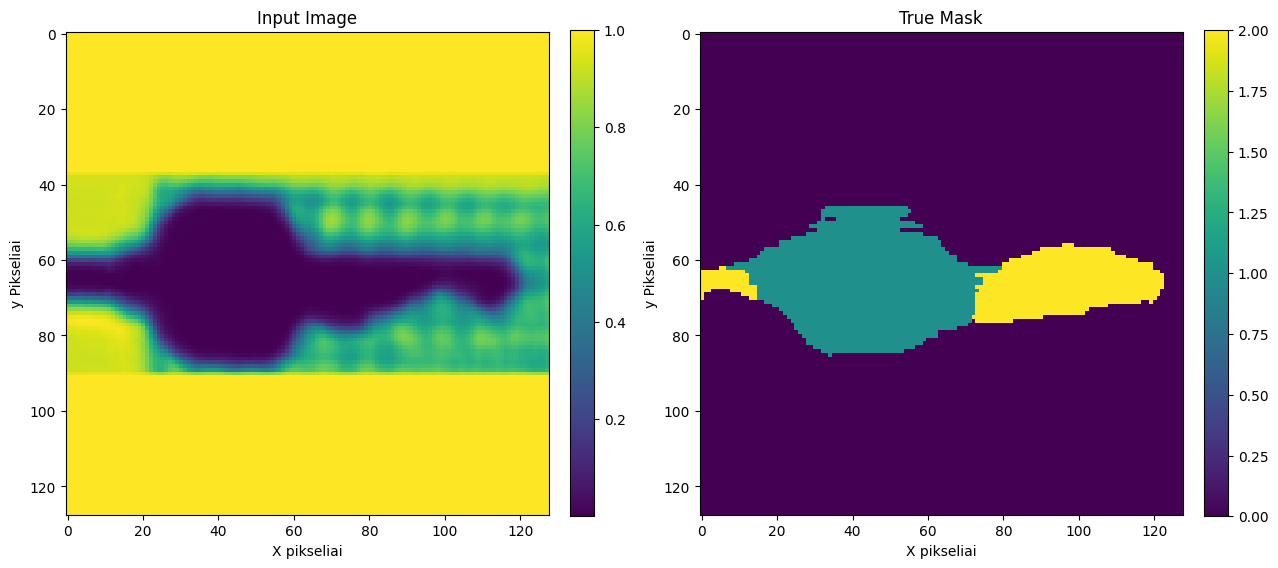

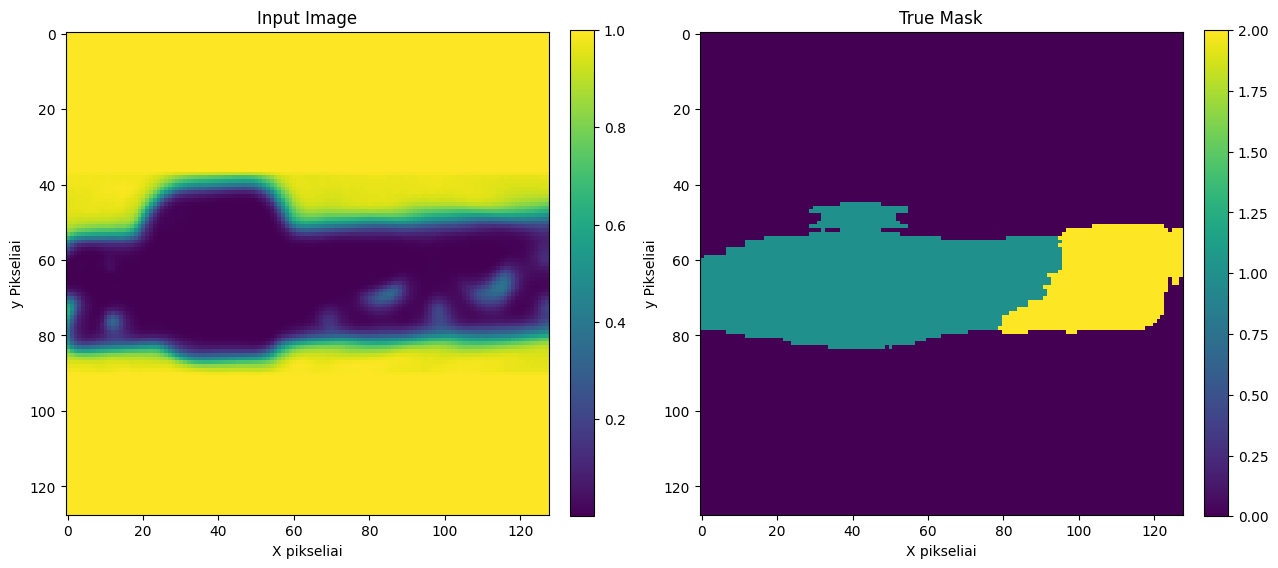

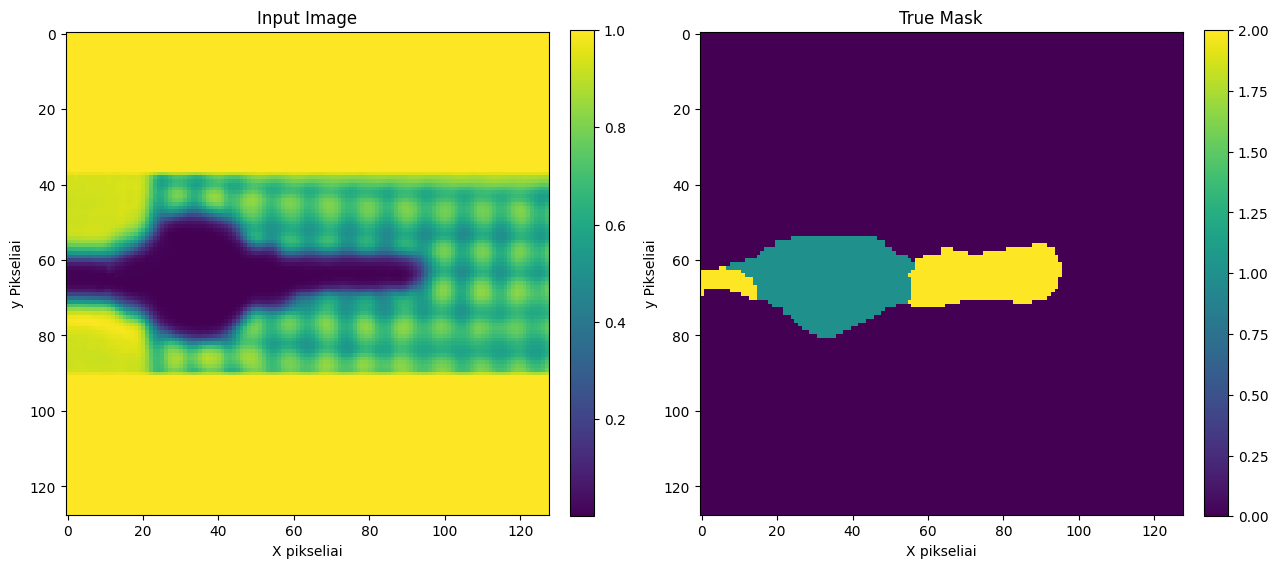

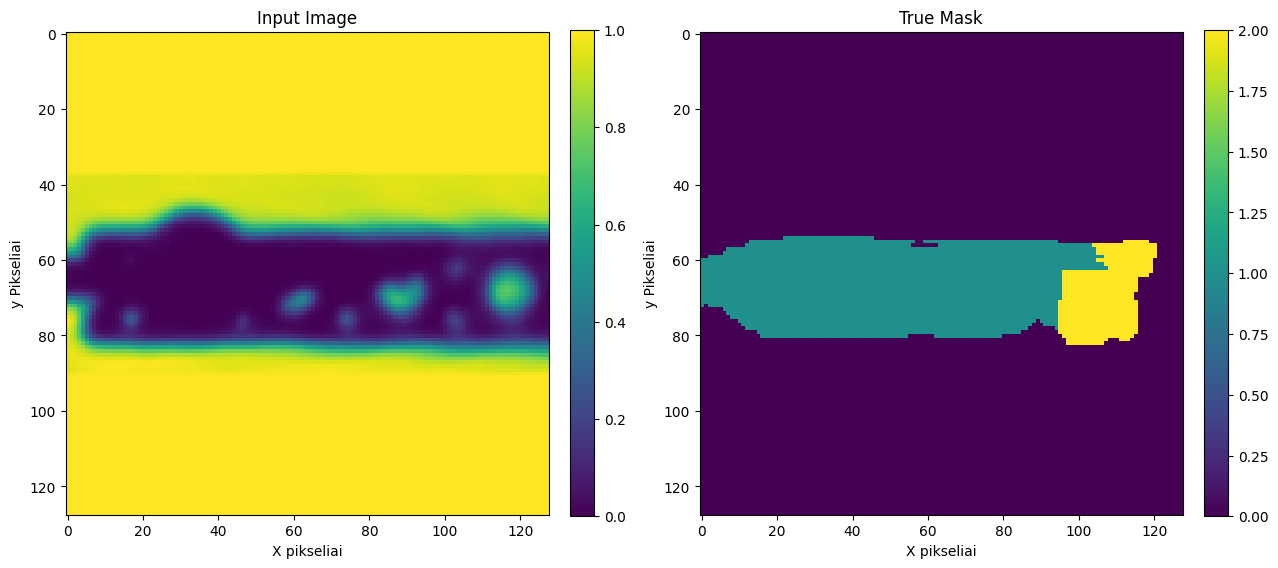

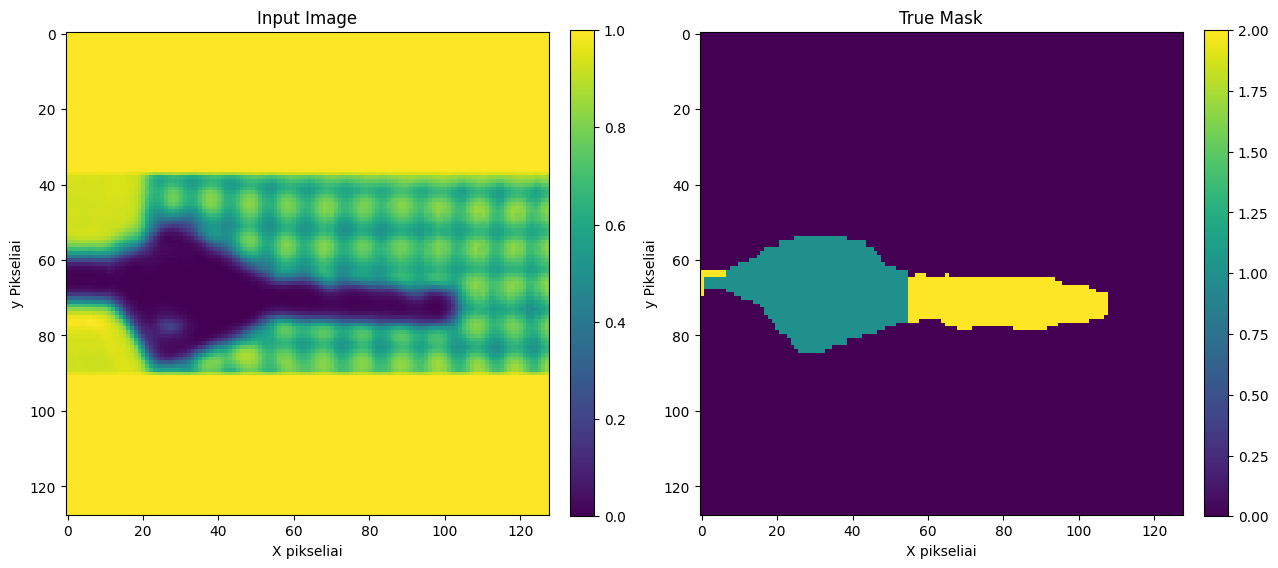

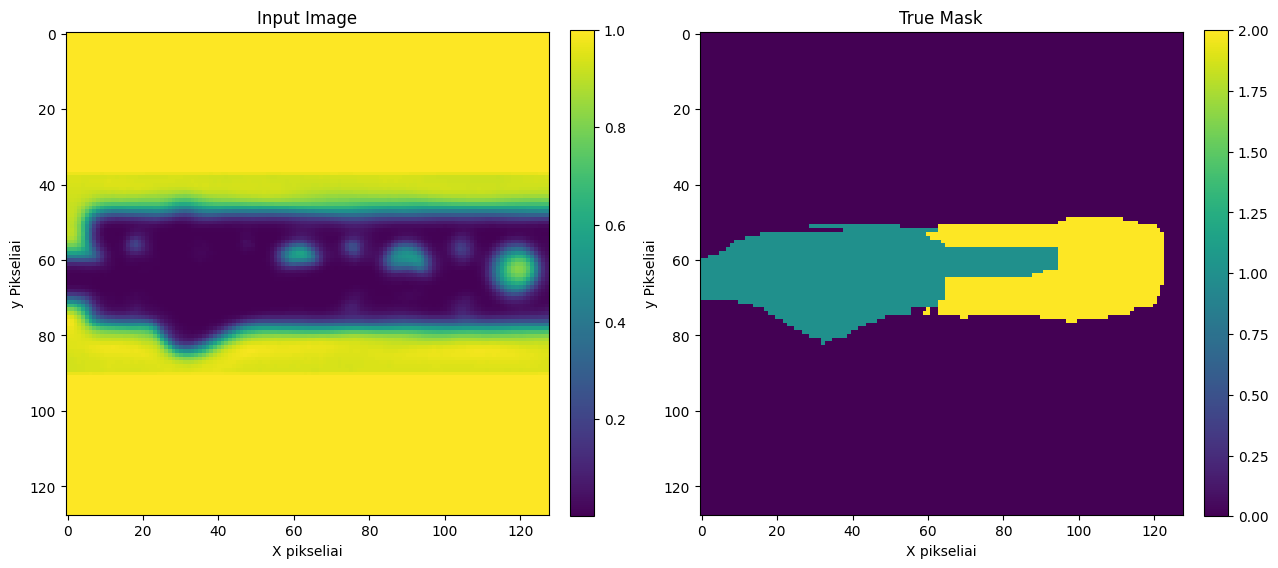

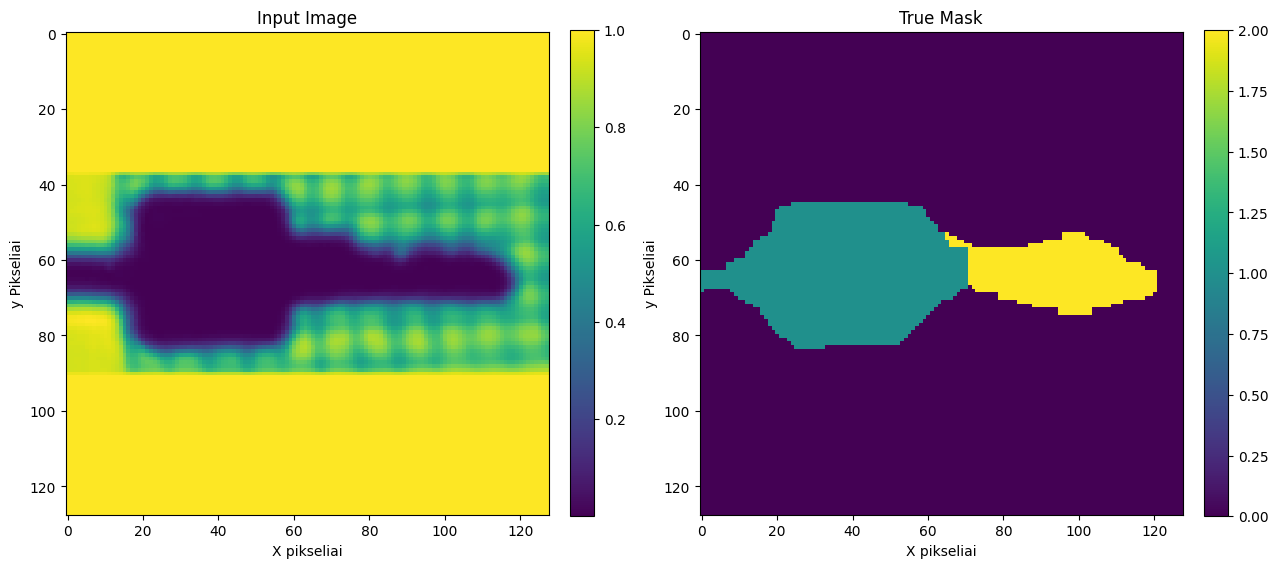

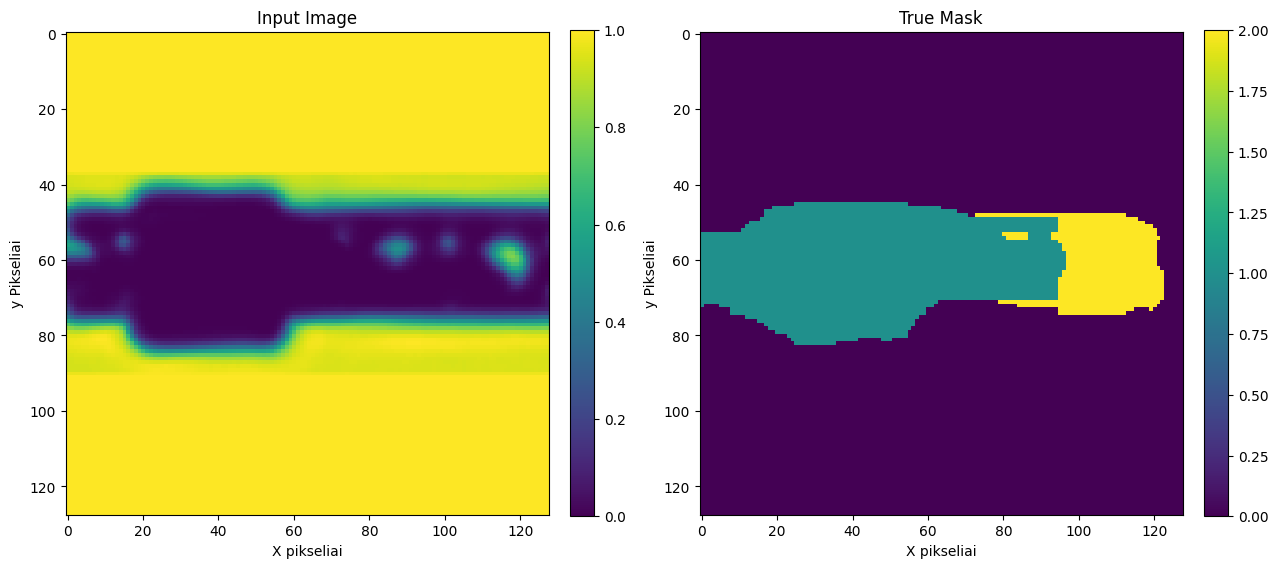

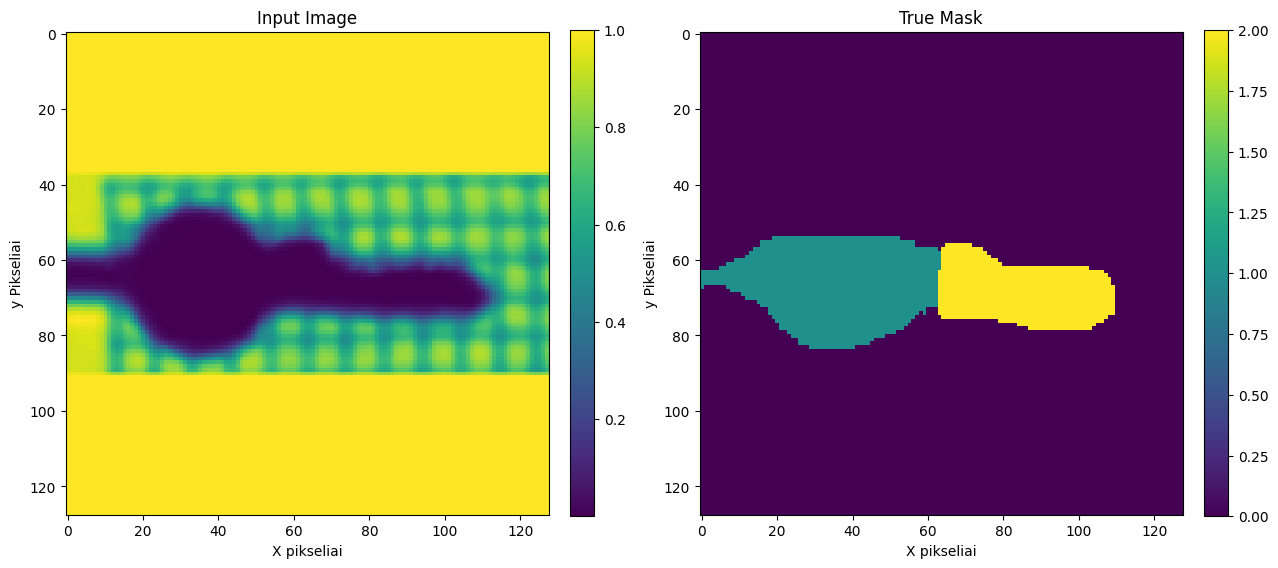

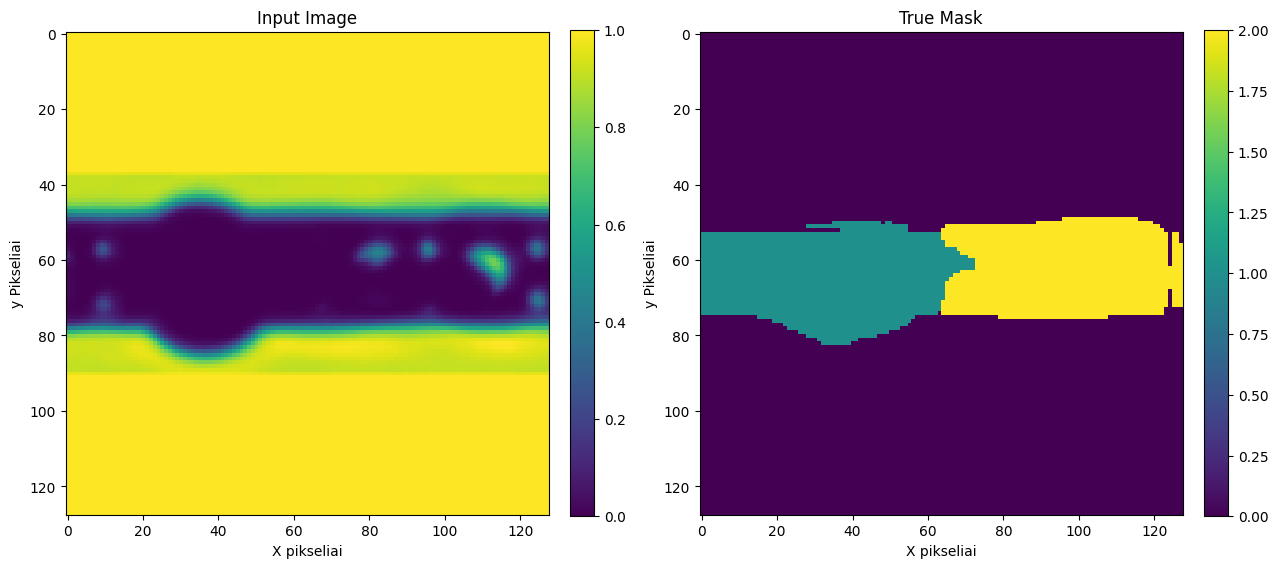

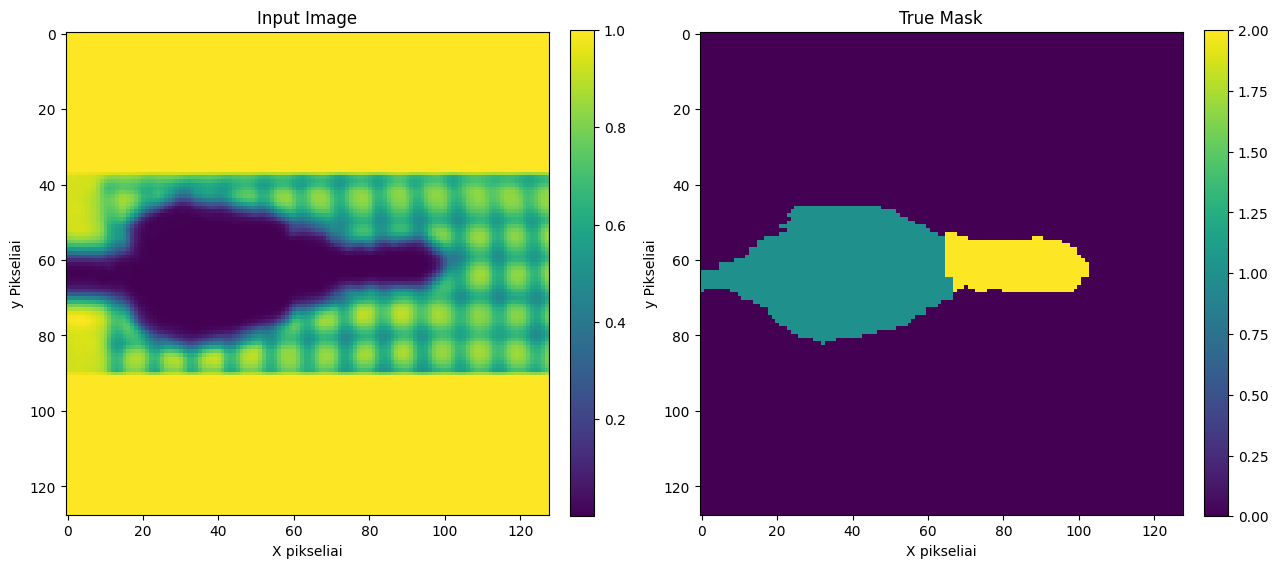

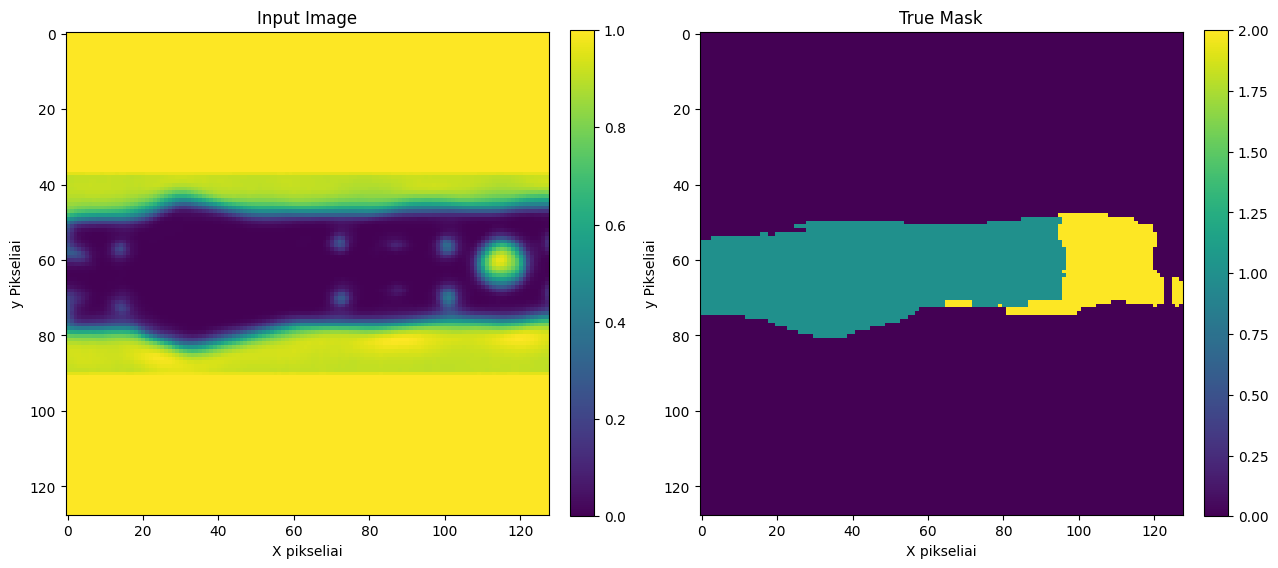

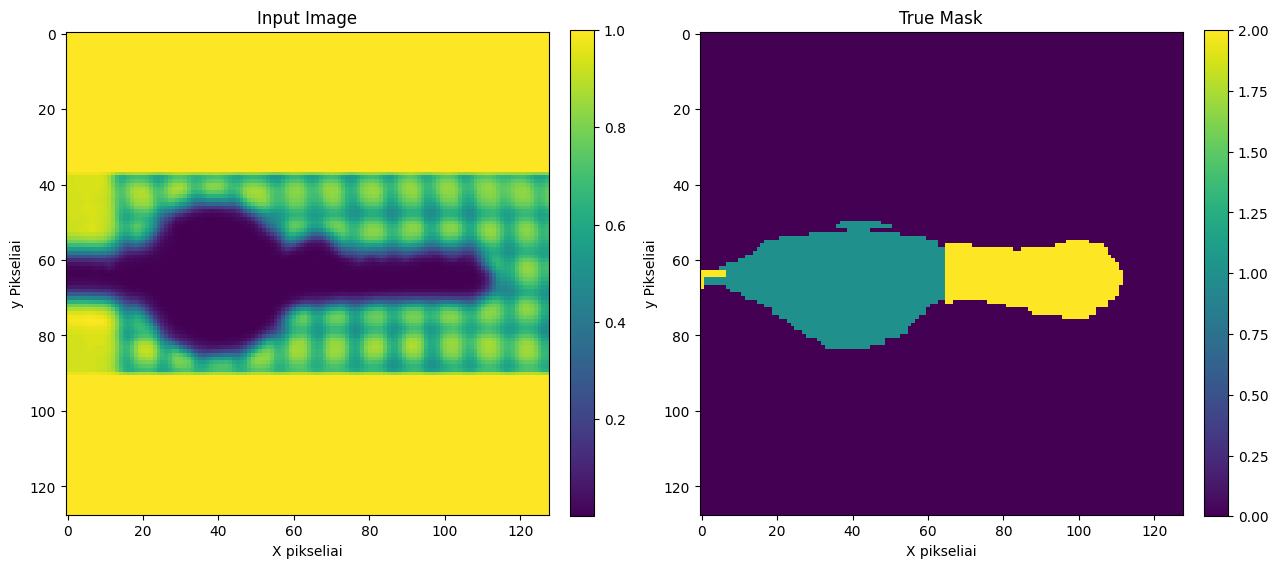

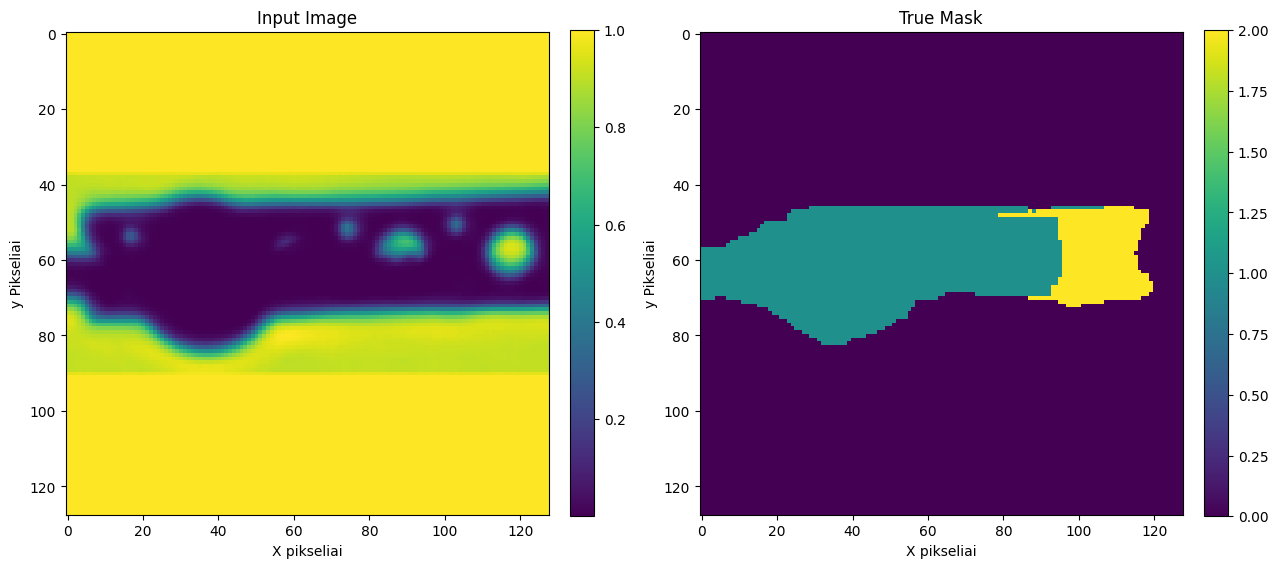

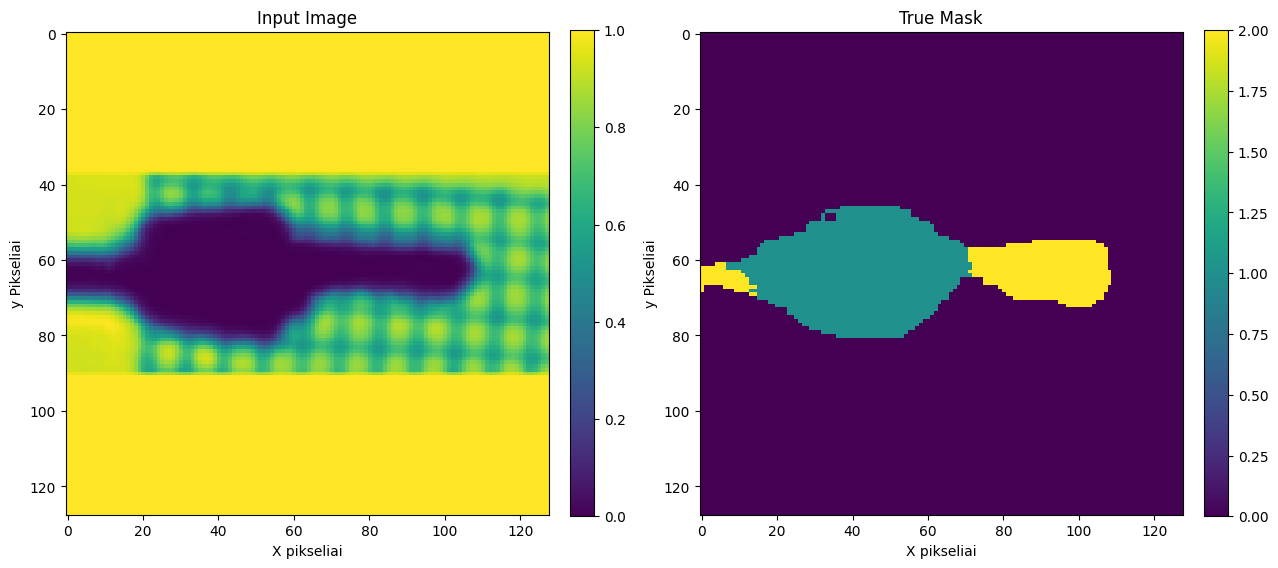

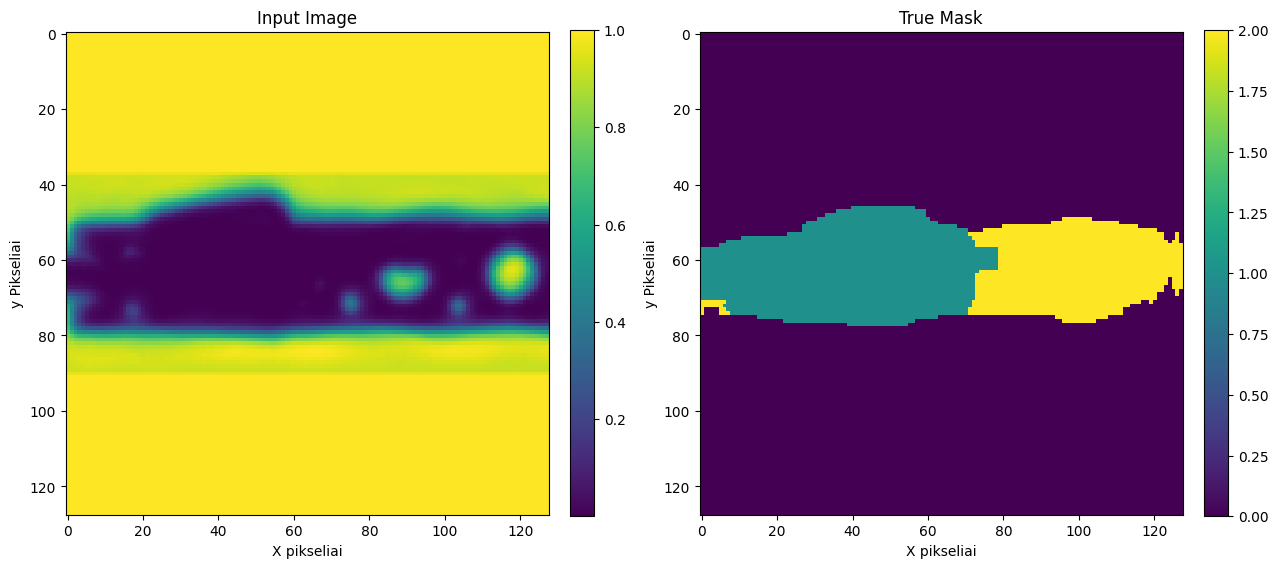

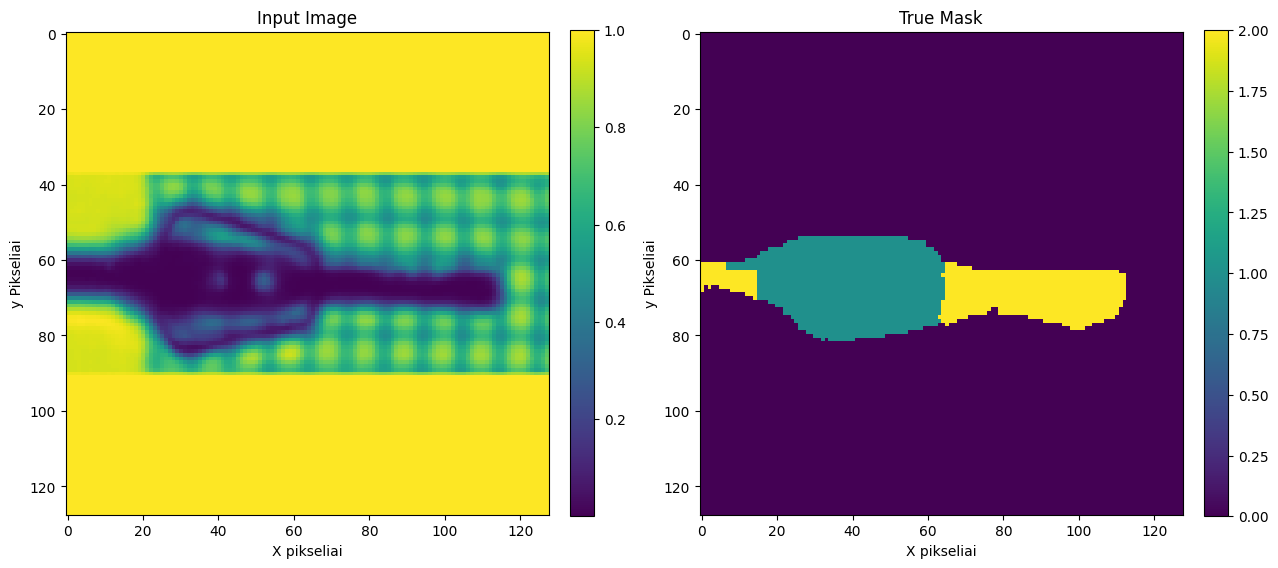

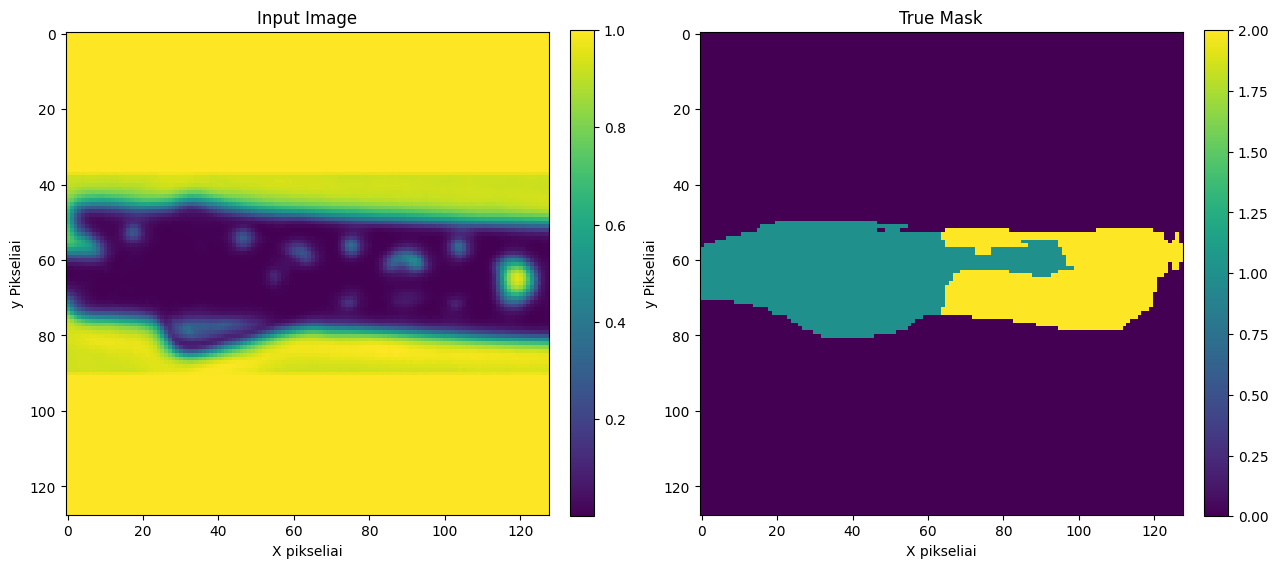

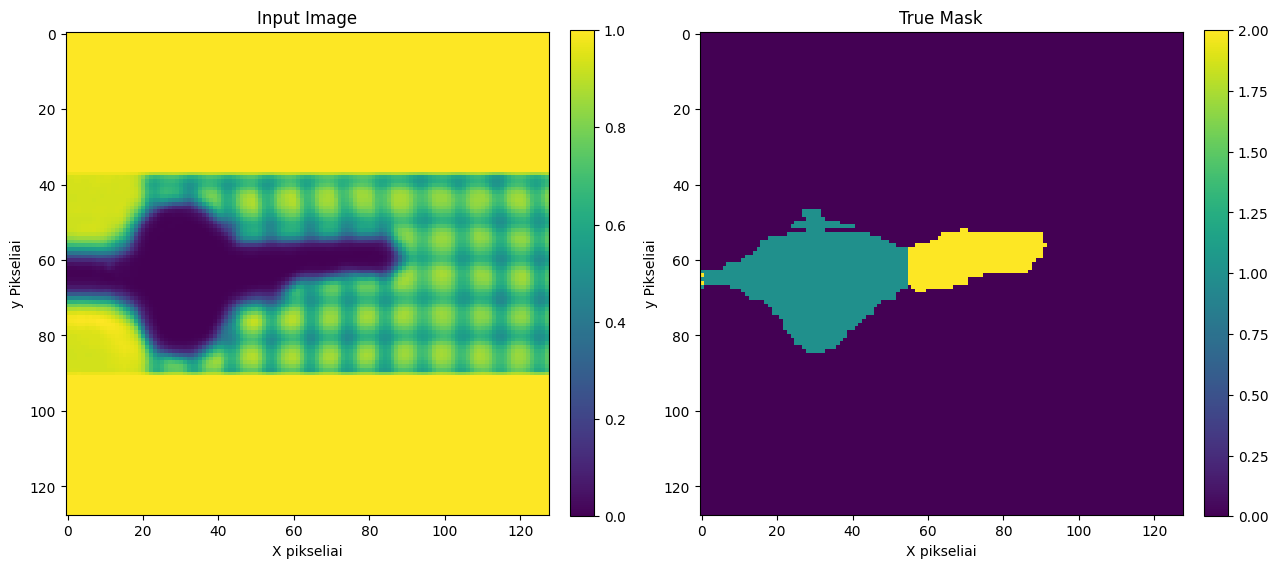

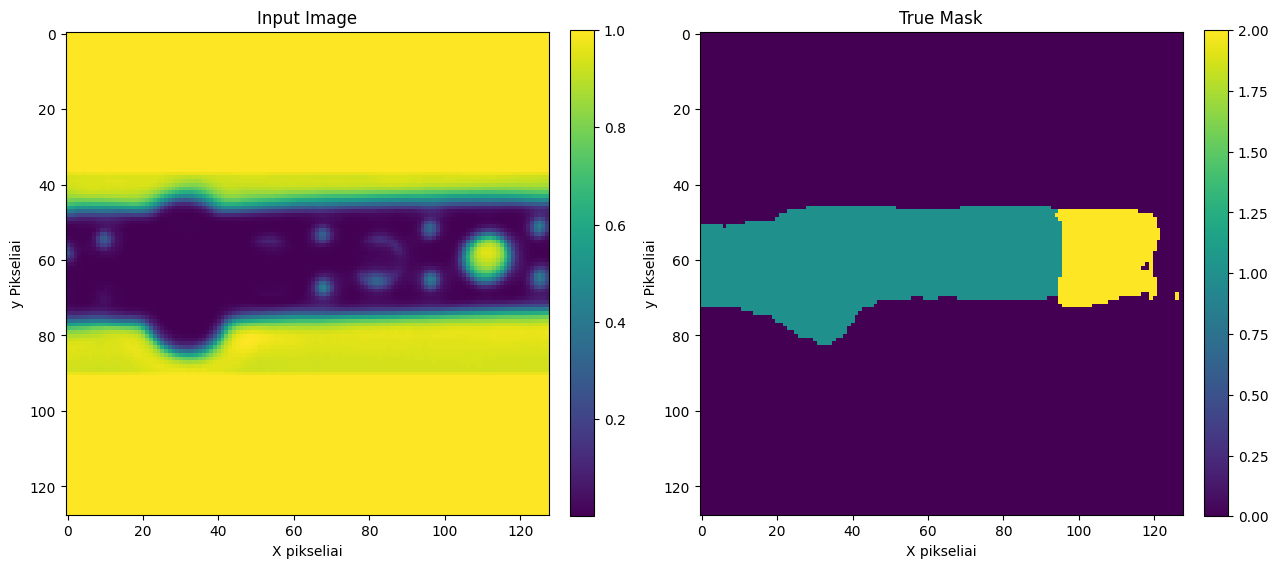

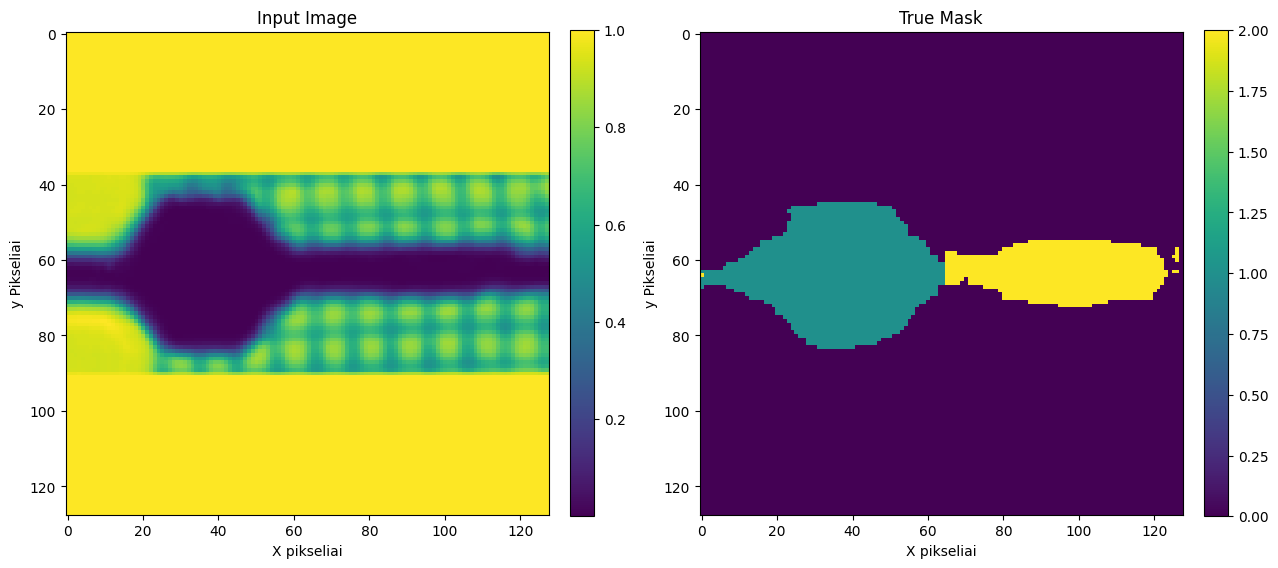

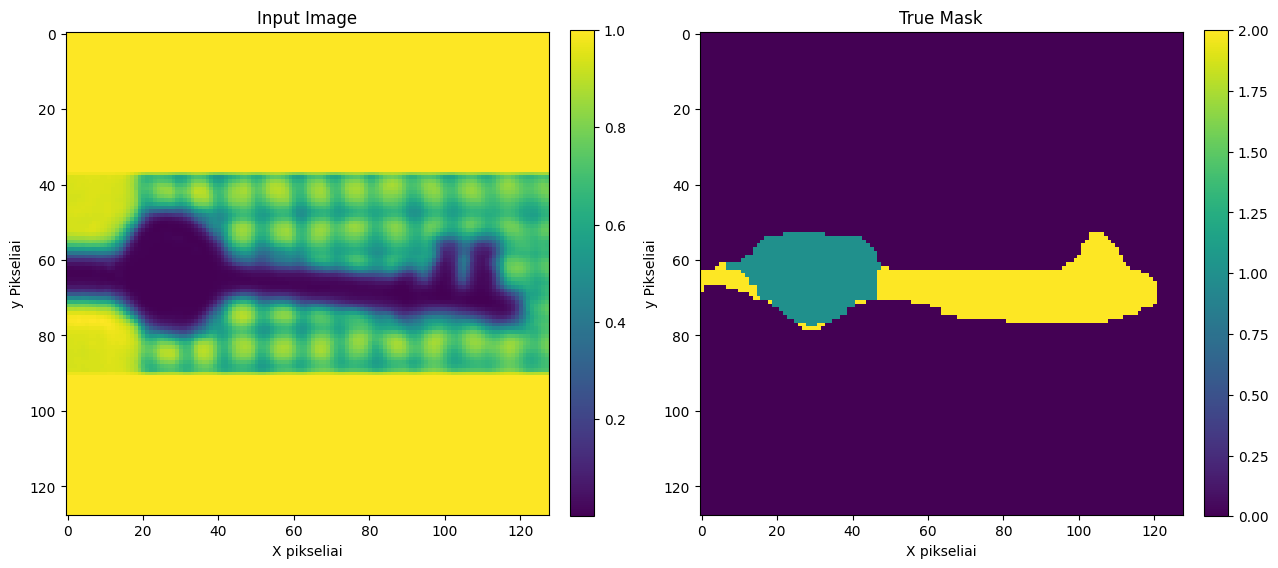

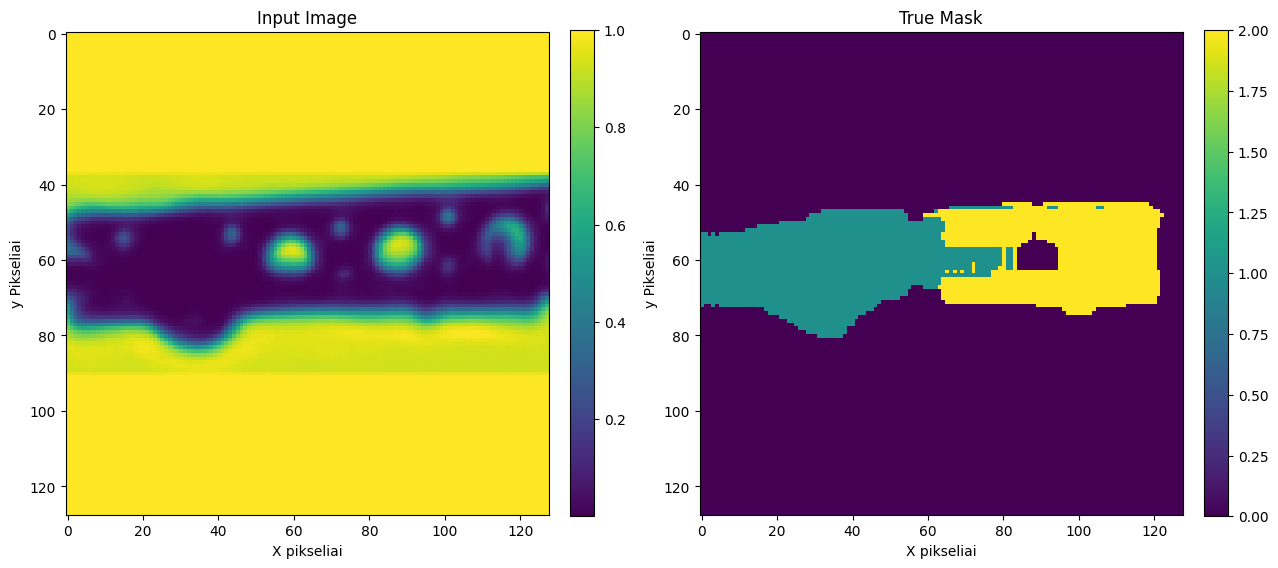

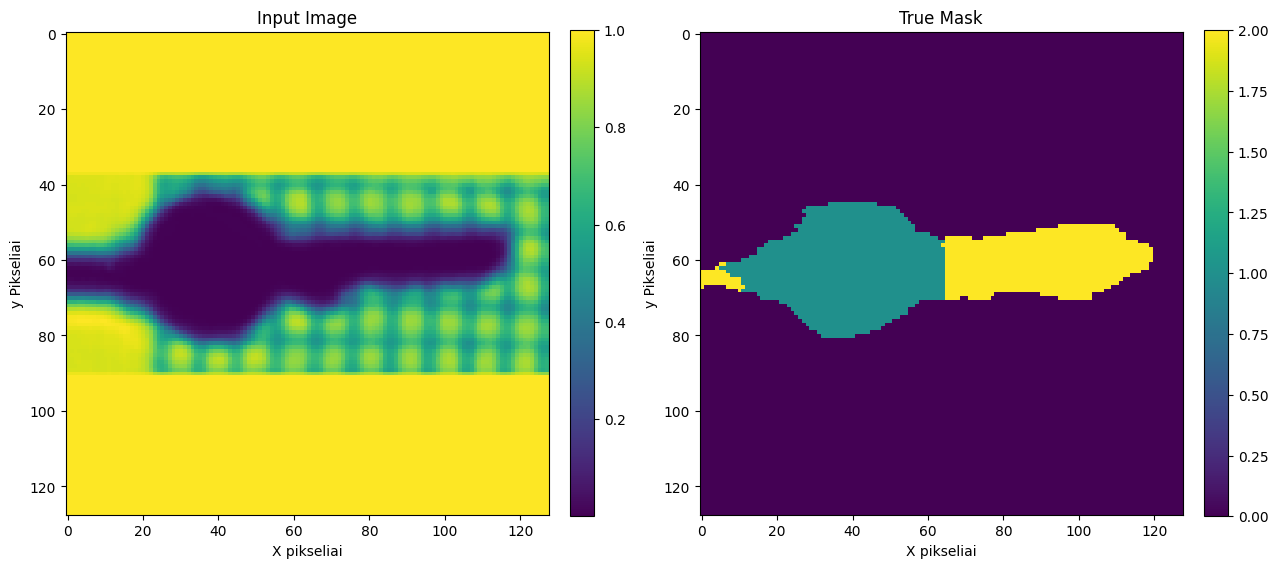

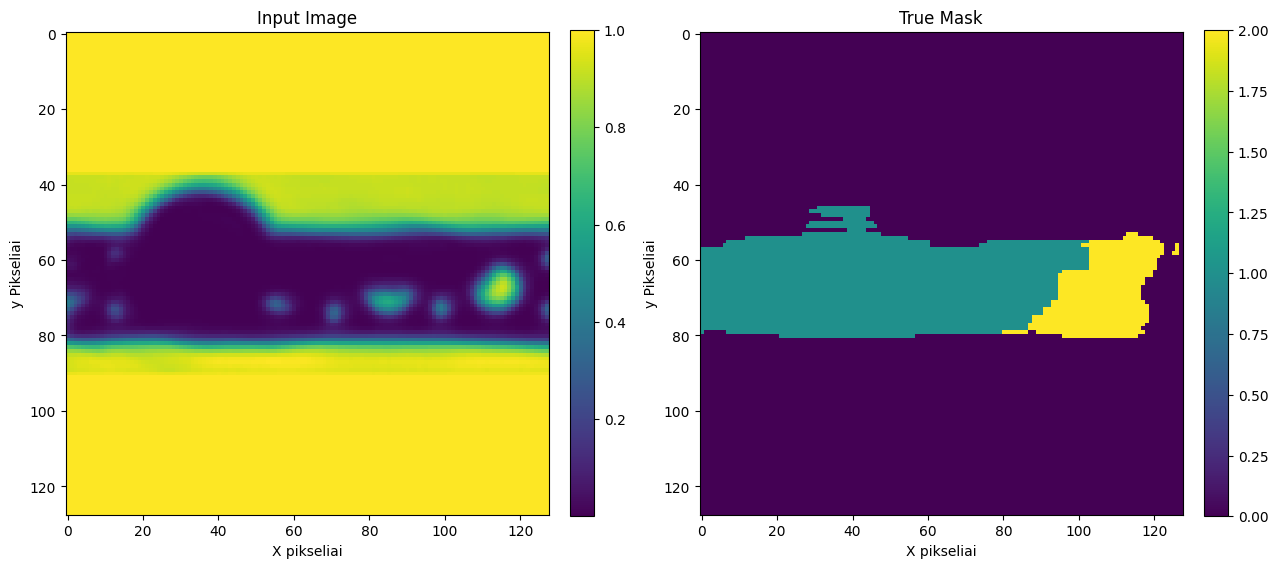

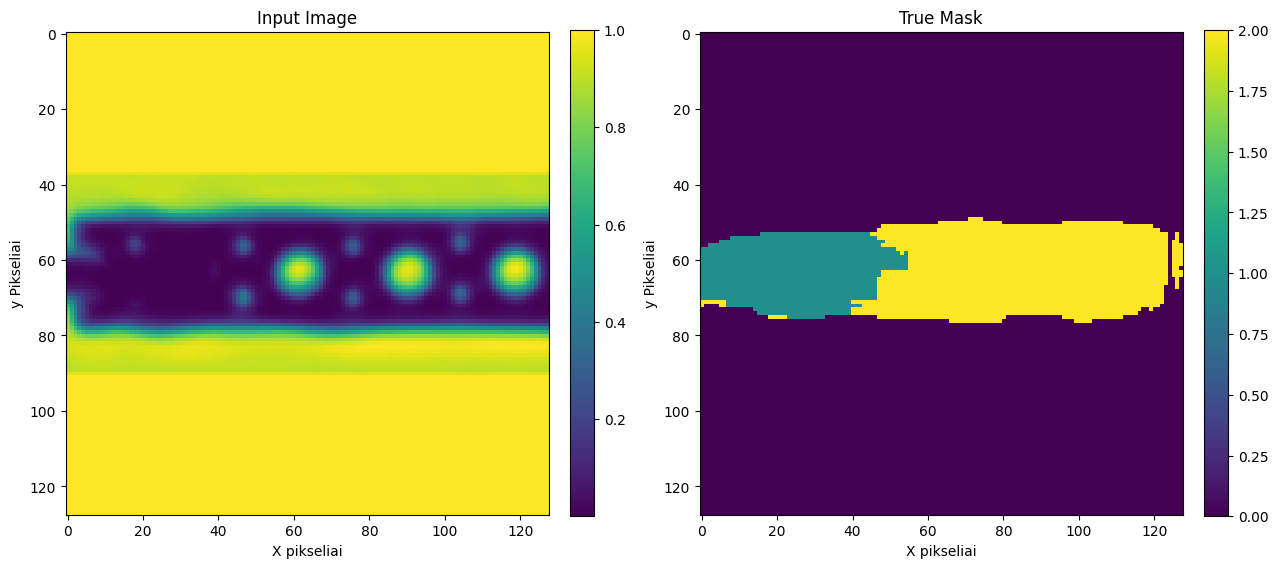

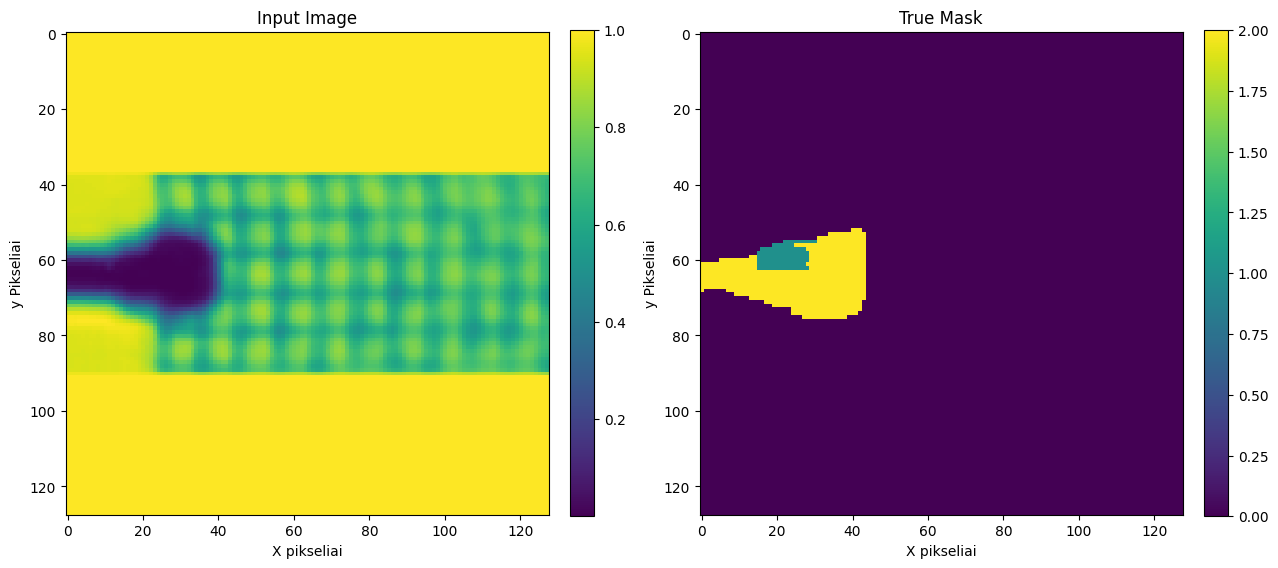

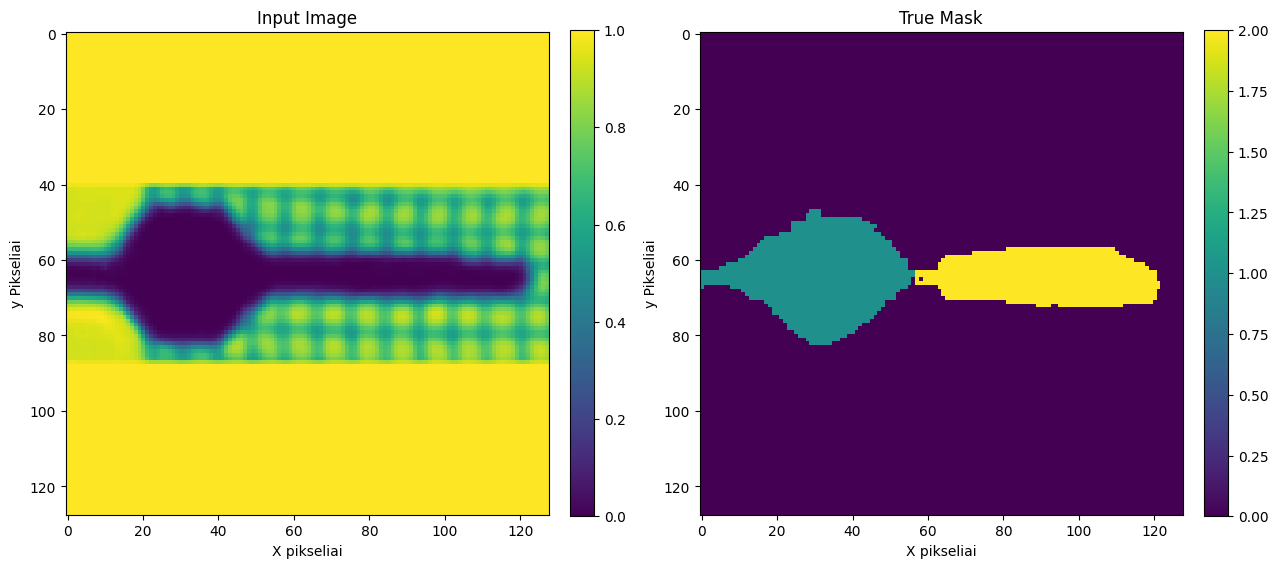

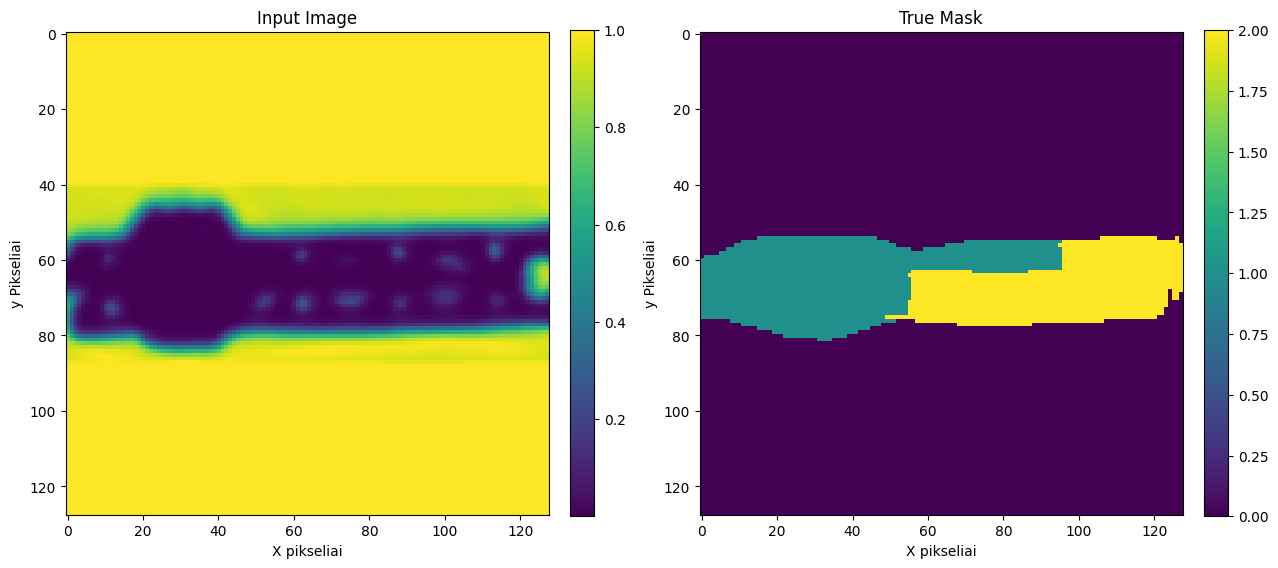

In [ ]:
for num in range(len(tinklelis)):
    display([tinklelis[num], create_mask(tinkl_preds[num])])
    print(num, end="\r")
    os.system('cls' if os.name == 'nt' else 'clear')

In [ ]:
test_data = np.load('/content/gdrive/My Drive/My stupid projects/Hatsune_Miku/segmentation/test_trash_array.npy')

for i in range (len(test_data)):
    max_val = test_data[i].max()
    if max_val > 0:
        test_data[i] = test_data[i] / max_val

test_data = np.expand_dims(test_data, axis=-1)

test_data_pred = model.predict(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


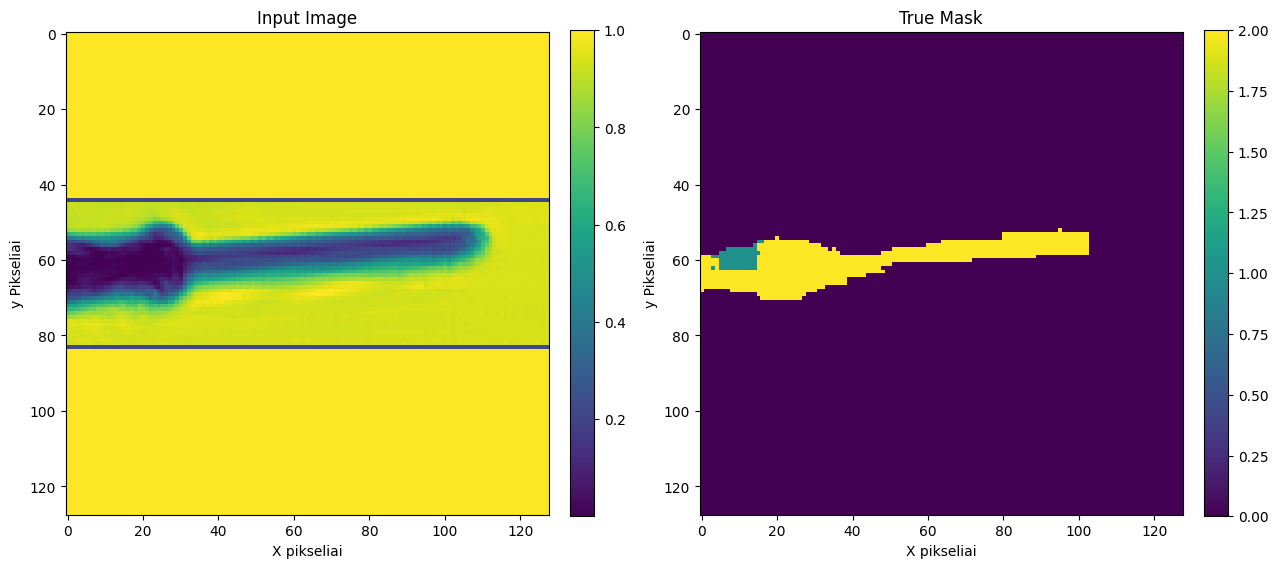

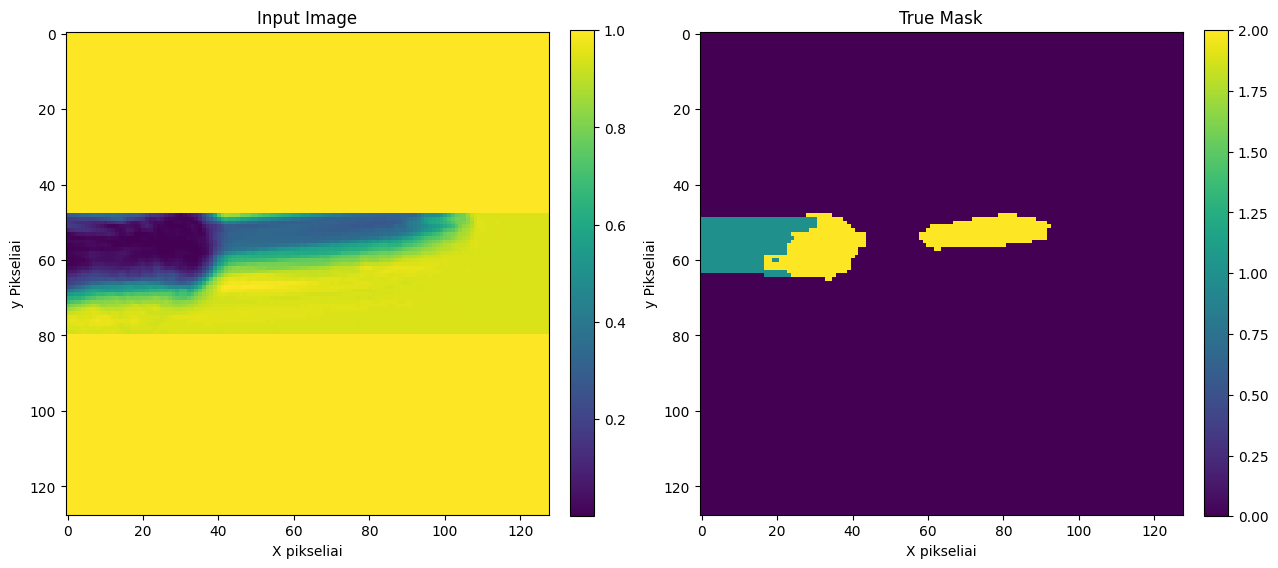

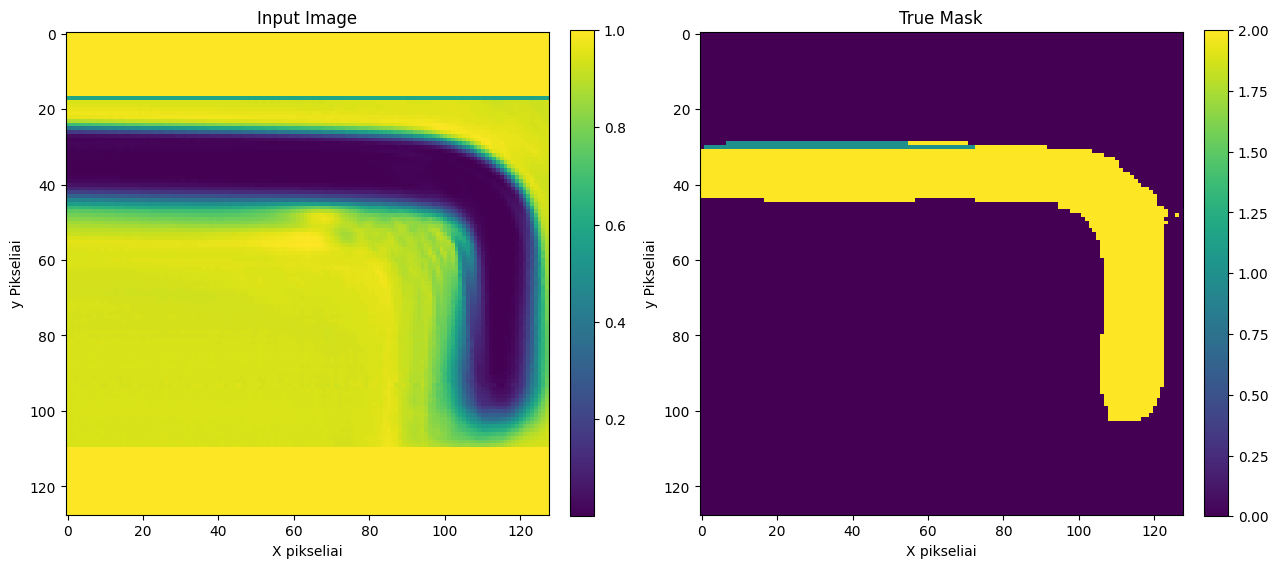

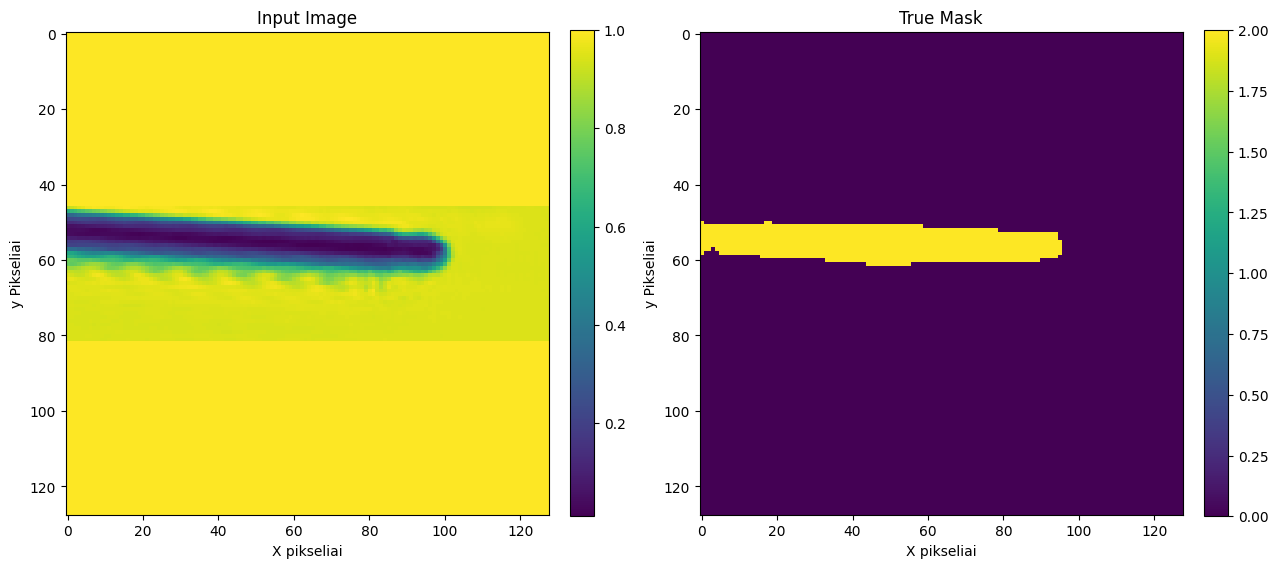

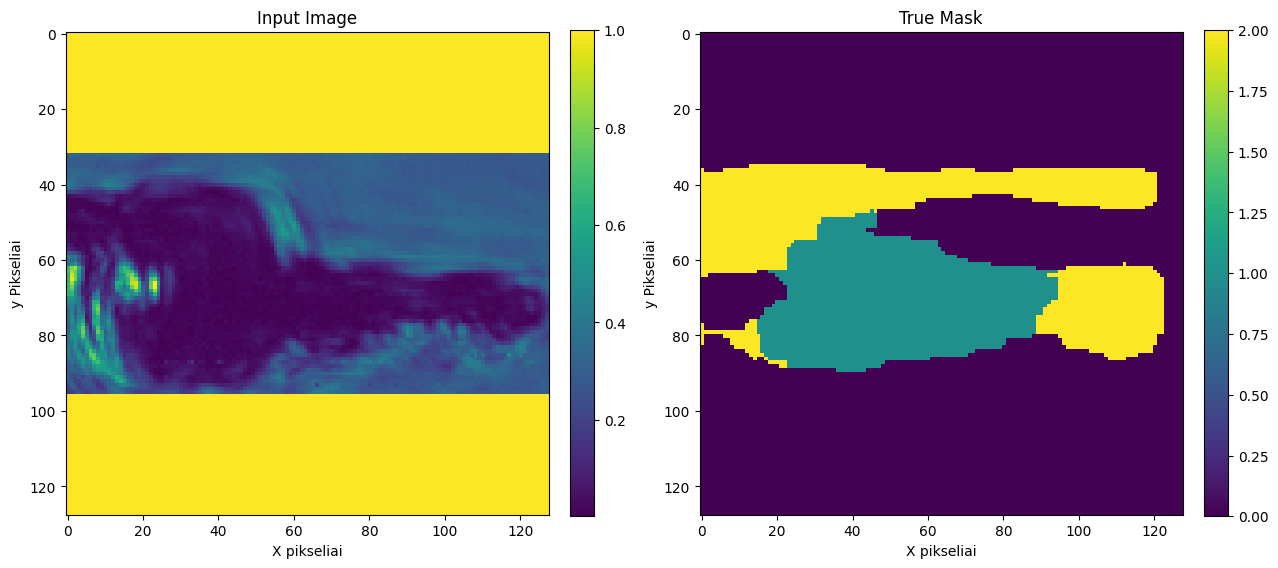

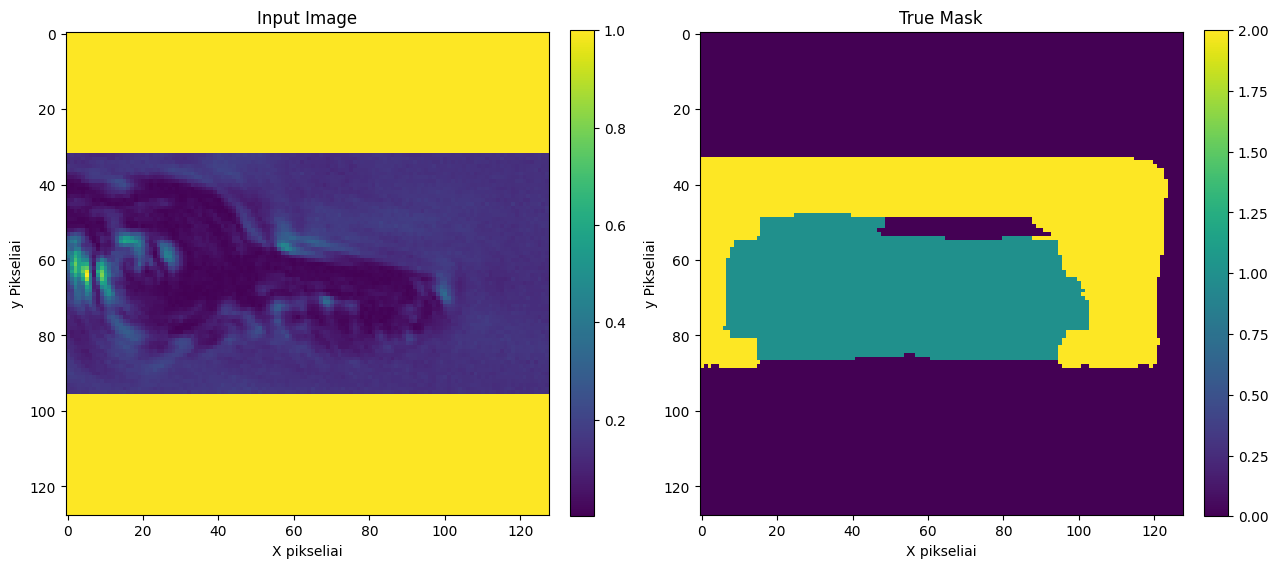

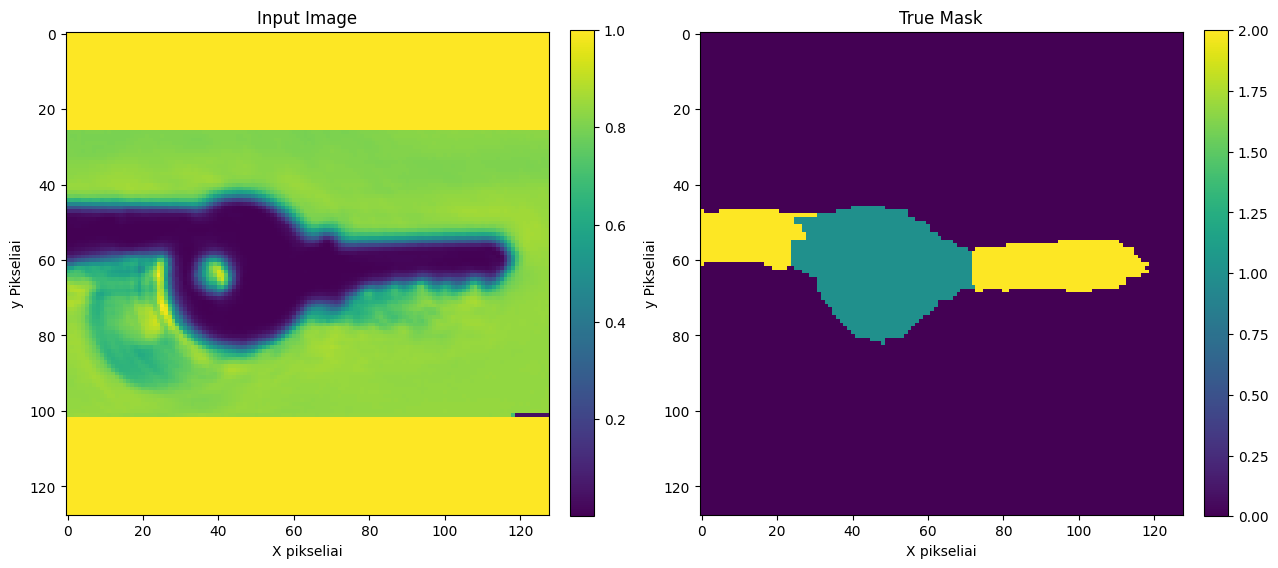

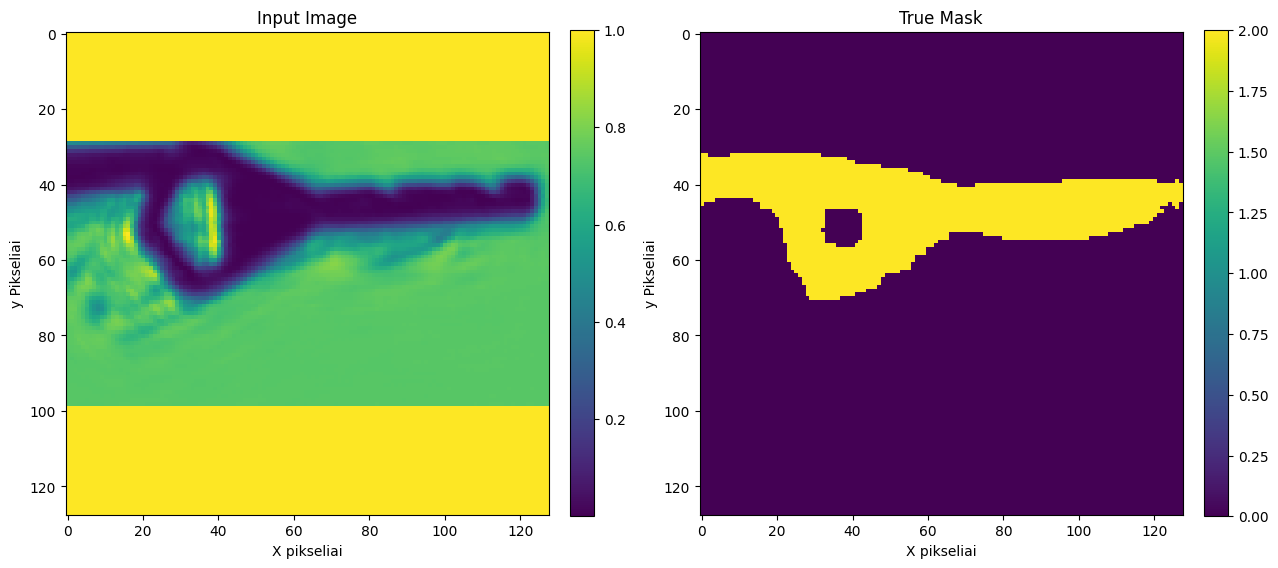

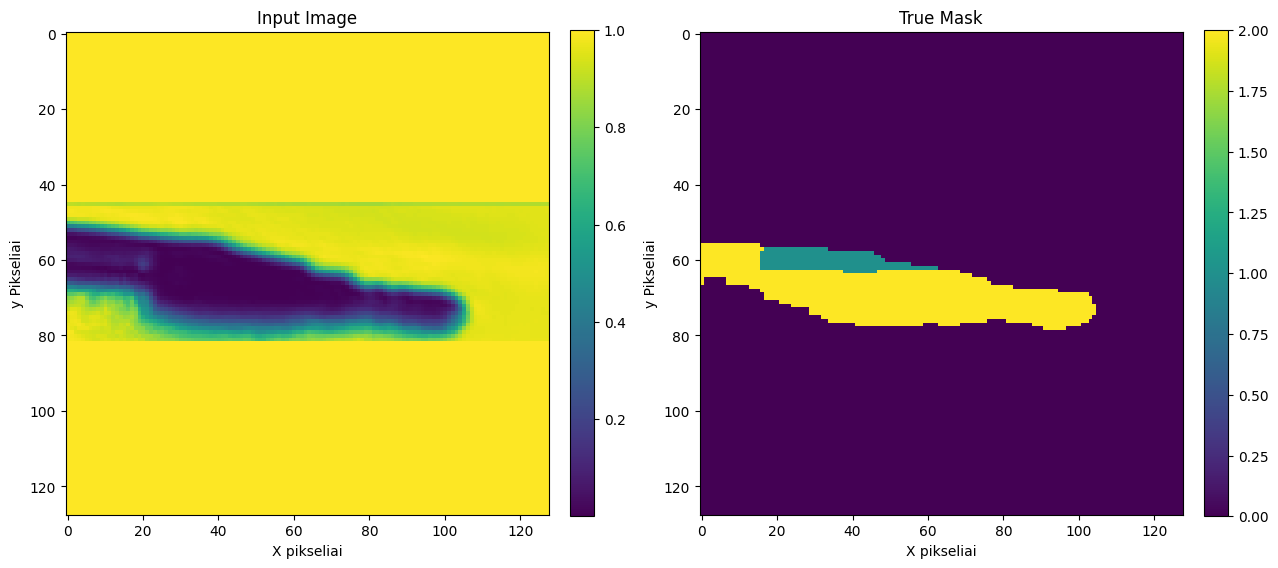

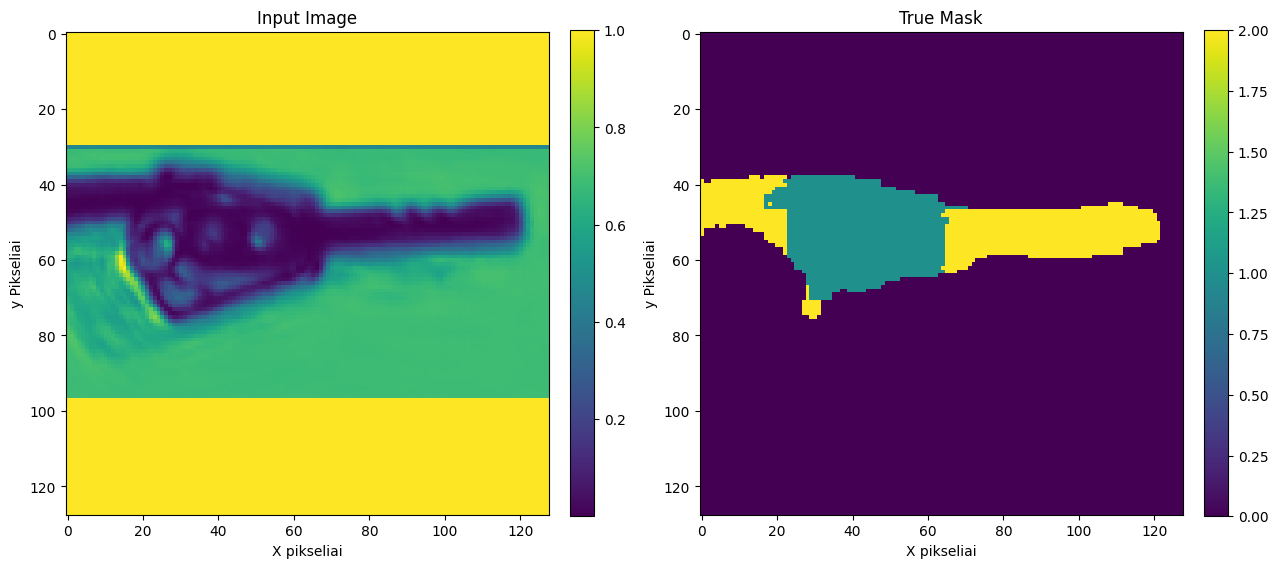

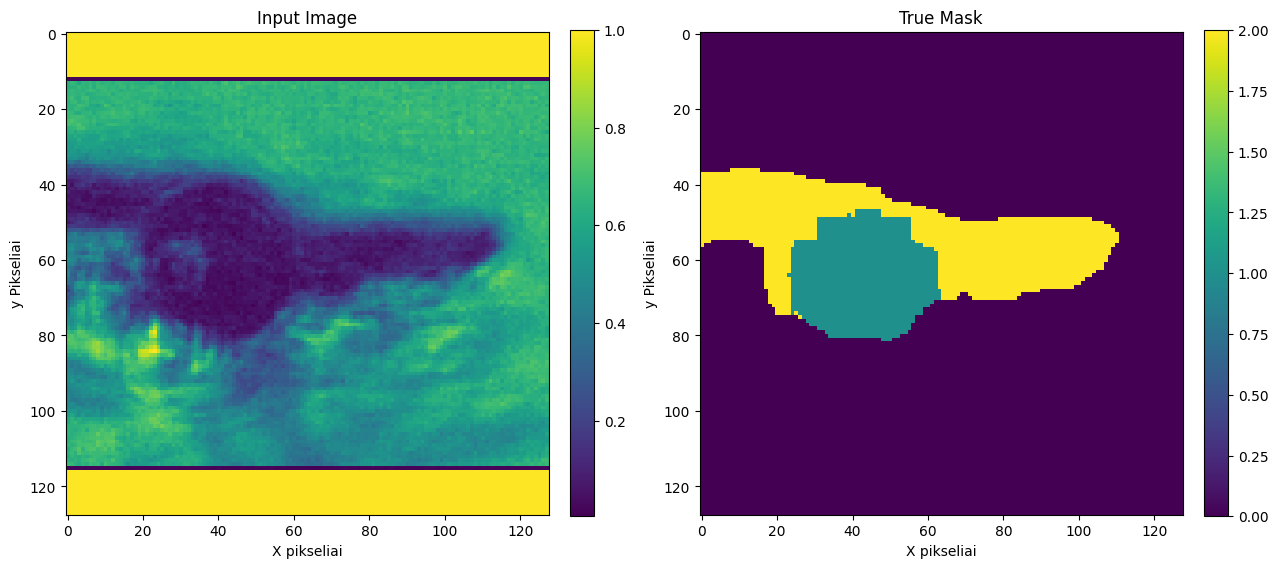

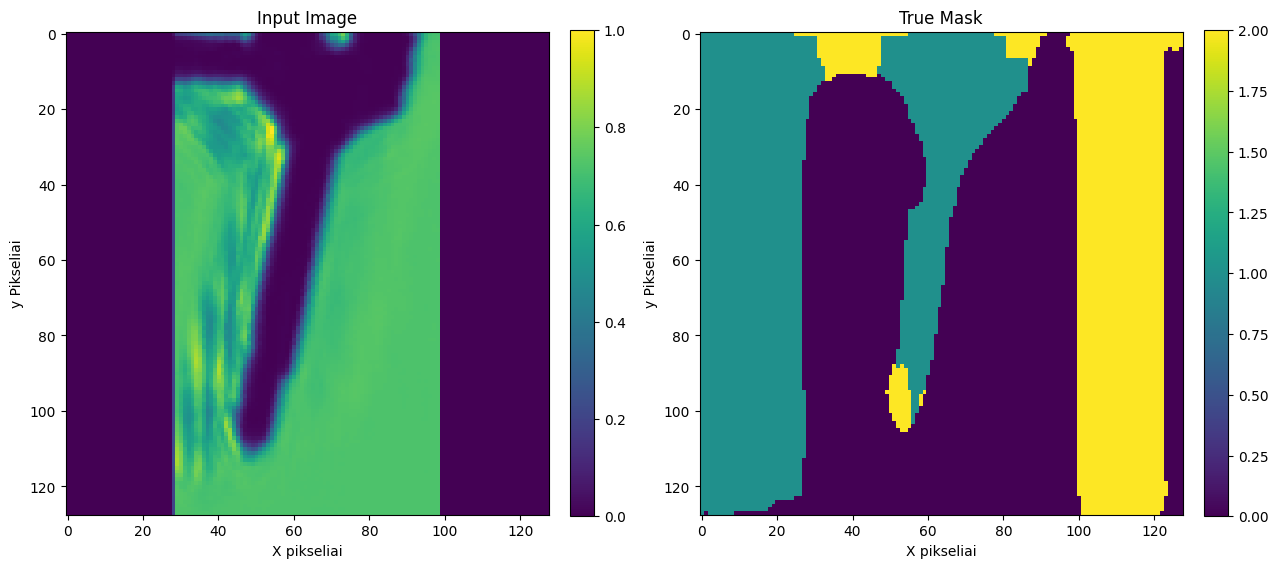

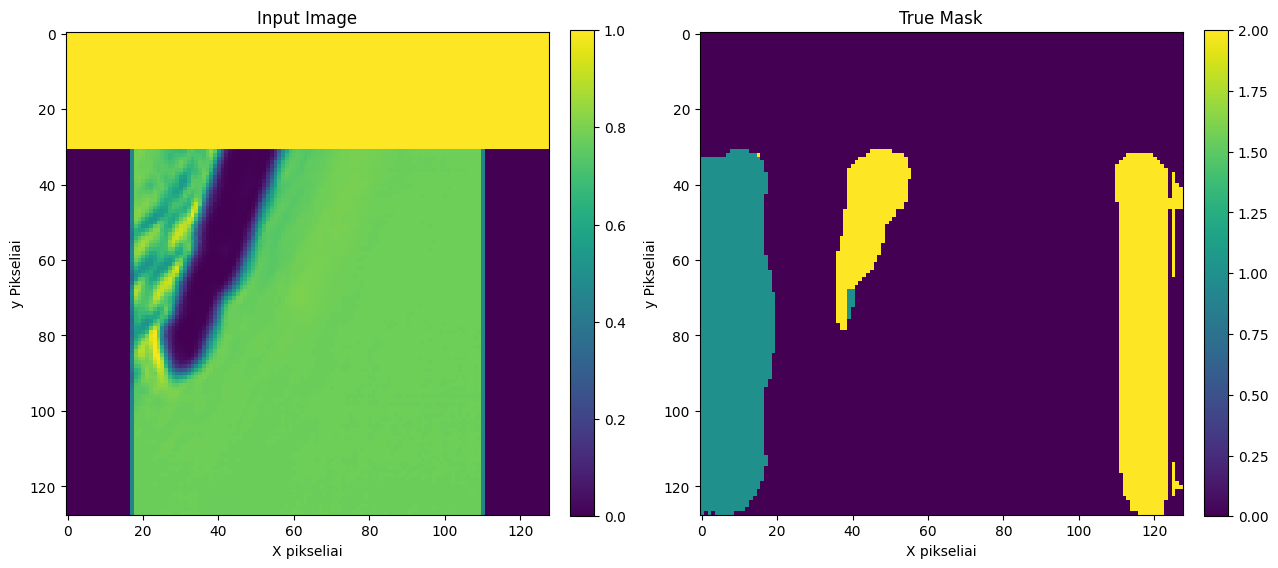

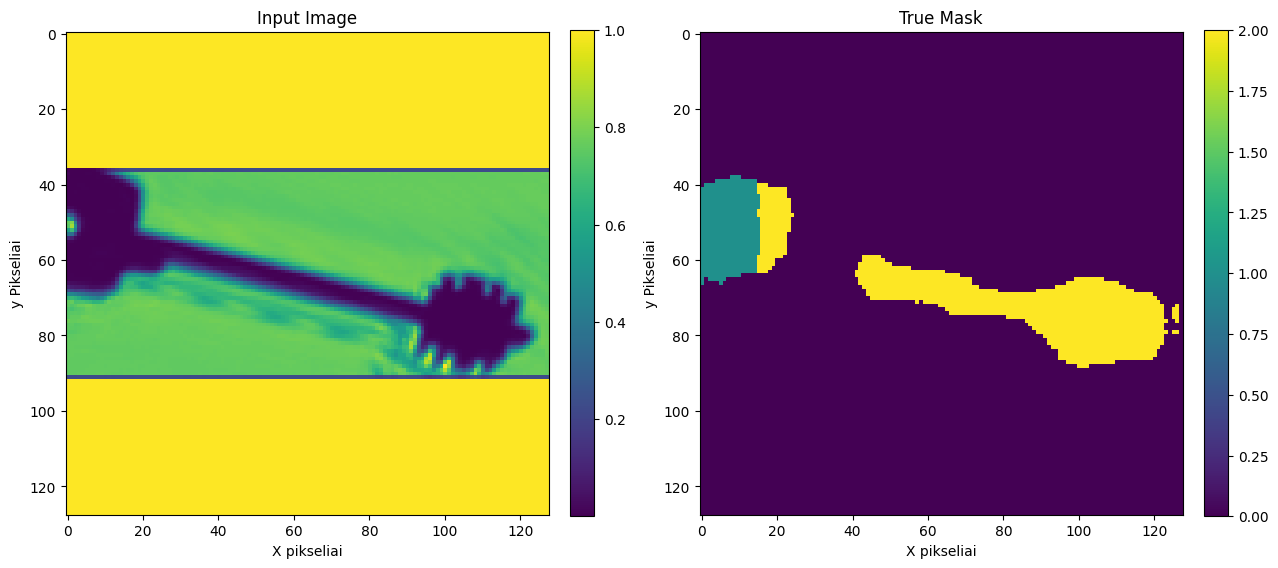

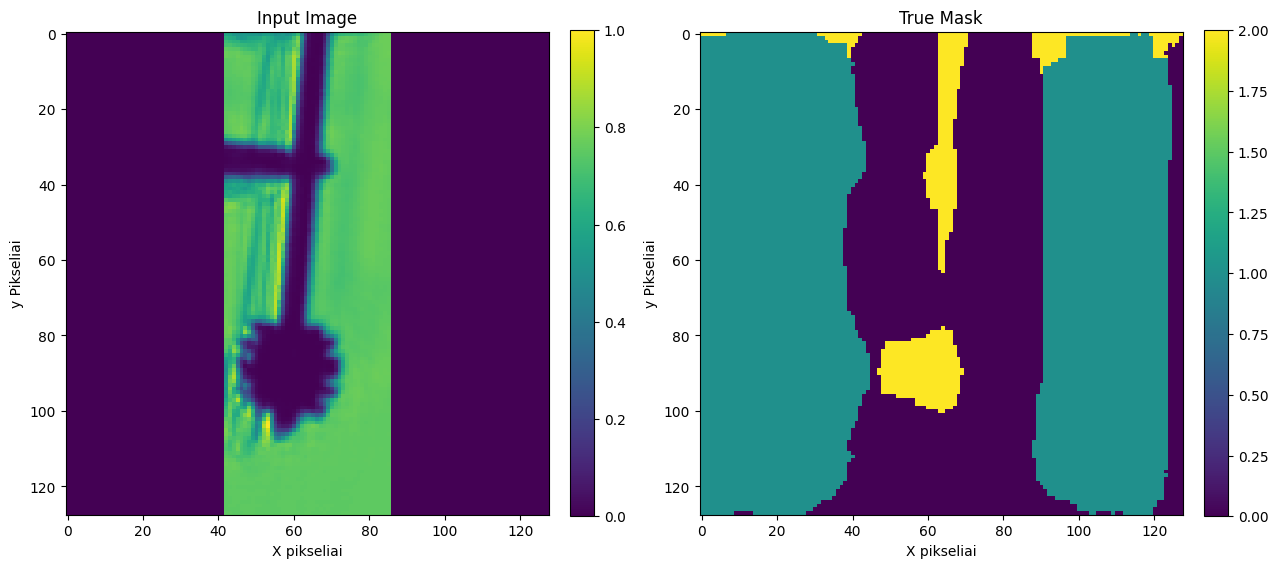

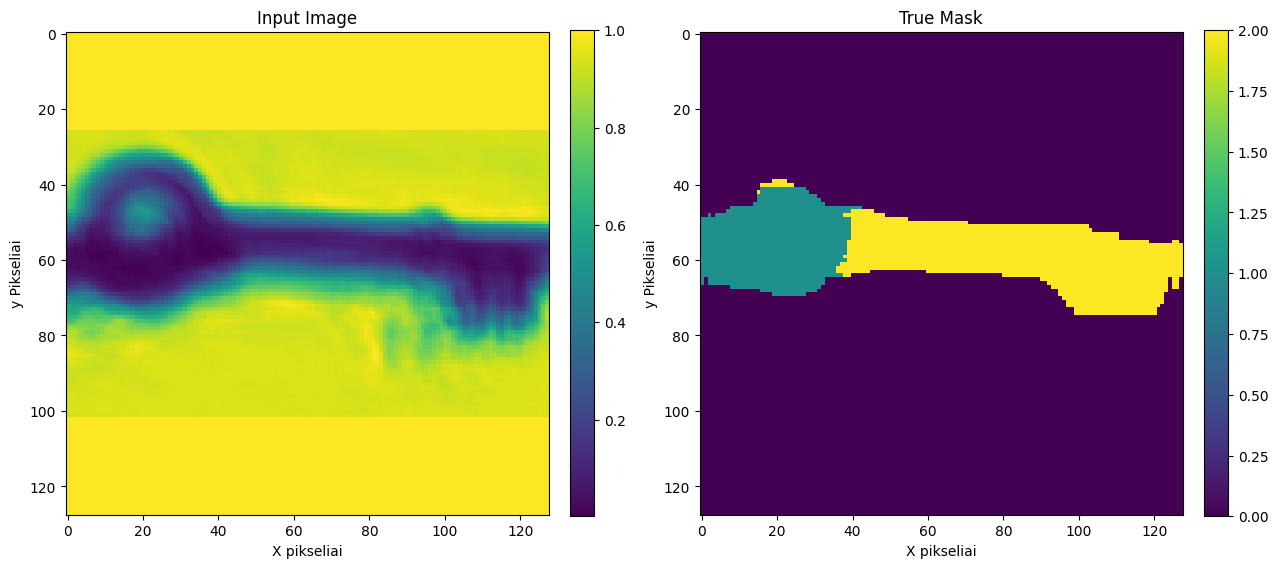

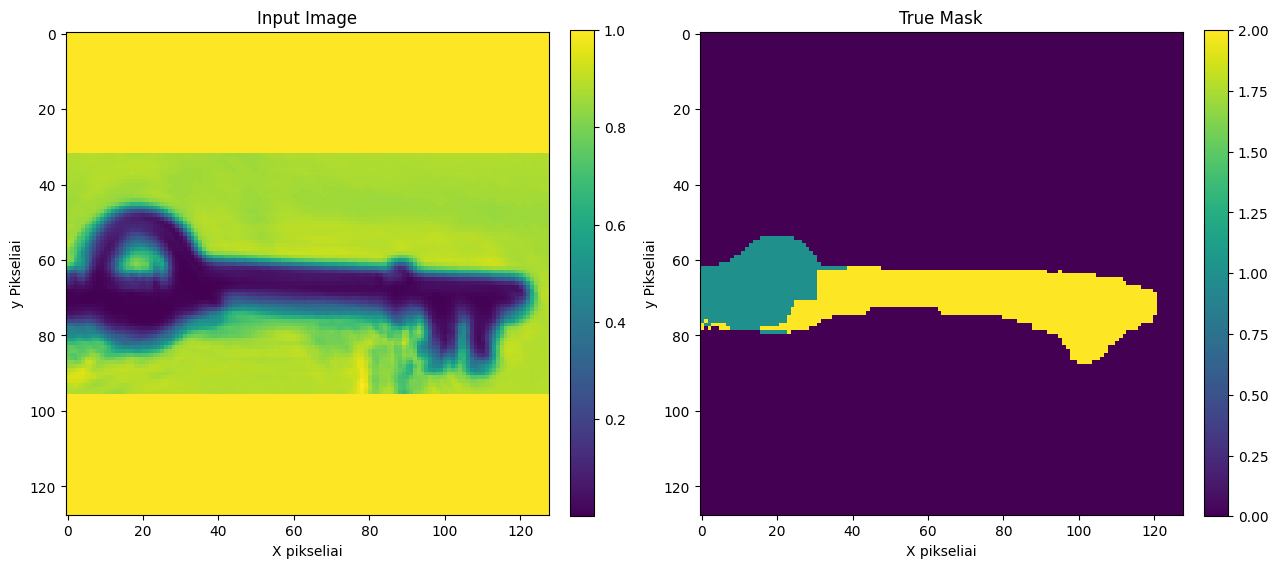

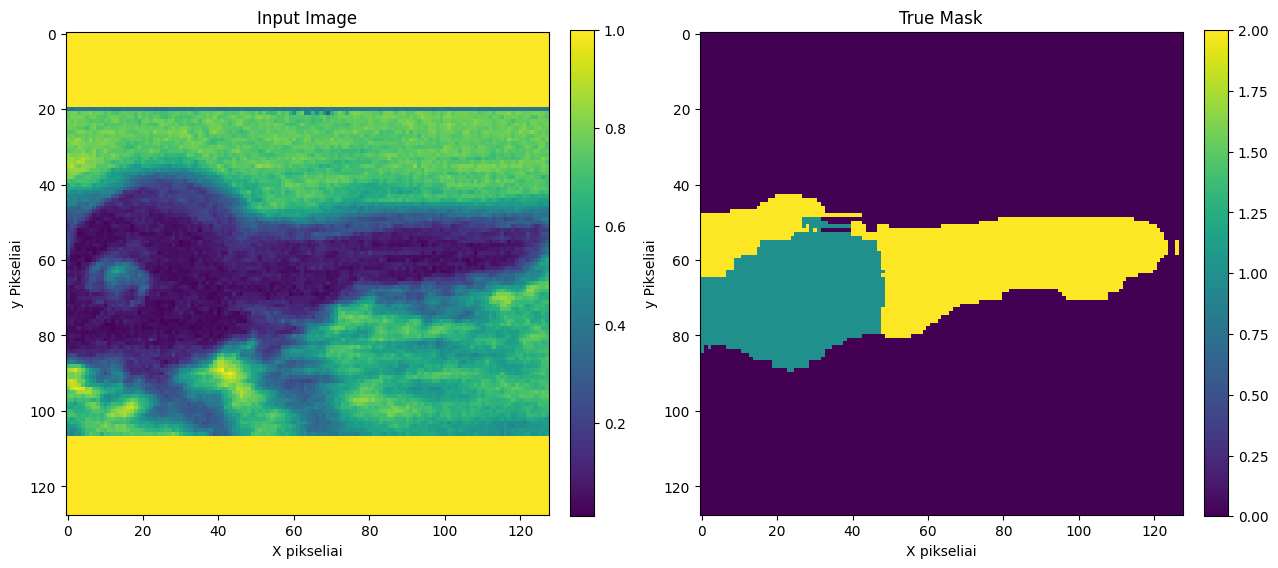

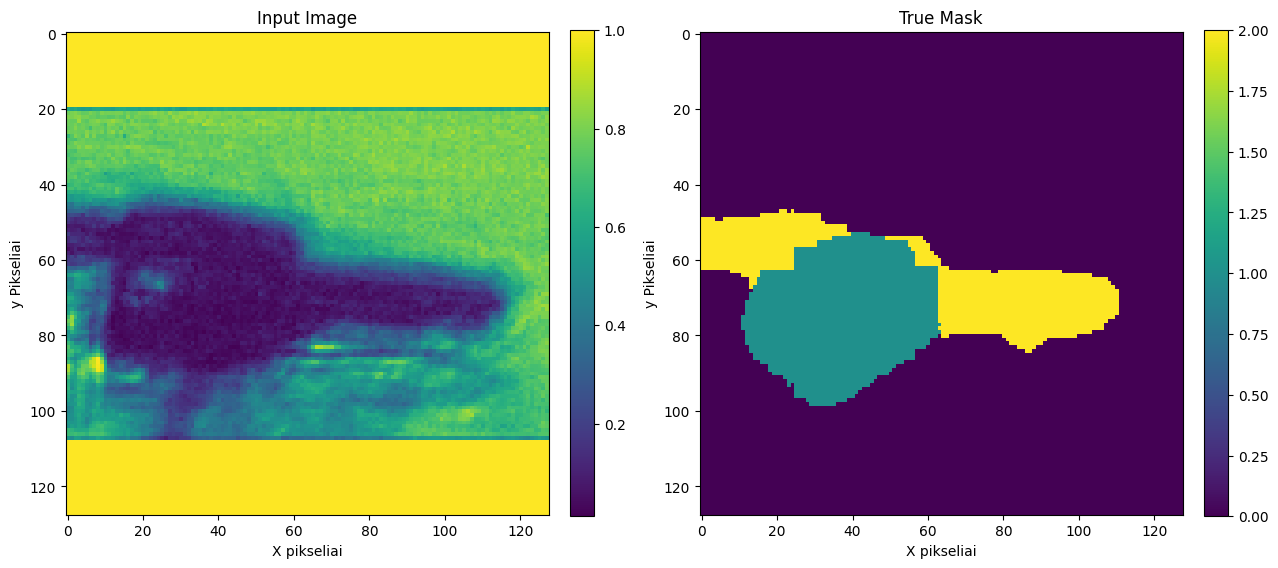

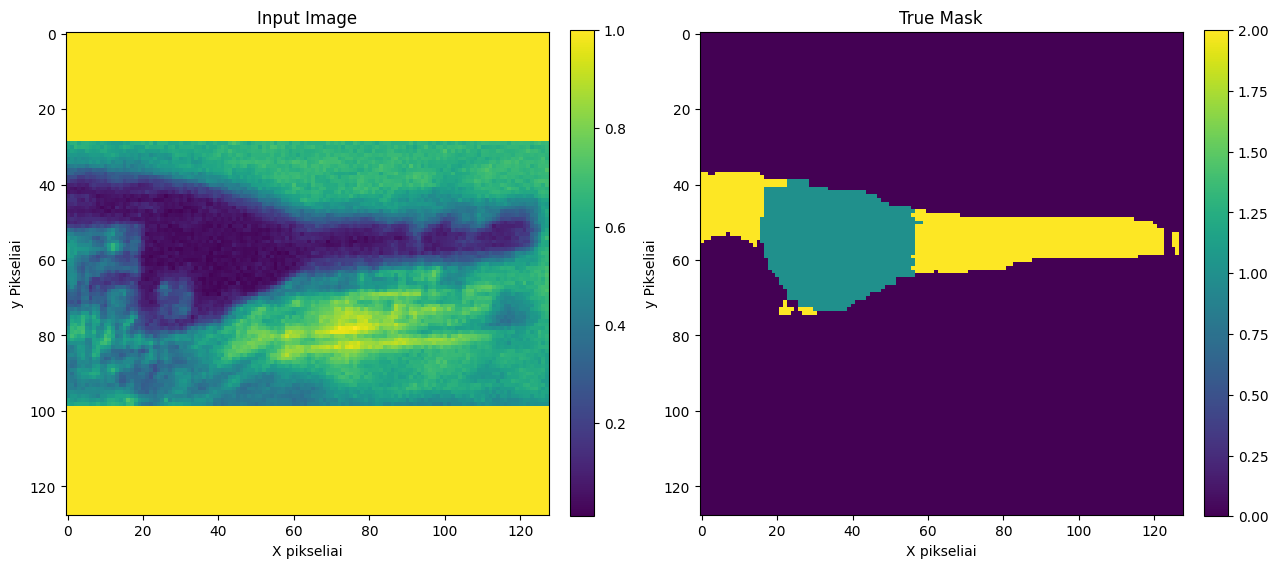

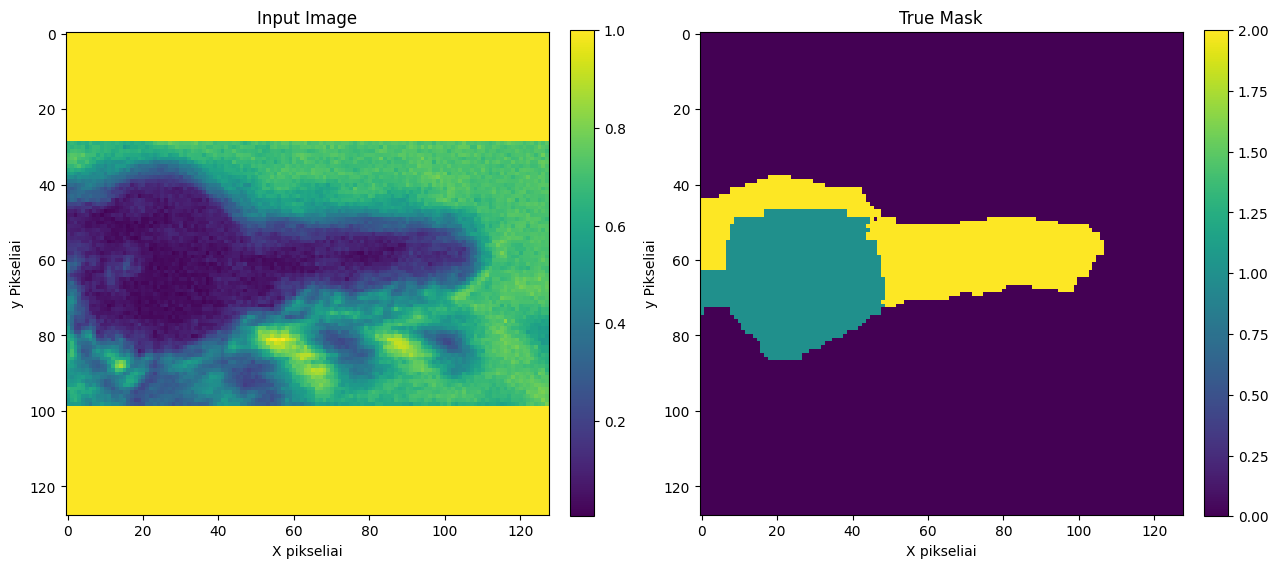

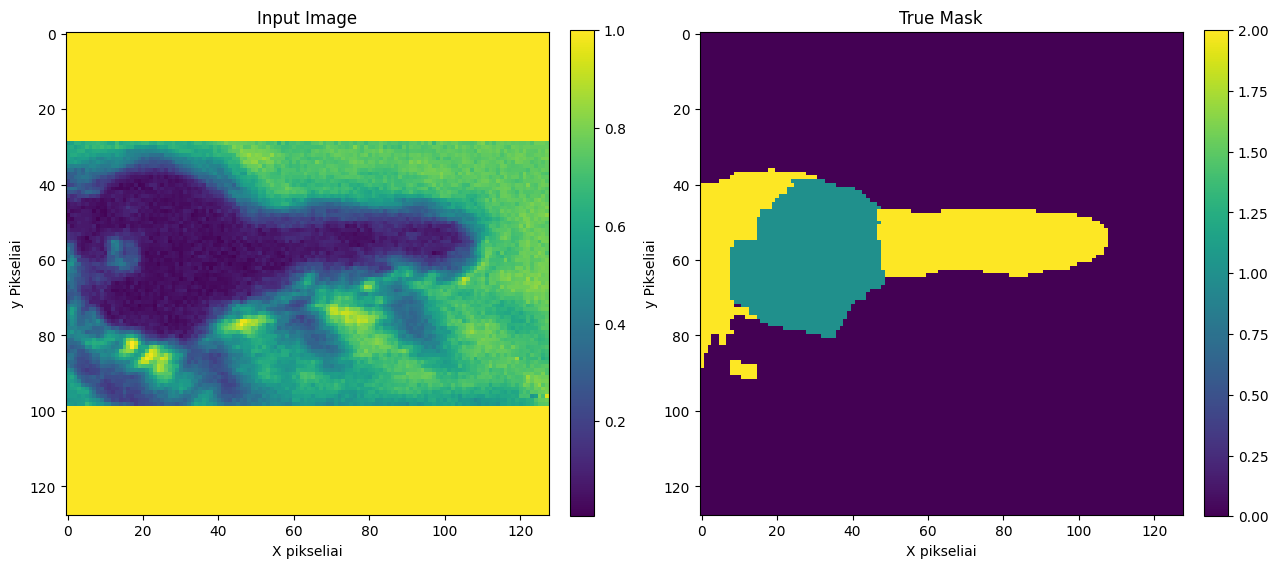

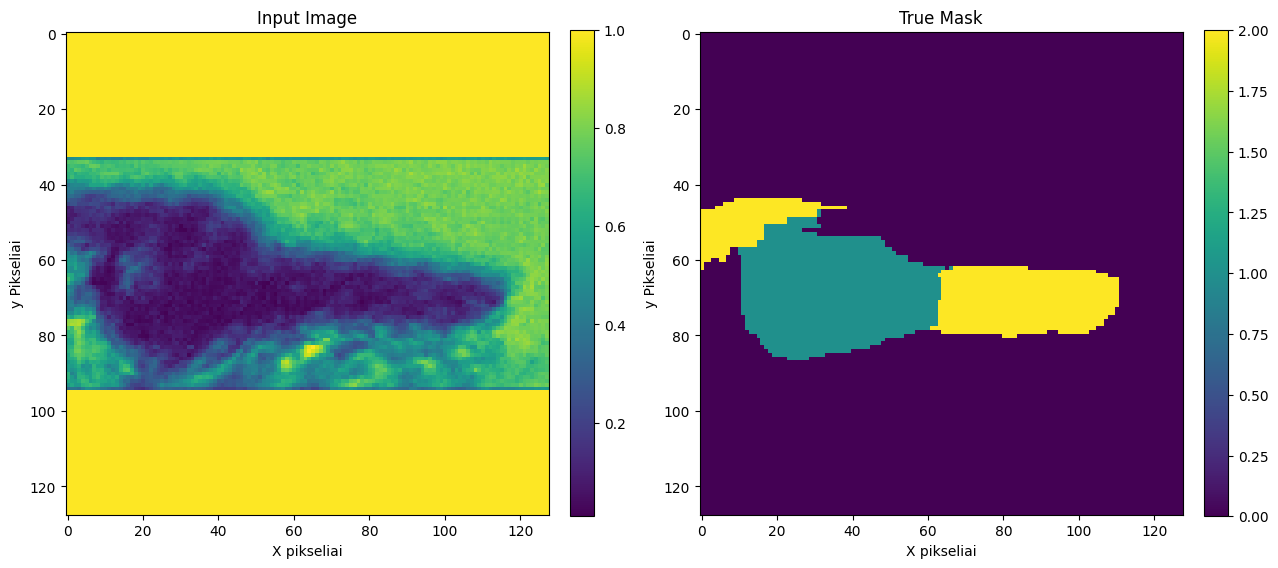

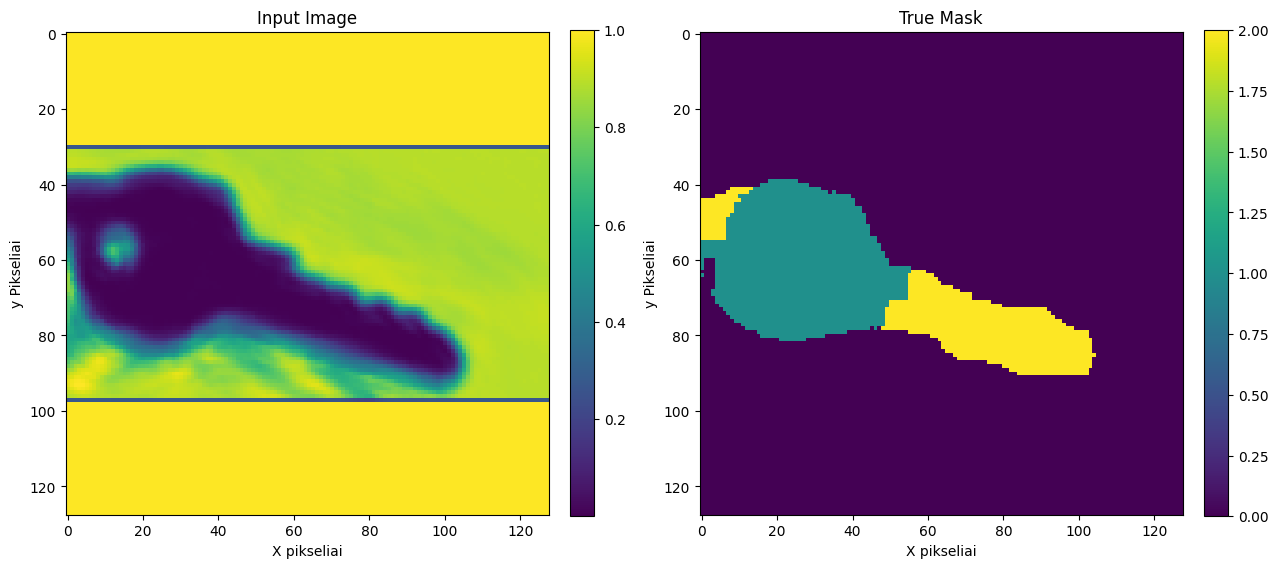

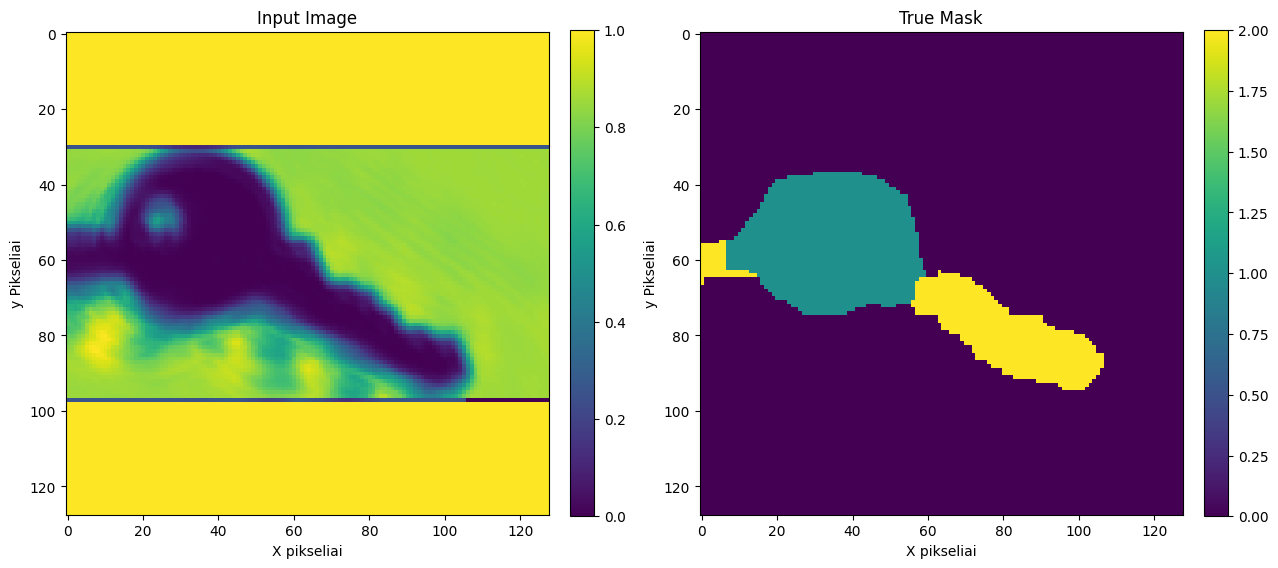

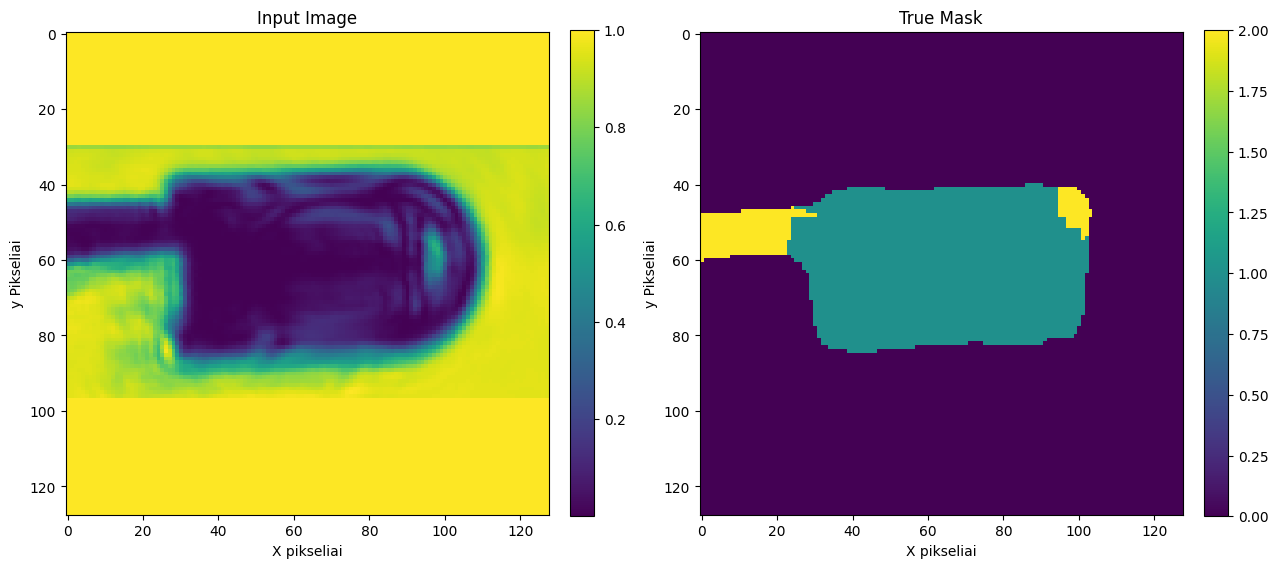

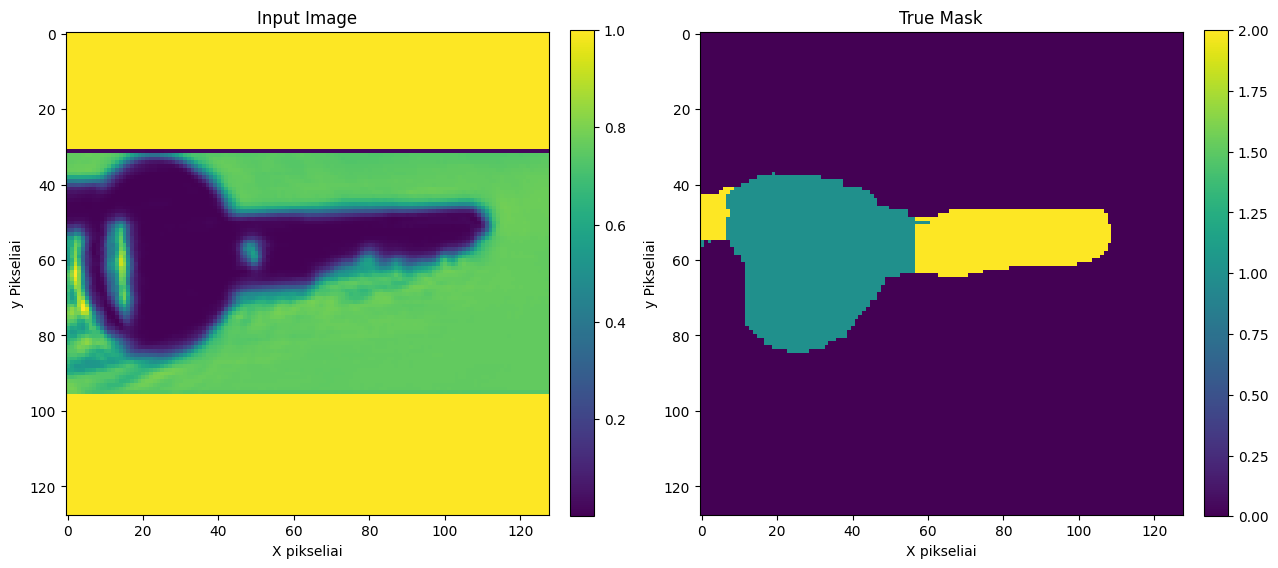

In [ ]:
for num in range(len(test_data)):
    display([test_data[num], create_mask(test_data_pred[num])])
    print(num, end="\r")
    os.system('cls' if os.name == 'nt' else 'clear')

In [ ]:
model.save_weights('/content/gdrive/My Drive/My stupid projects/Hatsune_Miku/segmentation/checkpoints/save_rotation_bbzep_03drop.weights.h5')

In [ ]:
#model.load_weights('/content/gdrive/My Drive/My stupid projects/Hatsune_Miku/segmentation/checkpoints/save_rotation_30ep_03drop.weights.h5')